## DR vs PCA comparisons

In [21]:
from pytorch_lightning import utilities as pl_utils
from pytorch_lightning.trainer.trainer import Trainer
from pytorch_lightning.plugins import DDPPlugin
import torch
import pathlib
from functools import partial
import sys, glob, os, copy
import numpy as np
import itertools

sys.path.append('..')
sys.path.append('../deep-learning-base')
sys.path.append('../deep-learning-base/training')
sys.path.append('../deep-learning-base/datasets')
sys.path.append('../partially_inverted_reps')

import plot_helper as plt_hp
import output as out
from training import LitProgressBar, NicerModelCheckpointing
import training.finetuning as ft
import architectures as arch
from architectures.callbacks import LightningWrapper, LinearEvalWrapper
from attack.callbacks import AdvCallback
from data_modules import DATA_MODULES
import dataset_metadata as dsmd
from partial_loss import PartialInversionLoss, PartialInversionRegularizedLoss
from __init__ import DATA_PATH_IMAGENET, DATA_PATH, DATA_PATH_FLOWERS_PETS, SERVER_PROJECT_PATH

In [5]:
CHECKPOINT_PATHS = {
    'resnet50': {
        'nonrob': '',
        'robustl2eps3': '/NS/robustness_3/work/vnanda/adv-robustness/logs/'\
                        'robust_imagenet/eps3/resnet-50-l2-eps3.ckpt'}
}

In [6]:
SEED = 2
NUM_NODES = 1
DEVICES = 1
BASE_DIR = f"{pathlib.Path('.').parent.resolve()}/checkpoints"

FINETUNING_DATASETS = ['cifar10', 'cifar100', 'flowers', 'oxford-iiit-pets']
FINETUNE_BS = 256
EVAL_BATCH_SIZE = 100

In [11]:
def save_predictions(model_path, out):
    preds_path = f'{model_path.split(".ckpt")[0]}.pred'
    torch.save({'pred': out[0].detach().cpu(), 'gt': out[2].detach().cpu()}, preds_path)

def load_predictions(model_path):
    preds_path = f'{model_path.split(".ckpt")[0]}.pred'
    if os.path.exists(preds_path):
        return torch.load(preds_path)

def accuracy(gt, pred):
    pred = torch.argmax(pred, 1)
    return torch.sum(gt == pred) / len(gt)


def get_test_acc(model, mode, source_dataset, finetuning_dataset, checkpoint_path, model_path, seed, fraction):
    state_dict = torch.load(model_path)
    dm = DATA_MODULES[finetuning_dataset](
        data_dir=DATA_PATH_IMAGENET if 'imagenet' in finetuning_dataset else \
            DATA_PATH_FLOWERS_PETS if finetuning_dataset in ['flowers','oxford-iiit-pets'] else DATA_PATH,
        transform_train=dsmd.TRAIN_TRANSFORMS_TRANSFER_DEFAULT(224),
        transform_test=dsmd.TEST_TRANSFORMS_DEFAULT(224),
        batch_size=EVAL_BATCH_SIZE)
    dm.init_remaining_attrs(source_dataset)

    ## assign mean and std from source dataset
    m1 = arch.create_model(model, source_dataset, pretrained=True,
                           checkpoint_path=checkpoint_path, seed=SEED, 
                           num_classes=dsmd.DATASET_PARAMS[source_dataset]['num_classes'],
                           callback=partial(LightningWrapper, 
                                            dataset_name=source_dataset,
                                            inference_kwargs={'with_latent': True}),
                           loading_function_kwargs={'strict': False})
    
    if 'pca' in mode:
        append = model_path.split('/')[-2].split('-')[-1]
        base_path = '/'.join(model_path.split('/')[:-2])
        layer_kwargs = {'projection_matrix': torch.load(f'{base_path}/principal_components_{append}.pt')}
        if mode == 'pca-least':
            layer_kwargs['which'] = 'least'
    elif mode == 'randproj':
        layer_kwargs = {'generator': torch.Generator().manual_seed(seed)}
    else:
        layer_kwargs = {}
    
    new_layer = ft.setup_model_for_finetuning(
        m1.model, 
        dsmd.DATASET_PARAMS[finetuning_dataset]['num_classes'],
        mode, fraction, seed, layer_kwargs=layer_kwargs)
    print (new_layer.__dict__)
    linear_layer = list(m1.model.named_modules())[-1][1]
    linear_layer.load_state_dict({k.split('.')[-1]:v \
                                  for k,v in state_dict['state_dict'].items()}, strict=True)
    if hasattr(new_layer, 'neuron_indices') and 'neuron_indices' in state_dict:
        assert torch.all(new_layer.neuron_indices == state_dict['neuron_indices'])
    pl_utils.seed.seed_everything(seed, workers=True)

    trainer = Trainer(accelerator='gpu', 
                      devices=DEVICES,
                      num_nodes=NUM_NODES,
                      log_every_n_steps=1,
                      auto_select_gpus=True, 
                      deterministic=True,
                      check_val_every_n_epoch=1,
                      num_sanity_val_steps=0,
                      callbacks=[
                        LitProgressBar(['loss', 
                                        'running_test_acc'])])

    out = trainer.predict(m1, dataloaders=[dm.test_dataloader()])
    save_predictions(model_path, out)
    gt, pred = out[2], out[0]
    return accuracy(gt, pred)

In [29]:
def results(model, MODES, source_dataset, FRACTIONS_OR_NUMBERS=None):
    plt_str = '== Finetuning results ==\n\n'
    dataset_to_res = {}
    for ft_ds in FINETUNING_DATASETS:
        model_to_frac_wise_test = {}
        plt_str += f'==== {ft_ds} ====\n\n'
        for append in CHECKPOINT_PATHS[model].keys():
            plt_str += f'=== {model} - {append} ===\n\n'
            for mode in MODES:
                frac_wise_test_accs = {}
                if FRACTIONS_OR_NUMBERS is None:
                    FRACTIONS_OR_NUMBERS = sorted(
                        list(set(
                            [float(x.split('/frac-')[1].split('-')[0]) for x in \
                                glob.glob(f'./checkpoints/{model}-base-'
                                      f'{source_dataset}-ft-{ft_ds}/'
                                      f'*-mode-{mode}-*-bs-256-{append}') \
                             if len(x.split('/frac-')[1].split('-')[0]) == 7 and \
                                'full-feature' not in x and \
                                'layer' not in x and \
                                'pool' not in x]
                            )))
                for frac in FRACTIONS_OR_NUMBERS:
                    if isinstance(frac, int):
                        actual_fraction = frac / FRACTIONS_OR_NUMBERS[-1]
                    else:
                        actual_fraction = frac
                    PARTIAL_CHOICE_SEEDS = sorted(
                        list(set(
                            [int(x.split('-seed-')[1].split('-')[0]) for x in \
                                glob.glob(f'./checkpoints/{model}-base-'
                                          f'{source_dataset}-ft-{ft_ds}/'
                                          f'frac-{actual_fraction:.5f}-mode-{mode}-*-bs-256-{append}') \
                            if len(x.split('/frac-')[1].split('-')[0]) == 7 and \
                               'full-feature' not in x and \
                               'layer' not in x and \
                               'pool' not in x]
                            )))
                    for seed in PARTIAL_CHOICE_SEEDS:
                        model_path = [x for x in glob.glob(f'{BASE_DIR}/{model}-base-{source_dataset}-ft-{ft_ds}/'
                                               f'frac-{actual_fraction:.5f}-mode-{mode}-seed-{seed}-'
                                               f'ftmode-linear-lr-*-bs*-{append}/'
                                               '*-topk=1.ckpt') \
                                      if len(x.split('/frac-')[1].split('-')[0]) == 7 and \
                                         'full-feature' not in x and \
                                         'layer' not in x and \
                                         'pool' not in x]
                        if len(model_path) == 0:
                            continue
                        model_path = model_path[0]

                        pickled_preds = load_predictions(model_path)
                        if pickled_preds is not None:
                            test_acc = accuracy(pickled_preds['gt'], pickled_preds['pred']).item()
                        else:
                            test_acc = get_test_acc(model, mode, source_dataset, ft_ds, 
                                                    CHECKPOINT_PATHS[model][append], 
                                                    model_path, seed, actual_fraction)
                        if frac in frac_wise_test_accs:
                            frac_wise_test_accs[frac].append(test_acc)
                        else:
                            frac_wise_test_accs[frac] = [test_acc]
            
                model_to_frac_wise_test[f'{model}-{append}-{mode}'] = copy.deepcopy(frac_wise_test_accs)
        
        dataset_to_res[ft_ds] = model_to_frac_wise_test
        legend_vals = list(zip(*sorted(model_to_frac_wise_test.items(), key=lambda x:x[0])))[0]
        plt_str += '{}\n\n'.format(plt_hp.get_wiki_link(plt_hp.line_plot(
            [[np.nanmean(x_val) for x_val in list(zip(*sorted(frac_wise_accs.items(), key=lambda x:x[0])))[1]] \
             for _, frac_wise_accs in sorted(model_to_frac_wise_test.items(), key=lambda x:x[0])], 
            'Fraction of Neurons', 'Transfer Accuracy', ft_ds, subfolder=source_dataset, 
            filename=f'{model}_{ft_ds}_bs_{FINETUNE_BS}_pca_v_random_comparison', extension='png', 
            x_vals=[list(zip(*sorted(frac_wise_accs.items(), key=lambda x:x[0])))[0] \
                    for _, frac_wise_accs in sorted(model_to_frac_wise_test.items(), key=lambda x:x[0])], 
            legend_vals=legend_vals, colors=[plt_hp.COLORS[0]] * 2 + \
                                            [plt_hp.COLORS[1]] * 2 + [plt_hp.COLORS[1]] * 2,
            linestyles=[':' if x.endswith('-pca') else '--' if x.endswith('-pca-least') else '-' \
                        for x in legend_vals], 
            y_lims=(0.,1.), root_dir='.', 
            paper_friendly_plots=True, plot_inside=False, legend_location='best', 
            savefig=True, figsize=(10,6), marker=[True]*len(legend_vals), 
            results_subfolder_name='pca_comparison', grid_spacing=None, 
            y_err=[[np.nanstd(x_val) for x_val in \
                    list(zip(*sorted(frac_wise_accs.items(), key=lambda x:x[0])))[1]] \
                   for _, frac_wise_accs in sorted(model_to_frac_wise_test.items(), key=lambda x:x[0])], 
            legend_ncol=4), SERVER_PROJECT_PATH, size=700))
    
    with open(f'./results/pca_comparison/{source_dataset}/'
              f'wiki_results-{model}.txt', 'w') as fp:
        fp.write(plt_str)
    out.upload_results(['{}/{}/{}'.format(plt_hp.RESULTS_FOLDER_NAME, 'pca_comparison', source_dataset)], 
        'results', SERVER_PROJECT_PATH, '.png')
    return dataset_to_res

In [24]:
for ft_ds, m in itertools.product(['cifar10', 'pets'], ['pca', 'random']):
    print (ft_ds, m)

cifar10 pca
cifar10 random
pets pca
pets random


In [25]:
def plotter(data_to_fracwise, model, append, modes=['random','pca'],
            filename_append='pca_v_random_comparison'):
    y_vals_for_plotting = [[np.nanmean(_l) for _l in list(zip(*sorted(
                                data_to_fracwise[ft_ds][f'{model}-{append}-{m}'].items(), 
                                key=lambda x: x[0])))[1]] \
                           for m, ft_ds in itertools.product(modes, FINETUNING_DATASETS)] \
#                           + \
#                           [[np.nanmean(_l) for _l in list(zip(*sorted(
#                                 data_to_fracwise[ft_ds][f'{model}-{append}-pca'].items(), 
#                                 key=lambda x: x[0])))[1]] \
#                            for ft_ds in FINETUNING_DATASETS]
    y_errs_for_plotting = [[np.nanstd(_l) for _l in list(zip(*sorted(
                                data_to_fracwise[ft_ds][f'{model}-{append}-{m}'].items(), 
                                key=lambda x: x[0])))[1]] \
                           for m, ft_ds in itertools.product(modes, FINETUNING_DATASETS)]\
#                           + \
#                           [[np.nanstd(_l) for _l in list(zip(*sorted(
#                                 data_to_fracwise[ft_ds][f'{model}-{append}-pca'].items(), 
#                                 key=lambda x: x[0])))[1]] \
#                            for ft_ds in FINETUNING_DATASETS]
    x_vals_for_plotting = [[np.nanmean(_l) for _l in list(zip(*sorted(
                                data_to_fracwise[ft_ds][f'{model}-{append}-{m}'].items(), 
                                key=lambda x: x[0])))[0]] \
                           for m, ft_ds in itertools.product(modes, FINETUNING_DATASETS)] \
#                             + \
#                           [[np.nanmean(_l) for _l in list(zip(*sorted(
#                                 data_to_fracwise[ft_ds][f'{model}-{append}-pca'].items(), 
#                                 key=lambda x: x[0])))[0]] \
#                            for ft_ds in FINETUNING_DATASETS]
    plt_hp.line_plot(
        y_vals_for_plotting, 'Fraction of Neurons', 'Transfer Accuracy', 
        append, subfolder='imagenet', 
        filename=f'{model}_{append}_bs_{FINETUNE_BS}_{filename_append}_allds', extension='png', 
        x_vals=x_vals_for_plotting, 
#         legend_vals=[f'{ft}-random' for ft in FINETUNING_DATASETS] + \
#                     [f'{ft}-pca' for ft in FINETUNING_DATASETS], 
        legend_vals=FINETUNING_DATASETS + \
                    [''] * len(FINETUNING_DATASETS) * (len(y_vals_for_plotting) - 1), 
        colors=plt_hp.COLORS[:len(FINETUNING_DATASETS)] * len(y_vals_for_plotting),
        linestyles=['-'] * len(FINETUNING_DATASETS) + [':'] * len(FINETUNING_DATASETS) + \
        ['--'] * len(FINETUNING_DATASETS), 
        y_lims=(0.,1.), root_dir='.', paper_friendly_plots=True, plot_inside=True, 
        legend_location='best', savefig=True, figsize=(10,6), marker=[True]*len(y_vals_for_plotting), 
        results_subfolder_name='pca_comparison', grid_spacing=1, 
        y_err=y_errs_for_plotting, legend_ncol=2)

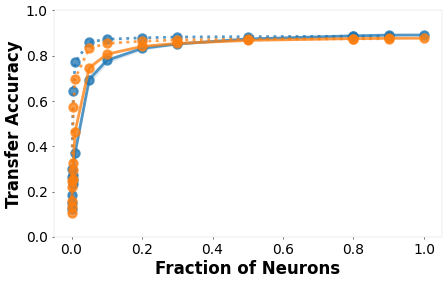

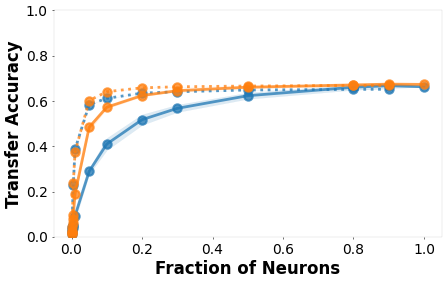

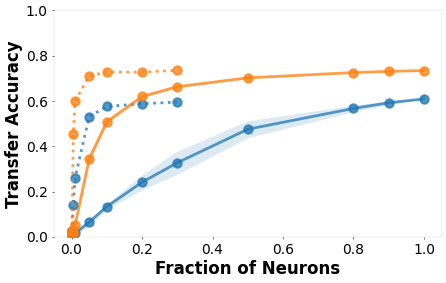

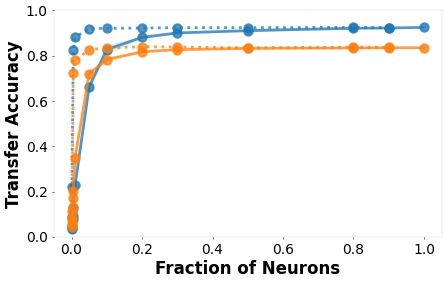

Uploading results in ['results/pca_comparison/imagenet'] to contact.mpi-sws.org...
Uploading 0 files to server


In [7]:
data_to_fracwise = results('resnet50', ['random', 'pca'], 'imagenet')

In [46]:
import importlib
importlib.reload(plt_hp)

<module 'plot_helper' from '../plot_helper.py'>

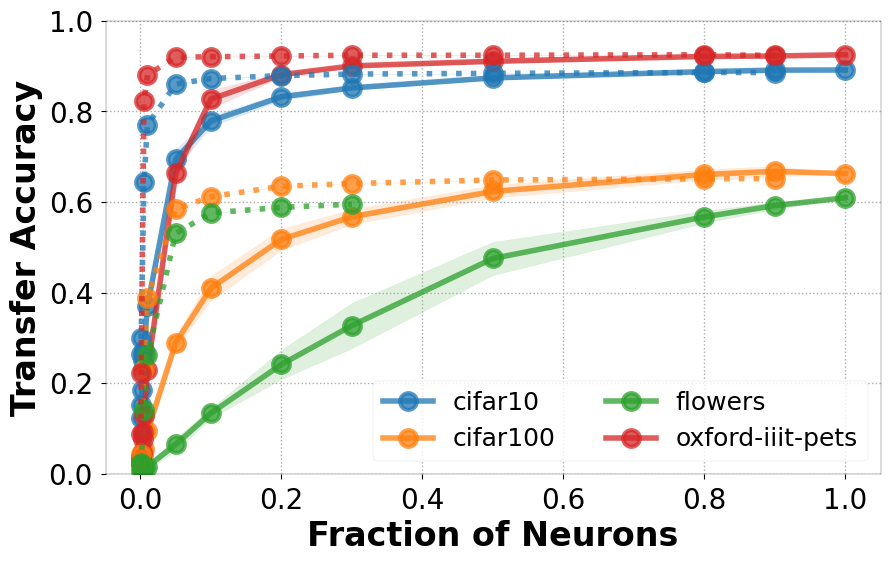

In [47]:
model = 'resnet50'
append = 'nonrob'
plotter(data_to_fracwise, model, append)

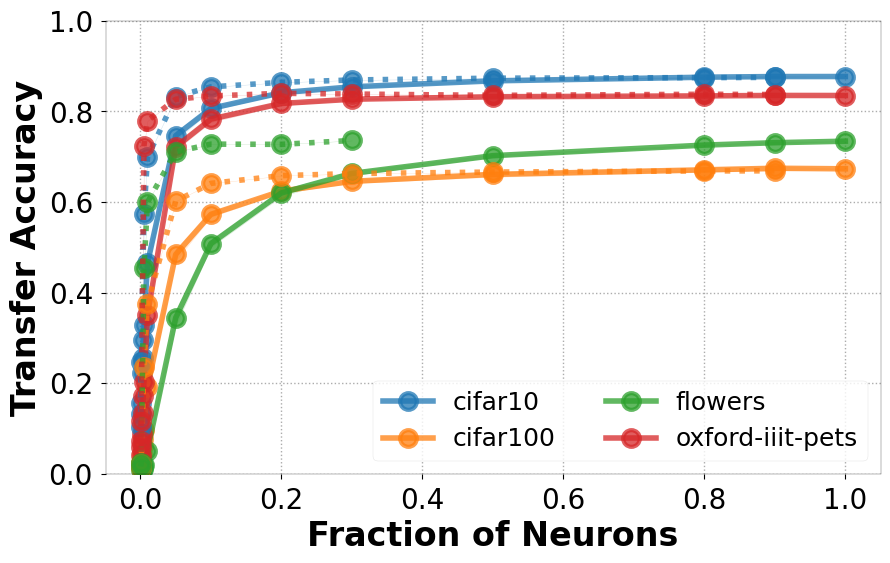

In [48]:
model = 'resnet50'
append = 'robustl2eps3'
plotter(data_to_fracwise, model, append)

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0293],
        [0.0092],
        [0.0327],
        ...,
        [0.0364],
        [0.0066],
        [0.0316]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=10, bias=True))]), 'num_neurons': 1, 'in_features': 1, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0237],
        [0.0259],
        [0.0182],
        ...,
        [0.0135],
        [0.0308],
        [0.0183]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=10, bias=True))]), 'num_neurons': 1, 'in_features': 1, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0002],
        [0.0080],
        [0.0066],
        ...,
        [0.0318],
        [0.0235],
        [0.0114]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=10, bias=True))]), 'num_neurons': 1, 'in_features': 1, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0293, 0.0107],
        [0.0092, 0.0312],
        [0.0327, 0.0087],
        ...,
        [0.0364, 0.0297],
        [0.0066, 0.0059],
        [0.0316, 0.0325]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=2, out_features=10, bias=True))]), 'num_neurons': 2, 'in_features': 2, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0237, 0.0147],
        [0.0259, 0.0166],
        [0.0182, 0.0379],
        ...,
        [0.0135, 0.0363],
        [0.0308, 0.0034],
        [0.0183, 0.0086]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=2, out_features=10, bias=True))]), 'num_neurons': 2, 'in_features': 2, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0002, 0.0040],
        [0.0080, 0.0216],
        [0.0066, 0.0195],
        ...,
        [0.0318, 0.0316],
        [0.0235, 0.0020],
        [0.0114, 0.0307]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=2, out_features=10, bias=True))]), 'num_neurons': 2, 'in_features': 2, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0293, 0.0107, 0.0154,  ..., 0.0282, 0.0217, 0.0167],
        [0.0092, 0.0312, 0.0360,  ..., 0.0061, 0.0263, 0.0285],
        [0.0327, 0.0087, 0.0024,  ..., 0.0358, 0.0185, 0.0114],
        ...,
        [0.0364, 0.0297, 0.0368,  ..., 0.0301, 0.0206, 0.0141],
        [0.0066, 0.0059, 0.0168,  ..., 0.0306, 0.0300, 0.0137],
        [0.0316, 0.0325, 0.0240,  ..., 0.0268, 0.0371, 0.0273]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=10, out_features=10, bias=True))]), 'num_neurons': 10, 'in_features': 10, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0237, 0.0147, 0.0247,  ..., 0.0036, 0.0233, 0.0022],
        [0.0259, 0.0166, 0.0207,  ..., 0.0288, 0.0055, 0.0107],
        [0.0182, 0.0379, 0.0208,  ..., 0.0281, 0.0233, 0.0351],
        ...,
        [0.0135, 0.0363, 0.0187,  ..., 0.0207, 0.0165, 0.0339],
        [0.0308, 0.0034, 0.0073,  ..., 0.0107, 0.0183, 0.0165],
        [0.0183, 0.0086, 0.0305,  ..., 0.0292, 0.0325, 0.0226]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=10, out_features=10, bias=True))]), 'num_neurons': 10, 'in_features': 10, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0002, 0.0040, 0.0110,  ..., 0.0285, 0.0229, 0.0333],
        [0.0080, 0.0216, 0.0208,  ..., 0.0231, 0.0242, 0.0344],
        [0.0066, 0.0195, 0.0333,  ..., 0.0203, 0.0087, 0.0076],
        ...,
        [0.0318, 0.0316, 0.0314,  ..., 0.0128, 0.0191, 0.0040],
        [0.0235, 0.0020, 0.0176,  ..., 0.0106, 0.0372, 0.0259],
        [0.0114, 0.0307, 0.0021,  ..., 0.0274, 0.0280, 0.0313]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=10, out_features=10, bias=True))]), 'num_neurons': 10, 'in_features': 10, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0293, 0.0107, 0.0154,  ..., 0.0190, 0.0356, 0.0251],
        [0.0092, 0.0312, 0.0360,  ..., 0.0186, 0.0359, 0.0336],
        [0.0327, 0.0087, 0.0024,  ..., 0.0059, 0.0310, 0.0329],
        ...,
        [0.0364, 0.0297, 0.0368,  ..., 0.0094, 0.0038, 0.0323],
        [0.0066, 0.0059, 0.0168,  ..., 0.0359, 0.0350, 0.0369],
        [0.0316, 0.0325, 0.0240,  ..., 0.0085, 0.0256, 0.0127]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=20, out_features=10, bias=True))]), 'num_neurons': 20, 'in_features': 20, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0237, 0.0147, 0.0247,  ..., 0.0080, 0.0119, 0.0383],
        [0.0259, 0.0166, 0.0207,  ..., 0.0301, 0.0183, 0.0238],
        [0.0182, 0.0379, 0.0208,  ..., 0.0186, 0.0304, 0.0287],
        ...,
        [0.0135, 0.0363, 0.0187,  ..., 0.0152, 0.0053, 0.0070],
        [0.0308, 0.0034, 0.0073,  ..., 0.0302, 0.0018, 0.0185],
        [0.0183, 0.0086, 0.0305,  ..., 0.0326, 0.0316, 0.0097]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=20, out_features=10, bias=True))]), 'num_neurons': 20, 'in_features': 20, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0002, 0.0040, 0.0110,  ..., 0.0369, 0.0320, 0.0332],
        [0.0080, 0.0216, 0.0208,  ..., 0.0130, 0.0220, 0.0108],
        [0.0066, 0.0195, 0.0333,  ..., 0.0226, 0.0099, 0.0352],
        ...,
        [0.0318, 0.0316, 0.0314,  ..., 0.0201, 0.0034, 0.0083],
        [0.0235, 0.0020, 0.0176,  ..., 0.0246, 0.0103, 0.0047],
        [0.0114, 0.0307, 0.0021,  ..., 0.0145, 0.0154, 0.0072]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=20, out_features=10, bias=True))]), 'num_neurons': 20, 'in_features': 20, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0293, 0.0107, 0.0154,  ..., 0.0133, 0.0367, 0.0156],
        [0.0092, 0.0312, 0.0360,  ..., 0.0365, 0.0281, 0.0273],
        [0.0327, 0.0087, 0.0024,  ..., 0.0351, 0.0139, 0.0225],
        ...,
        [0.0364, 0.0297, 0.0368,  ..., 0.0002, 0.0188, 0.0039],
        [0.0066, 0.0059, 0.0168,  ..., 0.0213, 0.0050, 0.0259],
        [0.0316, 0.0325, 0.0240,  ..., 0.0077, 0.0032, 0.0136]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=102, out_features=10, bias=True))]), 'num_neurons': 102, 'in_features': 102, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0237, 0.0147, 0.0247,  ..., 0.0129, 0.0122, 0.0161],
        [0.0259, 0.0166, 0.0207,  ..., 0.0199, 0.0330, 0.0291],
        [0.0182, 0.0379, 0.0208,  ..., 0.0300, 0.0339, 0.0076],
        ...,
        [0.0135, 0.0363, 0.0187,  ..., 0.0074, 0.0123, 0.0245],
        [0.0308, 0.0034, 0.0073,  ..., 0.0120, 0.0380, 0.0271],
        [0.0183, 0.0086, 0.0305,  ..., 0.0190, 0.0276, 0.0226]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=102, out_features=10, bias=True))]), 'num_neurons': 102, 'in_features': 102, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0002, 0.0040, 0.0110,  ..., 0.0097, 0.0223, 0.0270],
        [0.0080, 0.0216, 0.0208,  ..., 0.0084, 0.0101, 0.0088],
        [0.0066, 0.0195, 0.0333,  ..., 0.0253, 0.0238, 0.0161],
        ...,
        [0.0318, 0.0316, 0.0314,  ..., 0.0180, 0.0277, 0.0311],
        [0.0235, 0.0020, 0.0176,  ..., 0.0380, 0.0241, 0.0220],
        [0.0114, 0.0307, 0.0021,  ..., 0.0367, 0.0165, 0.0123]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=102, out_features=10, bias=True))]), 'num_neurons': 102, 'in_features': 102, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0293, 0.0107, 0.0154,  ..., 0.0050, 0.0351, 0.0116],
        [0.0092, 0.0312, 0.0360,  ..., 0.0061, 0.0307, 0.0281],
        [0.0327, 0.0087, 0.0024,  ..., 0.0374, 0.0237, 0.0074],
        ...,
        [0.0364, 0.0297, 0.0368,  ..., 0.0231, 0.0144, 0.0156],
        [0.0066, 0.0059, 0.0168,  ..., 0.0354, 0.0191, 0.0047],
        [0.0316, 0.0325, 0.0240,  ..., 0.0038, 0.0319, 0.0265]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=204, out_features=10, bias=True))]), 'num_neurons': 204, 'in_features': 204, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0237, 0.0147, 0.0247,  ..., 0.0071, 0.0111, 0.0028],
        [0.0259, 0.0166, 0.0207,  ..., 0.0149, 0.0029, 0.0364],
        [0.0182, 0.0379, 0.0208,  ..., 0.0254, 0.0253, 0.0027],
        ...,
        [0.0135, 0.0363, 0.0187,  ..., 0.0327, 0.0244, 0.0027],
        [0.0308, 0.0034, 0.0073,  ..., 0.0323, 0.0115, 0.0159],
        [0.0183, 0.0086, 0.0305,  ..., 0.0300, 0.0069, 0.0267]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=204, out_features=10, bias=True))]), 'num_neurons': 204, 'in_features': 204, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0002, 0.0040, 0.0110,  ..., 0.0315, 0.0298, 0.0361],
        [0.0080, 0.0216, 0.0208,  ..., 0.0080, 0.0197, 0.0249],
        [0.0066, 0.0195, 0.0333,  ..., 0.0325, 0.0247, 0.0067],
        ...,
        [0.0318, 0.0316, 0.0314,  ..., 0.0133, 0.0363, 0.0153],
        [0.0235, 0.0020, 0.0176,  ..., 0.0027, 0.0060, 0.0220],
        [0.0114, 0.0307, 0.0021,  ..., 0.0026, 0.0065, 0.0074]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=204, out_features=10, bias=True))]), 'num_neurons': 204, 'in_features': 204, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[2.9297e-02, 1.0726e-02, 1.5391e-02,  ..., 9.3566e-03, 5.5641e-03,
         3.2455e-02],
        [9.2465e-03, 3.1238e-02, 3.6019e-02,  ..., 6.4606e-03, 3.7757e-02,
         2.7041e-02],
        [3.2742e-02, 8.7411e-03, 2.3545e-03,  ..., 1.1711e-02, 3.0374e-02,
         1.3710e-02],
        ...,
        [3.6448e-02, 2.9718e-02, 3.6840e-02,  ..., 1.1693e-02, 6.9777e-05,
         3.4326e-02],
        [6.5958e-03, 5.8966e-03, 1.6845e-02,  ..., 2.4715e-02, 7.5857e-03,
         2.1349e-02],
        [3.1606e-02, 3.2466e-02, 2.4011e-02,  ..., 1.4379e-02, 1.8828e-03,
         1.8098e-02]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules'

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0237, 0.0147, 0.0247,  ..., 0.0074, 0.0019, 0.0368],
        [0.0259, 0.0166, 0.0207,  ..., 0.0287, 0.0281, 0.0169],
        [0.0182, 0.0379, 0.0208,  ..., 0.0221, 0.0018, 0.0113],
        ...,
        [0.0135, 0.0363, 0.0187,  ..., 0.0083, 0.0181, 0.0270],
        [0.0308, 0.0034, 0.0073,  ..., 0.0095, 0.0301, 0.0162],
        [0.0183, 0.0086, 0.0305,  ..., 0.0255, 0.0292, 0.0221]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=409, out_features=10, bias=True))]), 'num_neurons': 409, 'in_features': 409, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0002, 0.0040, 0.0110,  ..., 0.0132, 0.0079, 0.0017],
        [0.0080, 0.0216, 0.0208,  ..., 0.0221, 0.0081, 0.0348],
        [0.0066, 0.0195, 0.0333,  ..., 0.0185, 0.0106, 0.0206],
        ...,
        [0.0318, 0.0316, 0.0314,  ..., 0.0155, 0.0141, 0.0143],
        [0.0235, 0.0020, 0.0176,  ..., 0.0371, 0.0330, 0.0281],
        [0.0114, 0.0307, 0.0021,  ..., 0.0039, 0.0009, 0.0119]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=409, out_features=10, bias=True))]), 'num_neurons': 409, 'in_features': 409, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0293, 0.0107, 0.0154,  ..., 0.0150, 0.0139, 0.0249],
        [0.0092, 0.0312, 0.0360,  ..., 0.0338, 0.0365, 0.0268],
        [0.0327, 0.0087, 0.0024,  ..., 0.0156, 0.0285, 0.0277],
        ...,
        [0.0364, 0.0297, 0.0368,  ..., 0.0066, 0.0152, 0.0143],
        [0.0066, 0.0059, 0.0168,  ..., 0.0061, 0.0138, 0.0120],
        [0.0316, 0.0325, 0.0240,  ..., 0.0198, 0.0086, 0.0070]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=614, out_features=10, bias=True))]), 'num_neurons': 614, 'in_features': 614, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0237, 0.0147, 0.0247,  ..., 0.0034, 0.0243, 0.0247],
        [0.0259, 0.0166, 0.0207,  ..., 0.0176, 0.0365, 0.0244],
        [0.0182, 0.0379, 0.0208,  ..., 0.0202, 0.0271, 0.0084],
        ...,
        [0.0135, 0.0363, 0.0187,  ..., 0.0202, 0.0013, 0.0184],
        [0.0308, 0.0034, 0.0073,  ..., 0.0121, 0.0274, 0.0190],
        [0.0183, 0.0086, 0.0305,  ..., 0.0307, 0.0221, 0.0266]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=614, out_features=10, bias=True))]), 'num_neurons': 614, 'in_features': 614, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0293, 0.0107, 0.0154,  ..., 0.0187, 0.0130, 0.0071],
        [0.0092, 0.0312, 0.0360,  ..., 0.0157, 0.0263, 0.0095],
        [0.0327, 0.0087, 0.0024,  ..., 0.0356, 0.0087, 0.0038],
        ...,
        [0.0364, 0.0297, 0.0368,  ..., 0.0145, 0.0137, 0.0240],
        [0.0066, 0.0059, 0.0168,  ..., 0.0228, 0.0178, 0.0297],
        [0.0316, 0.0325, 0.0240,  ..., 0.0240, 0.0245, 0.0279]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1024, out_features=10, bias=True))]), 'num_neurons': 1024, 'in_features': 1024, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0237, 0.0147, 0.0247,  ..., 0.0211, 0.0033, 0.0133],
        [0.0259, 0.0166, 0.0207,  ..., 0.0110, 0.0036, 0.0106],
        [0.0182, 0.0379, 0.0208,  ..., 0.0214, 0.0125, 0.0291],
        ...,
        [0.0135, 0.0363, 0.0187,  ..., 0.0109, 0.0372, 0.0319],
        [0.0308, 0.0034, 0.0073,  ..., 0.0320, 0.0087, 0.0187],
        [0.0183, 0.0086, 0.0305,  ..., 0.0269, 0.0097, 0.0097]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1024, out_features=10, bias=True))]), 'num_neurons': 1024, 'in_features': 1024, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0293, 0.0107, 0.0154,  ..., 0.0235, 0.0189, 0.0341],
        [0.0092, 0.0312, 0.0360,  ..., 0.0015, 0.0078, 0.0258],
        [0.0327, 0.0087, 0.0024,  ..., 0.0012, 0.0320, 0.0255],
        ...,
        [0.0364, 0.0297, 0.0368,  ..., 0.0164, 0.0180, 0.0305],
        [0.0066, 0.0059, 0.0168,  ..., 0.0074, 0.0221, 0.0121],
        [0.0316, 0.0325, 0.0240,  ..., 0.0105, 0.0372, 0.0099]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1638, out_features=10, bias=True))]), 'num_neurons': 1638, 'in_features': 1638, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0237, 0.0147, 0.0247,  ..., 0.0339, 0.0127, 0.0115],
        [0.0259, 0.0166, 0.0207,  ..., 0.0224, 0.0329, 0.0158],
        [0.0182, 0.0379, 0.0208,  ..., 0.0316, 0.0210, 0.0051],
        ...,
        [0.0135, 0.0363, 0.0187,  ..., 0.0349, 0.0041, 0.0198],
        [0.0308, 0.0034, 0.0073,  ..., 0.0130, 0.0138, 0.0214],
        [0.0183, 0.0086, 0.0305,  ..., 0.0020, 0.0026, 0.0246]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1638, out_features=10, bias=True))]), 'num_neurons': 1638, 'in_features': 1638, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0293, 0.0107, 0.0154,  ..., 0.0232, 0.0017, 0.0217],
        [0.0092, 0.0312, 0.0360,  ..., 0.0092, 0.0185, 0.0343],
        [0.0327, 0.0087, 0.0024,  ..., 0.0220, 0.0255, 0.0307],
        ...,
        [0.0364, 0.0297, 0.0368,  ..., 0.0088, 0.0218, 0.0140],
        [0.0066, 0.0059, 0.0168,  ..., 0.0239, 0.0337, 0.0281],
        [0.0316, 0.0325, 0.0240,  ..., 0.0188, 0.0016, 0.0312]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1843, out_features=10, bias=True))]), 'num_neurons': 1843, 'in_features': 1843, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0237, 0.0147, 0.0247,  ..., 0.0085, 0.0174, 0.0276],
        [0.0259, 0.0166, 0.0207,  ..., 0.0225, 0.0308, 0.0290],
        [0.0182, 0.0379, 0.0208,  ..., 0.0292, 0.0020, 0.0192],
        ...,
        [0.0135, 0.0363, 0.0187,  ..., 0.0216, 0.0131, 0.0333],
        [0.0308, 0.0034, 0.0073,  ..., 0.0274, 0.0008, 0.0328],
        [0.0183, 0.0086, 0.0305,  ..., 0.0260, 0.0057, 0.0025]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1843, out_features=10, bias=True))]), 'num_neurons': 1843, 'in_features': 1843, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0293],
        [0.0092],
        [0.0327],
        ...,
        [0.0364],
        [0.0066],
        [0.0316]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=10, bias=True))]), 'num_neurons': 1, 'in_features': 1, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0237],
        [0.0259],
        [0.0182],
        ...,
        [0.0135],
        [0.0308],
        [0.0183]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=10, bias=True))]), 'num_neurons': 1, 'in_features': 1, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0002],
        [0.0080],
        [0.0066],
        ...,
        [0.0318],
        [0.0235],
        [0.0114]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=10, bias=True))]), 'num_neurons': 1, 'in_features': 1, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0212],
        [0.0182],
        [0.0019],
        ...,
        [0.0097],
        [0.0347],
        [0.0045]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=10, bias=True))]), 'num_neurons': 1, 'in_features': 1, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0293, 0.0107],
        [0.0092, 0.0312],
        [0.0327, 0.0087],
        ...,
        [0.0364, 0.0297],
        [0.0066, 0.0059],
        [0.0316, 0.0325]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=2, out_features=10, bias=True))]), 'num_neurons': 2, 'in_features': 2, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0237, 0.0147],
        [0.0259, 0.0166],
        [0.0182, 0.0379],
        ...,
        [0.0135, 0.0363],
        [0.0308, 0.0034],
        [0.0183, 0.0086]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=2, out_features=10, bias=True))]), 'num_neurons': 2, 'in_features': 2, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0002, 0.0040],
        [0.0080, 0.0216],
        [0.0066, 0.0195],
        ...,
        [0.0318, 0.0316],
        [0.0235, 0.0020],
        [0.0114, 0.0307]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=2, out_features=10, bias=True))]), 'num_neurons': 2, 'in_features': 2, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0212, 0.0217],
        [0.0182, 0.0004],
        [0.0019, 0.0112],
        ...,
        [0.0097, 0.0055],
        [0.0347, 0.0033],
        [0.0045, 0.0179]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=2, out_features=10, bias=True))]), 'num_neurons': 2, 'in_features': 2, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0293, 0.0107, 0.0154,  ..., 0.0282, 0.0217, 0.0167],
        [0.0092, 0.0312, 0.0360,  ..., 0.0061, 0.0263, 0.0285],
        [0.0327, 0.0087, 0.0024,  ..., 0.0358, 0.0185, 0.0114],
        ...,
        [0.0364, 0.0297, 0.0368,  ..., 0.0301, 0.0206, 0.0141],
        [0.0066, 0.0059, 0.0168,  ..., 0.0306, 0.0300, 0.0137],
        [0.0316, 0.0325, 0.0240,  ..., 0.0268, 0.0371, 0.0273]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=10, out_features=10, bias=True))]), 'num_neurons': 10, 'in_features': 10, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0237, 0.0147, 0.0247,  ..., 0.0036, 0.0233, 0.0022],
        [0.0259, 0.0166, 0.0207,  ..., 0.0288, 0.0055, 0.0107],
        [0.0182, 0.0379, 0.0208,  ..., 0.0281, 0.0233, 0.0351],
        ...,
        [0.0135, 0.0363, 0.0187,  ..., 0.0207, 0.0165, 0.0339],
        [0.0308, 0.0034, 0.0073,  ..., 0.0107, 0.0183, 0.0165],
        [0.0183, 0.0086, 0.0305,  ..., 0.0292, 0.0325, 0.0226]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=10, out_features=10, bias=True))]), 'num_neurons': 10, 'in_features': 10, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0002, 0.0040, 0.0110,  ..., 0.0285, 0.0229, 0.0333],
        [0.0080, 0.0216, 0.0208,  ..., 0.0231, 0.0242, 0.0344],
        [0.0066, 0.0195, 0.0333,  ..., 0.0203, 0.0087, 0.0076],
        ...,
        [0.0318, 0.0316, 0.0314,  ..., 0.0128, 0.0191, 0.0040],
        [0.0235, 0.0020, 0.0176,  ..., 0.0106, 0.0372, 0.0259],
        [0.0114, 0.0307, 0.0021,  ..., 0.0274, 0.0280, 0.0313]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=10, out_features=10, bias=True))]), 'num_neurons': 10, 'in_features': 10, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0212, 0.0217, 0.0035,  ..., 0.0352, 0.0240, 0.0376],
        [0.0182, 0.0004, 0.0350,  ..., 0.0122, 0.0038, 0.0117],
        [0.0019, 0.0112, 0.0323,  ..., 0.0344, 0.0048, 0.0346],
        ...,
        [0.0097, 0.0055, 0.0274,  ..., 0.0083, 0.0224, 0.0382],
        [0.0347, 0.0033, 0.0186,  ..., 0.0082, 0.0169, 0.0161],
        [0.0045, 0.0179, 0.0291,  ..., 0.0192, 0.0191, 0.0207]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=10, out_features=10, bias=True))]), 'num_neurons': 10, 'in_features': 10, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0293, 0.0107, 0.0154,  ..., 0.0190, 0.0356, 0.0251],
        [0.0092, 0.0312, 0.0360,  ..., 0.0186, 0.0359, 0.0336],
        [0.0327, 0.0087, 0.0024,  ..., 0.0059, 0.0310, 0.0329],
        ...,
        [0.0364, 0.0297, 0.0368,  ..., 0.0094, 0.0038, 0.0323],
        [0.0066, 0.0059, 0.0168,  ..., 0.0359, 0.0350, 0.0369],
        [0.0316, 0.0325, 0.0240,  ..., 0.0085, 0.0256, 0.0127]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=20, out_features=10, bias=True))]), 'num_neurons': 20, 'in_features': 20, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0237, 0.0147, 0.0247,  ..., 0.0080, 0.0119, 0.0383],
        [0.0259, 0.0166, 0.0207,  ..., 0.0301, 0.0183, 0.0238],
        [0.0182, 0.0379, 0.0208,  ..., 0.0186, 0.0304, 0.0287],
        ...,
        [0.0135, 0.0363, 0.0187,  ..., 0.0152, 0.0053, 0.0070],
        [0.0308, 0.0034, 0.0073,  ..., 0.0302, 0.0018, 0.0185],
        [0.0183, 0.0086, 0.0305,  ..., 0.0326, 0.0316, 0.0097]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=20, out_features=10, bias=True))]), 'num_neurons': 20, 'in_features': 20, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0002, 0.0040, 0.0110,  ..., 0.0369, 0.0320, 0.0332],
        [0.0080, 0.0216, 0.0208,  ..., 0.0130, 0.0220, 0.0108],
        [0.0066, 0.0195, 0.0333,  ..., 0.0226, 0.0099, 0.0352],
        ...,
        [0.0318, 0.0316, 0.0314,  ..., 0.0201, 0.0034, 0.0083],
        [0.0235, 0.0020, 0.0176,  ..., 0.0246, 0.0103, 0.0047],
        [0.0114, 0.0307, 0.0021,  ..., 0.0145, 0.0154, 0.0072]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=20, out_features=10, bias=True))]), 'num_neurons': 20, 'in_features': 20, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0212, 0.0217, 0.0035,  ..., 0.0083, 0.0117, 0.0015],
        [0.0182, 0.0004, 0.0350,  ..., 0.0266, 0.0333, 0.0358],
        [0.0019, 0.0112, 0.0323,  ..., 0.0384, 0.0083, 0.0380],
        ...,
        [0.0097, 0.0055, 0.0274,  ..., 0.0257, 0.0005, 0.0058],
        [0.0347, 0.0033, 0.0186,  ..., 0.0114, 0.0024, 0.0210],
        [0.0045, 0.0179, 0.0291,  ..., 0.0354, 0.0036, 0.0130]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=20, out_features=10, bias=True))]), 'num_neurons': 20, 'in_features': 20, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0293, 0.0107, 0.0154,  ..., 0.0133, 0.0367, 0.0156],
        [0.0092, 0.0312, 0.0360,  ..., 0.0365, 0.0281, 0.0273],
        [0.0327, 0.0087, 0.0024,  ..., 0.0351, 0.0139, 0.0225],
        ...,
        [0.0364, 0.0297, 0.0368,  ..., 0.0002, 0.0188, 0.0039],
        [0.0066, 0.0059, 0.0168,  ..., 0.0213, 0.0050, 0.0259],
        [0.0316, 0.0325, 0.0240,  ..., 0.0077, 0.0032, 0.0136]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=102, out_features=10, bias=True))]), 'num_neurons': 102, 'in_features': 102, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0237, 0.0147, 0.0247,  ..., 0.0129, 0.0122, 0.0161],
        [0.0259, 0.0166, 0.0207,  ..., 0.0199, 0.0330, 0.0291],
        [0.0182, 0.0379, 0.0208,  ..., 0.0300, 0.0339, 0.0076],
        ...,
        [0.0135, 0.0363, 0.0187,  ..., 0.0074, 0.0123, 0.0245],
        [0.0308, 0.0034, 0.0073,  ..., 0.0120, 0.0380, 0.0271],
        [0.0183, 0.0086, 0.0305,  ..., 0.0190, 0.0276, 0.0226]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=102, out_features=10, bias=True))]), 'num_neurons': 102, 'in_features': 102, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0002, 0.0040, 0.0110,  ..., 0.0097, 0.0223, 0.0270],
        [0.0080, 0.0216, 0.0208,  ..., 0.0084, 0.0101, 0.0088],
        [0.0066, 0.0195, 0.0333,  ..., 0.0253, 0.0238, 0.0161],
        ...,
        [0.0318, 0.0316, 0.0314,  ..., 0.0180, 0.0277, 0.0311],
        [0.0235, 0.0020, 0.0176,  ..., 0.0380, 0.0241, 0.0220],
        [0.0114, 0.0307, 0.0021,  ..., 0.0367, 0.0165, 0.0123]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=102, out_features=10, bias=True))]), 'num_neurons': 102, 'in_features': 102, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0212, 0.0217, 0.0035,  ..., 0.0053, 0.0095, 0.0354],
        [0.0182, 0.0004, 0.0350,  ..., 0.0128, 0.0109, 0.0342],
        [0.0019, 0.0112, 0.0323,  ..., 0.0292, 0.0367, 0.0273],
        ...,
        [0.0097, 0.0055, 0.0274,  ..., 0.0151, 0.0077, 0.0232],
        [0.0347, 0.0033, 0.0186,  ..., 0.0288, 0.0320, 0.0210],
        [0.0045, 0.0179, 0.0291,  ..., 0.0333, 0.0304, 0.0359]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=102, out_features=10, bias=True))]), 'num_neurons': 102, 'in_features': 102, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0293, 0.0107, 0.0154,  ..., 0.0050, 0.0351, 0.0116],
        [0.0092, 0.0312, 0.0360,  ..., 0.0061, 0.0307, 0.0281],
        [0.0327, 0.0087, 0.0024,  ..., 0.0374, 0.0237, 0.0074],
        ...,
        [0.0364, 0.0297, 0.0368,  ..., 0.0231, 0.0144, 0.0156],
        [0.0066, 0.0059, 0.0168,  ..., 0.0354, 0.0191, 0.0047],
        [0.0316, 0.0325, 0.0240,  ..., 0.0038, 0.0319, 0.0265]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=204, out_features=10, bias=True))]), 'num_neurons': 204, 'in_features': 204, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0237, 0.0147, 0.0247,  ..., 0.0071, 0.0111, 0.0028],
        [0.0259, 0.0166, 0.0207,  ..., 0.0149, 0.0029, 0.0364],
        [0.0182, 0.0379, 0.0208,  ..., 0.0254, 0.0253, 0.0027],
        ...,
        [0.0135, 0.0363, 0.0187,  ..., 0.0327, 0.0244, 0.0027],
        [0.0308, 0.0034, 0.0073,  ..., 0.0323, 0.0115, 0.0159],
        [0.0183, 0.0086, 0.0305,  ..., 0.0300, 0.0069, 0.0267]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=204, out_features=10, bias=True))]), 'num_neurons': 204, 'in_features': 204, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0002, 0.0040, 0.0110,  ..., 0.0315, 0.0298, 0.0361],
        [0.0080, 0.0216, 0.0208,  ..., 0.0080, 0.0197, 0.0249],
        [0.0066, 0.0195, 0.0333,  ..., 0.0325, 0.0247, 0.0067],
        ...,
        [0.0318, 0.0316, 0.0314,  ..., 0.0133, 0.0363, 0.0153],
        [0.0235, 0.0020, 0.0176,  ..., 0.0027, 0.0060, 0.0220],
        [0.0114, 0.0307, 0.0021,  ..., 0.0026, 0.0065, 0.0074]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=204, out_features=10, bias=True))]), 'num_neurons': 204, 'in_features': 204, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0212, 0.0217, 0.0035,  ..., 0.0020, 0.0225, 0.0305],
        [0.0182, 0.0004, 0.0350,  ..., 0.0345, 0.0147, 0.0361],
        [0.0019, 0.0112, 0.0323,  ..., 0.0088, 0.0139, 0.0239],
        ...,
        [0.0097, 0.0055, 0.0274,  ..., 0.0151, 0.0222, 0.0361],
        [0.0347, 0.0033, 0.0186,  ..., 0.0287, 0.0029, 0.0244],
        [0.0045, 0.0179, 0.0291,  ..., 0.0369, 0.0239, 0.0222]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=204, out_features=10, bias=True))]), 'num_neurons': 204, 'in_features': 204, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[2.9297e-02, 1.0726e-02, 1.5391e-02,  ..., 9.3566e-03, 5.5641e-03,
         3.2455e-02],
        [9.2465e-03, 3.1238e-02, 3.6019e-02,  ..., 6.4606e-03, 3.7757e-02,
         2.7041e-02],
        [3.2742e-02, 8.7411e-03, 2.3545e-03,  ..., 1.1711e-02, 3.0374e-02,
         1.3710e-02],
        ...,
        [3.6448e-02, 2.9718e-02, 3.6840e-02,  ..., 1.1693e-02, 6.9777e-05,
         3.4326e-02],
        [6.5958e-03, 5.8966e-03, 1.6845e-02,  ..., 2.4715e-02, 7.5857e-03,
         2.1349e-02],
        [3.1606e-02, 3.2466e-02, 2.4011e-02,  ..., 1.4379e-02, 1.8828e-03,
         1.8098e-02]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules'

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0237, 0.0147, 0.0247,  ..., 0.0074, 0.0019, 0.0368],
        [0.0259, 0.0166, 0.0207,  ..., 0.0287, 0.0281, 0.0169],
        [0.0182, 0.0379, 0.0208,  ..., 0.0221, 0.0018, 0.0113],
        ...,
        [0.0135, 0.0363, 0.0187,  ..., 0.0083, 0.0181, 0.0270],
        [0.0308, 0.0034, 0.0073,  ..., 0.0095, 0.0301, 0.0162],
        [0.0183, 0.0086, 0.0305,  ..., 0.0255, 0.0292, 0.0221]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=409, out_features=10, bias=True))]), 'num_neurons': 409, 'in_features': 409, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0002, 0.0040, 0.0110,  ..., 0.0132, 0.0079, 0.0017],
        [0.0080, 0.0216, 0.0208,  ..., 0.0221, 0.0081, 0.0348],
        [0.0066, 0.0195, 0.0333,  ..., 0.0185, 0.0106, 0.0206],
        ...,
        [0.0318, 0.0316, 0.0314,  ..., 0.0155, 0.0141, 0.0143],
        [0.0235, 0.0020, 0.0176,  ..., 0.0371, 0.0330, 0.0281],
        [0.0114, 0.0307, 0.0021,  ..., 0.0039, 0.0009, 0.0119]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=409, out_features=10, bias=True))]), 'num_neurons': 409, 'in_features': 409, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0212, 0.0217, 0.0035,  ..., 0.0316, 0.0187, 0.0256],
        [0.0182, 0.0004, 0.0350,  ..., 0.0191, 0.0177, 0.0346],
        [0.0019, 0.0112, 0.0323,  ..., 0.0022, 0.0197, 0.0364],
        ...,
        [0.0097, 0.0055, 0.0274,  ..., 0.0194, 0.0274, 0.0343],
        [0.0347, 0.0033, 0.0186,  ..., 0.0021, 0.0157, 0.0042],
        [0.0045, 0.0179, 0.0291,  ..., 0.0224, 0.0129, 0.0105]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=409, out_features=10, bias=True))]), 'num_neurons': 409, 'in_features': 409, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0293, 0.0107, 0.0154,  ..., 0.0150, 0.0139, 0.0249],
        [0.0092, 0.0312, 0.0360,  ..., 0.0338, 0.0365, 0.0268],
        [0.0327, 0.0087, 0.0024,  ..., 0.0156, 0.0285, 0.0277],
        ...,
        [0.0364, 0.0297, 0.0368,  ..., 0.0066, 0.0152, 0.0143],
        [0.0066, 0.0059, 0.0168,  ..., 0.0061, 0.0138, 0.0120],
        [0.0316, 0.0325, 0.0240,  ..., 0.0198, 0.0086, 0.0070]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=614, out_features=10, bias=True))]), 'num_neurons': 614, 'in_features': 614, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0237, 0.0147, 0.0247,  ..., 0.0034, 0.0243, 0.0247],
        [0.0259, 0.0166, 0.0207,  ..., 0.0176, 0.0365, 0.0244],
        [0.0182, 0.0379, 0.0208,  ..., 0.0202, 0.0271, 0.0084],
        ...,
        [0.0135, 0.0363, 0.0187,  ..., 0.0202, 0.0013, 0.0184],
        [0.0308, 0.0034, 0.0073,  ..., 0.0121, 0.0274, 0.0190],
        [0.0183, 0.0086, 0.0305,  ..., 0.0307, 0.0221, 0.0266]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=614, out_features=10, bias=True))]), 'num_neurons': 614, 'in_features': 614, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0002, 0.0040, 0.0110,  ..., 0.0115, 0.0265, 0.0153],
        [0.0080, 0.0216, 0.0208,  ..., 0.0156, 0.0036, 0.0050],
        [0.0066, 0.0195, 0.0333,  ..., 0.0333, 0.0141, 0.0136],
        ...,
        [0.0318, 0.0316, 0.0314,  ..., 0.0103, 0.0304, 0.0136],
        [0.0235, 0.0020, 0.0176,  ..., 0.0159, 0.0236, 0.0263],
        [0.0114, 0.0307, 0.0021,  ..., 0.0309, 0.0372, 0.0258]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=614, out_features=10, bias=True))]), 'num_neurons': 614, 'in_features': 614, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0293, 0.0107, 0.0154,  ..., 0.0187, 0.0130, 0.0071],
        [0.0092, 0.0312, 0.0360,  ..., 0.0157, 0.0263, 0.0095],
        [0.0327, 0.0087, 0.0024,  ..., 0.0356, 0.0087, 0.0038],
        ...,
        [0.0364, 0.0297, 0.0368,  ..., 0.0145, 0.0137, 0.0240],
        [0.0066, 0.0059, 0.0168,  ..., 0.0228, 0.0178, 0.0297],
        [0.0316, 0.0325, 0.0240,  ..., 0.0240, 0.0245, 0.0279]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1024, out_features=10, bias=True))]), 'num_neurons': 1024, 'in_features': 1024, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0237, 0.0147, 0.0247,  ..., 0.0211, 0.0033, 0.0133],
        [0.0259, 0.0166, 0.0207,  ..., 0.0110, 0.0036, 0.0106],
        [0.0182, 0.0379, 0.0208,  ..., 0.0214, 0.0125, 0.0291],
        ...,
        [0.0135, 0.0363, 0.0187,  ..., 0.0109, 0.0372, 0.0319],
        [0.0308, 0.0034, 0.0073,  ..., 0.0320, 0.0087, 0.0187],
        [0.0183, 0.0086, 0.0305,  ..., 0.0269, 0.0097, 0.0097]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1024, out_features=10, bias=True))]), 'num_neurons': 1024, 'in_features': 1024, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0002, 0.0040, 0.0110,  ..., 0.0148, 0.0241, 0.0101],
        [0.0080, 0.0216, 0.0208,  ..., 0.0367, 0.0005, 0.0321],
        [0.0066, 0.0195, 0.0333,  ..., 0.0098, 0.0293, 0.0012],
        ...,
        [0.0318, 0.0316, 0.0314,  ..., 0.0277, 0.0065, 0.0099],
        [0.0235, 0.0020, 0.0176,  ..., 0.0137, 0.0184, 0.0083],
        [0.0114, 0.0307, 0.0021,  ..., 0.0065, 0.0333, 0.0124]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1024, out_features=10, bias=True))]), 'num_neurons': 1024, 'in_features': 1024, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0293, 0.0107, 0.0154,  ..., 0.0235, 0.0189, 0.0341],
        [0.0092, 0.0312, 0.0360,  ..., 0.0015, 0.0078, 0.0258],
        [0.0327, 0.0087, 0.0024,  ..., 0.0012, 0.0320, 0.0255],
        ...,
        [0.0364, 0.0297, 0.0368,  ..., 0.0164, 0.0180, 0.0305],
        [0.0066, 0.0059, 0.0168,  ..., 0.0074, 0.0221, 0.0121],
        [0.0316, 0.0325, 0.0240,  ..., 0.0105, 0.0372, 0.0099]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1638, out_features=10, bias=True))]), 'num_neurons': 1638, 'in_features': 1638, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0237, 0.0147, 0.0247,  ..., 0.0339, 0.0127, 0.0115],
        [0.0259, 0.0166, 0.0207,  ..., 0.0224, 0.0329, 0.0158],
        [0.0182, 0.0379, 0.0208,  ..., 0.0316, 0.0210, 0.0051],
        ...,
        [0.0135, 0.0363, 0.0187,  ..., 0.0349, 0.0041, 0.0198],
        [0.0308, 0.0034, 0.0073,  ..., 0.0130, 0.0138, 0.0214],
        [0.0183, 0.0086, 0.0305,  ..., 0.0020, 0.0026, 0.0246]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1638, out_features=10, bias=True))]), 'num_neurons': 1638, 'in_features': 1638, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0002, 0.0040, 0.0110,  ..., 0.0119, 0.0375, 0.0179],
        [0.0080, 0.0216, 0.0208,  ..., 0.0326, 0.0116, 0.0155],
        [0.0066, 0.0195, 0.0333,  ..., 0.0062, 0.0294, 0.0158],
        ...,
        [0.0318, 0.0316, 0.0314,  ..., 0.0300, 0.0187, 0.0268],
        [0.0235, 0.0020, 0.0176,  ..., 0.0351, 0.0040, 0.0090],
        [0.0114, 0.0307, 0.0021,  ..., 0.0066, 0.0242, 0.0296]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1638, out_features=10, bias=True))]), 'num_neurons': 1638, 'in_features': 1638, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0293, 0.0107, 0.0154,  ..., 0.0232, 0.0017, 0.0217],
        [0.0092, 0.0312, 0.0360,  ..., 0.0092, 0.0185, 0.0343],
        [0.0327, 0.0087, 0.0024,  ..., 0.0220, 0.0255, 0.0307],
        ...,
        [0.0364, 0.0297, 0.0368,  ..., 0.0088, 0.0218, 0.0140],
        [0.0066, 0.0059, 0.0168,  ..., 0.0239, 0.0337, 0.0281],
        [0.0316, 0.0325, 0.0240,  ..., 0.0188, 0.0016, 0.0312]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1843, out_features=10, bias=True))]), 'num_neurons': 1843, 'in_features': 1843, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0237, 0.0147, 0.0247,  ..., 0.0085, 0.0174, 0.0276],
        [0.0259, 0.0166, 0.0207,  ..., 0.0225, 0.0308, 0.0290],
        [0.0182, 0.0379, 0.0208,  ..., 0.0292, 0.0020, 0.0192],
        ...,
        [0.0135, 0.0363, 0.0187,  ..., 0.0216, 0.0131, 0.0333],
        [0.0308, 0.0034, 0.0073,  ..., 0.0274, 0.0008, 0.0328],
        [0.0183, 0.0086, 0.0305,  ..., 0.0260, 0.0057, 0.0025]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1843, out_features=10, bias=True))]), 'num_neurons': 1843, 'in_features': 1843, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[1.6364e-04, 4.0469e-03, 1.1049e-02,  ..., 1.3039e-02, 1.2401e-02,
         3.6576e-02],
        [7.9523e-03, 2.1579e-02, 2.0770e-02,  ..., 1.6732e-02, 7.4345e-03,
         1.5582e-02],
        [6.5652e-03, 1.9527e-02, 3.3286e-02,  ..., 3.2518e-02, 3.5044e-02,
         9.6515e-03],
        ...,
        [3.1779e-02, 3.1634e-02, 3.1350e-02,  ..., 6.7258e-03, 1.9493e-02,
         1.9070e-02],
        [2.3496e-02, 1.9626e-03, 1.7631e-02,  ..., 1.8468e-02, 7.1234e-05,
         3.6016e-02],
        [1.1356e-02, 3.0729e-02, 2.1142e-03,  ..., 3.1660e-02, 3.5862e-02,
         3.1412e-03]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules'

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

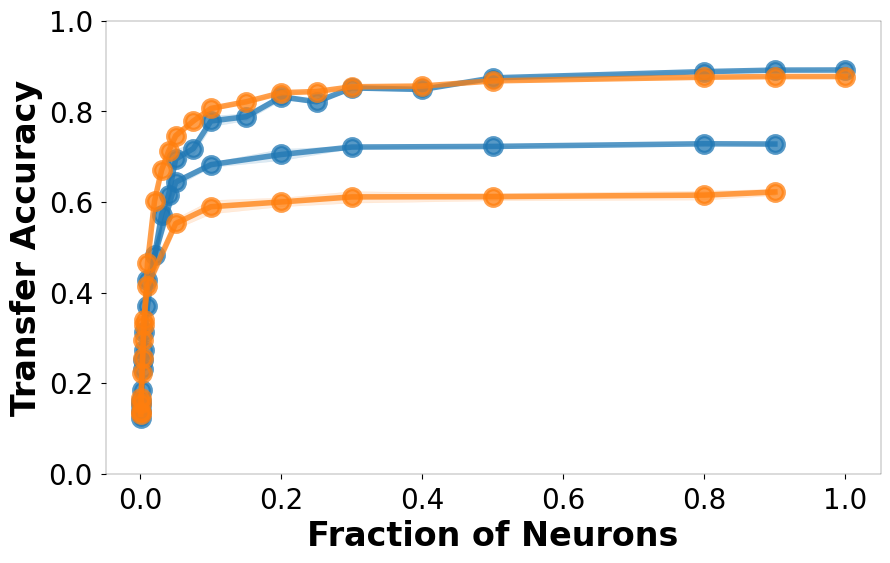

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0293],
        [0.0092],
        [0.0327],
        ...,
        [0.0364],
        [0.0066],
        [0.0316]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=100, bias=True))]), 'num_neurons': 1, 'in_features': 1, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0237],
        [0.0259],
        [0.0182],
        ...,
        [0.0135],
        [0.0308],
        [0.0183]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=100, bias=True))]), 'num_neurons': 1, 'in_features': 1, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0002],
        [0.0080],
        [0.0066],
        ...,
        [0.0318],
        [0.0235],
        [0.0114]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=100, bias=True))]), 'num_neurons': 1, 'in_features': 1, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0293, 0.0107],
        [0.0092, 0.0312],
        [0.0327, 0.0087],
        ...,
        [0.0364, 0.0297],
        [0.0066, 0.0059],
        [0.0316, 0.0325]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=2, out_features=100, bias=True))]), 'num_neurons': 2, 'in_features': 2, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0237, 0.0147],
        [0.0259, 0.0166],
        [0.0182, 0.0379],
        ...,
        [0.0135, 0.0363],
        [0.0308, 0.0034],
        [0.0183, 0.0086]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=2, out_features=100, bias=True))]), 'num_neurons': 2, 'in_features': 2, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0002, 0.0040],
        [0.0080, 0.0216],
        [0.0066, 0.0195],
        ...,
        [0.0318, 0.0316],
        [0.0235, 0.0020],
        [0.0114, 0.0307]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=2, out_features=100, bias=True))]), 'num_neurons': 2, 'in_features': 2, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0293, 0.0107, 0.0154,  ..., 0.0282, 0.0217, 0.0167],
        [0.0092, 0.0312, 0.0360,  ..., 0.0061, 0.0263, 0.0285],
        [0.0327, 0.0087, 0.0024,  ..., 0.0358, 0.0185, 0.0114],
        ...,
        [0.0364, 0.0297, 0.0368,  ..., 0.0301, 0.0206, 0.0141],
        [0.0066, 0.0059, 0.0168,  ..., 0.0306, 0.0300, 0.0137],
        [0.0316, 0.0325, 0.0240,  ..., 0.0268, 0.0371, 0.0273]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=10, out_features=100, bias=True))]), 'num_neurons': 10, 'in_features': 10, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0237, 0.0147, 0.0247,  ..., 0.0036, 0.0233, 0.0022],
        [0.0259, 0.0166, 0.0207,  ..., 0.0288, 0.0055, 0.0107],
        [0.0182, 0.0379, 0.0208,  ..., 0.0281, 0.0233, 0.0351],
        ...,
        [0.0135, 0.0363, 0.0187,  ..., 0.0207, 0.0165, 0.0339],
        [0.0308, 0.0034, 0.0073,  ..., 0.0107, 0.0183, 0.0165],
        [0.0183, 0.0086, 0.0305,  ..., 0.0292, 0.0325, 0.0226]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=10, out_features=100, bias=True))]), 'num_neurons': 10, 'in_features': 10, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0002, 0.0040, 0.0110,  ..., 0.0285, 0.0229, 0.0333],
        [0.0080, 0.0216, 0.0208,  ..., 0.0231, 0.0242, 0.0344],
        [0.0066, 0.0195, 0.0333,  ..., 0.0203, 0.0087, 0.0076],
        ...,
        [0.0318, 0.0316, 0.0314,  ..., 0.0128, 0.0191, 0.0040],
        [0.0235, 0.0020, 0.0176,  ..., 0.0106, 0.0372, 0.0259],
        [0.0114, 0.0307, 0.0021,  ..., 0.0274, 0.0280, 0.0313]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=10, out_features=100, bias=True))]), 'num_neurons': 10, 'in_features': 10, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0293, 0.0107, 0.0154,  ..., 0.0190, 0.0356, 0.0251],
        [0.0092, 0.0312, 0.0360,  ..., 0.0186, 0.0359, 0.0336],
        [0.0327, 0.0087, 0.0024,  ..., 0.0059, 0.0310, 0.0329],
        ...,
        [0.0364, 0.0297, 0.0368,  ..., 0.0094, 0.0038, 0.0323],
        [0.0066, 0.0059, 0.0168,  ..., 0.0359, 0.0350, 0.0369],
        [0.0316, 0.0325, 0.0240,  ..., 0.0085, 0.0256, 0.0127]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=20, out_features=100, bias=True))]), 'num_neurons': 20, 'in_features': 20, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0237, 0.0147, 0.0247,  ..., 0.0080, 0.0119, 0.0383],
        [0.0259, 0.0166, 0.0207,  ..., 0.0301, 0.0183, 0.0238],
        [0.0182, 0.0379, 0.0208,  ..., 0.0186, 0.0304, 0.0287],
        ...,
        [0.0135, 0.0363, 0.0187,  ..., 0.0152, 0.0053, 0.0070],
        [0.0308, 0.0034, 0.0073,  ..., 0.0302, 0.0018, 0.0185],
        [0.0183, 0.0086, 0.0305,  ..., 0.0326, 0.0316, 0.0097]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=20, out_features=100, bias=True))]), 'num_neurons': 20, 'in_features': 20, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0002, 0.0040, 0.0110,  ..., 0.0369, 0.0320, 0.0332],
        [0.0080, 0.0216, 0.0208,  ..., 0.0130, 0.0220, 0.0108],
        [0.0066, 0.0195, 0.0333,  ..., 0.0226, 0.0099, 0.0352],
        ...,
        [0.0318, 0.0316, 0.0314,  ..., 0.0201, 0.0034, 0.0083],
        [0.0235, 0.0020, 0.0176,  ..., 0.0246, 0.0103, 0.0047],
        [0.0114, 0.0307, 0.0021,  ..., 0.0145, 0.0154, 0.0072]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=20, out_features=100, bias=True))]), 'num_neurons': 20, 'in_features': 20, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0293, 0.0107, 0.0154,  ..., 0.0133, 0.0367, 0.0156],
        [0.0092, 0.0312, 0.0360,  ..., 0.0365, 0.0281, 0.0273],
        [0.0327, 0.0087, 0.0024,  ..., 0.0351, 0.0139, 0.0225],
        ...,
        [0.0364, 0.0297, 0.0368,  ..., 0.0002, 0.0188, 0.0039],
        [0.0066, 0.0059, 0.0168,  ..., 0.0213, 0.0050, 0.0259],
        [0.0316, 0.0325, 0.0240,  ..., 0.0077, 0.0032, 0.0136]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=102, out_features=100, bias=True))]), 'num_neurons': 102, 'in_features': 102, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0237, 0.0147, 0.0247,  ..., 0.0129, 0.0122, 0.0161],
        [0.0259, 0.0166, 0.0207,  ..., 0.0199, 0.0330, 0.0291],
        [0.0182, 0.0379, 0.0208,  ..., 0.0300, 0.0339, 0.0076],
        ...,
        [0.0135, 0.0363, 0.0187,  ..., 0.0074, 0.0123, 0.0245],
        [0.0308, 0.0034, 0.0073,  ..., 0.0120, 0.0380, 0.0271],
        [0.0183, 0.0086, 0.0305,  ..., 0.0190, 0.0276, 0.0226]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=102, out_features=100, bias=True))]), 'num_neurons': 102, 'in_features': 102, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0002, 0.0040, 0.0110,  ..., 0.0097, 0.0223, 0.0270],
        [0.0080, 0.0216, 0.0208,  ..., 0.0084, 0.0101, 0.0088],
        [0.0066, 0.0195, 0.0333,  ..., 0.0253, 0.0238, 0.0161],
        ...,
        [0.0318, 0.0316, 0.0314,  ..., 0.0180, 0.0277, 0.0311],
        [0.0235, 0.0020, 0.0176,  ..., 0.0380, 0.0241, 0.0220],
        [0.0114, 0.0307, 0.0021,  ..., 0.0367, 0.0165, 0.0123]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=102, out_features=100, bias=True))]), 'num_neurons': 102, 'in_features': 102, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0293, 0.0107, 0.0154,  ..., 0.0050, 0.0351, 0.0116],
        [0.0092, 0.0312, 0.0360,  ..., 0.0061, 0.0307, 0.0281],
        [0.0327, 0.0087, 0.0024,  ..., 0.0374, 0.0237, 0.0074],
        ...,
        [0.0364, 0.0297, 0.0368,  ..., 0.0231, 0.0144, 0.0156],
        [0.0066, 0.0059, 0.0168,  ..., 0.0354, 0.0191, 0.0047],
        [0.0316, 0.0325, 0.0240,  ..., 0.0038, 0.0319, 0.0265]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=204, out_features=100, bias=True))]), 'num_neurons': 204, 'in_features': 204, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0237, 0.0147, 0.0247,  ..., 0.0071, 0.0111, 0.0028],
        [0.0259, 0.0166, 0.0207,  ..., 0.0149, 0.0029, 0.0364],
        [0.0182, 0.0379, 0.0208,  ..., 0.0254, 0.0253, 0.0027],
        ...,
        [0.0135, 0.0363, 0.0187,  ..., 0.0327, 0.0244, 0.0027],
        [0.0308, 0.0034, 0.0073,  ..., 0.0323, 0.0115, 0.0159],
        [0.0183, 0.0086, 0.0305,  ..., 0.0300, 0.0069, 0.0267]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=204, out_features=100, bias=True))]), 'num_neurons': 204, 'in_features': 204, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[2.9297e-02, 1.0726e-02, 1.5391e-02,  ..., 9.3566e-03, 5.5641e-03,
         3.2455e-02],
        [9.2465e-03, 3.1238e-02, 3.6019e-02,  ..., 6.4606e-03, 3.7757e-02,
         2.7041e-02],
        [3.2742e-02, 8.7411e-03, 2.3545e-03,  ..., 1.1711e-02, 3.0374e-02,
         1.3710e-02],
        ...,
        [3.6448e-02, 2.9718e-02, 3.6840e-02,  ..., 1.1693e-02, 6.9777e-05,
         3.4326e-02],
        [6.5958e-03, 5.8966e-03, 1.6845e-02,  ..., 2.4715e-02, 7.5857e-03,
         2.1349e-02],
        [3.1606e-02, 3.2466e-02, 2.4011e-02,  ..., 1.4379e-02, 1.8828e-03,
         1.8098e-02]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules'

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0237, 0.0147, 0.0247,  ..., 0.0074, 0.0019, 0.0368],
        [0.0259, 0.0166, 0.0207,  ..., 0.0287, 0.0281, 0.0169],
        [0.0182, 0.0379, 0.0208,  ..., 0.0221, 0.0018, 0.0113],
        ...,
        [0.0135, 0.0363, 0.0187,  ..., 0.0083, 0.0181, 0.0270],
        [0.0308, 0.0034, 0.0073,  ..., 0.0095, 0.0301, 0.0162],
        [0.0183, 0.0086, 0.0305,  ..., 0.0255, 0.0292, 0.0221]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=409, out_features=100, bias=True))]), 'num_neurons': 409, 'in_features': 409, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0293, 0.0107, 0.0154,  ..., 0.0150, 0.0139, 0.0249],
        [0.0092, 0.0312, 0.0360,  ..., 0.0338, 0.0365, 0.0268],
        [0.0327, 0.0087, 0.0024,  ..., 0.0156, 0.0285, 0.0277],
        ...,
        [0.0364, 0.0297, 0.0368,  ..., 0.0066, 0.0152, 0.0143],
        [0.0066, 0.0059, 0.0168,  ..., 0.0061, 0.0138, 0.0120],
        [0.0316, 0.0325, 0.0240,  ..., 0.0198, 0.0086, 0.0070]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=614, out_features=100, bias=True))]), 'num_neurons': 614, 'in_features': 614, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0237, 0.0147, 0.0247,  ..., 0.0034, 0.0243, 0.0247],
        [0.0259, 0.0166, 0.0207,  ..., 0.0176, 0.0365, 0.0244],
        [0.0182, 0.0379, 0.0208,  ..., 0.0202, 0.0271, 0.0084],
        ...,
        [0.0135, 0.0363, 0.0187,  ..., 0.0202, 0.0013, 0.0184],
        [0.0308, 0.0034, 0.0073,  ..., 0.0121, 0.0274, 0.0190],
        [0.0183, 0.0086, 0.0305,  ..., 0.0307, 0.0221, 0.0266]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=614, out_features=100, bias=True))]), 'num_neurons': 614, 'in_features': 614, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0293, 0.0107, 0.0154,  ..., 0.0187, 0.0130, 0.0071],
        [0.0092, 0.0312, 0.0360,  ..., 0.0157, 0.0263, 0.0095],
        [0.0327, 0.0087, 0.0024,  ..., 0.0356, 0.0087, 0.0038],
        ...,
        [0.0364, 0.0297, 0.0368,  ..., 0.0145, 0.0137, 0.0240],
        [0.0066, 0.0059, 0.0168,  ..., 0.0228, 0.0178, 0.0297],
        [0.0316, 0.0325, 0.0240,  ..., 0.0240, 0.0245, 0.0279]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1024, out_features=100, bias=True))]), 'num_neurons': 1024, 'in_features': 1024, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0237, 0.0147, 0.0247,  ..., 0.0211, 0.0033, 0.0133],
        [0.0259, 0.0166, 0.0207,  ..., 0.0110, 0.0036, 0.0106],
        [0.0182, 0.0379, 0.0208,  ..., 0.0214, 0.0125, 0.0291],
        ...,
        [0.0135, 0.0363, 0.0187,  ..., 0.0109, 0.0372, 0.0319],
        [0.0308, 0.0034, 0.0073,  ..., 0.0320, 0.0087, 0.0187],
        [0.0183, 0.0086, 0.0305,  ..., 0.0269, 0.0097, 0.0097]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1024, out_features=100, bias=True))]), 'num_neurons': 1024, 'in_features': 1024, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0293, 0.0107, 0.0154,  ..., 0.0235, 0.0189, 0.0341],
        [0.0092, 0.0312, 0.0360,  ..., 0.0015, 0.0078, 0.0258],
        [0.0327, 0.0087, 0.0024,  ..., 0.0012, 0.0320, 0.0255],
        ...,
        [0.0364, 0.0297, 0.0368,  ..., 0.0164, 0.0180, 0.0305],
        [0.0066, 0.0059, 0.0168,  ..., 0.0074, 0.0221, 0.0121],
        [0.0316, 0.0325, 0.0240,  ..., 0.0105, 0.0372, 0.0099]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1638, out_features=100, bias=True))]), 'num_neurons': 1638, 'in_features': 1638, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0237, 0.0147, 0.0247,  ..., 0.0339, 0.0127, 0.0115],
        [0.0259, 0.0166, 0.0207,  ..., 0.0224, 0.0329, 0.0158],
        [0.0182, 0.0379, 0.0208,  ..., 0.0316, 0.0210, 0.0051],
        ...,
        [0.0135, 0.0363, 0.0187,  ..., 0.0349, 0.0041, 0.0198],
        [0.0308, 0.0034, 0.0073,  ..., 0.0130, 0.0138, 0.0214],
        [0.0183, 0.0086, 0.0305,  ..., 0.0020, 0.0026, 0.0246]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1638, out_features=100, bias=True))]), 'num_neurons': 1638, 'in_features': 1638, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0293, 0.0107, 0.0154,  ..., 0.0232, 0.0017, 0.0217],
        [0.0092, 0.0312, 0.0360,  ..., 0.0092, 0.0185, 0.0343],
        [0.0327, 0.0087, 0.0024,  ..., 0.0220, 0.0255, 0.0307],
        ...,
        [0.0364, 0.0297, 0.0368,  ..., 0.0088, 0.0218, 0.0140],
        [0.0066, 0.0059, 0.0168,  ..., 0.0239, 0.0337, 0.0281],
        [0.0316, 0.0325, 0.0240,  ..., 0.0188, 0.0016, 0.0312]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1843, out_features=100, bias=True))]), 'num_neurons': 1843, 'in_features': 1843, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0237, 0.0147, 0.0247,  ..., 0.0085, 0.0174, 0.0276],
        [0.0259, 0.0166, 0.0207,  ..., 0.0225, 0.0308, 0.0290],
        [0.0182, 0.0379, 0.0208,  ..., 0.0292, 0.0020, 0.0192],
        ...,
        [0.0135, 0.0363, 0.0187,  ..., 0.0216, 0.0131, 0.0333],
        [0.0308, 0.0034, 0.0073,  ..., 0.0274, 0.0008, 0.0328],
        [0.0183, 0.0086, 0.0305,  ..., 0.0260, 0.0057, 0.0025]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1843, out_features=100, bias=True))]), 'num_neurons': 1843, 'in_features': 1843, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0293],
        [0.0092],
        [0.0327],
        ...,
        [0.0364],
        [0.0066],
        [0.0316]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=100, bias=True))]), 'num_neurons': 1, 'in_features': 1, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0237],
        [0.0259],
        [0.0182],
        ...,
        [0.0135],
        [0.0308],
        [0.0183]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=100, bias=True))]), 'num_neurons': 1, 'in_features': 1, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0002],
        [0.0080],
        [0.0066],
        ...,
        [0.0318],
        [0.0235],
        [0.0114]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=100, bias=True))]), 'num_neurons': 1, 'in_features': 1, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0212],
        [0.0182],
        [0.0019],
        ...,
        [0.0097],
        [0.0347],
        [0.0045]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=100, bias=True))]), 'num_neurons': 1, 'in_features': 1, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0293, 0.0107],
        [0.0092, 0.0312],
        [0.0327, 0.0087],
        ...,
        [0.0364, 0.0297],
        [0.0066, 0.0059],
        [0.0316, 0.0325]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=2, out_features=100, bias=True))]), 'num_neurons': 2, 'in_features': 2, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0237, 0.0147],
        [0.0259, 0.0166],
        [0.0182, 0.0379],
        ...,
        [0.0135, 0.0363],
        [0.0308, 0.0034],
        [0.0183, 0.0086]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=2, out_features=100, bias=True))]), 'num_neurons': 2, 'in_features': 2, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0002, 0.0040],
        [0.0080, 0.0216],
        [0.0066, 0.0195],
        ...,
        [0.0318, 0.0316],
        [0.0235, 0.0020],
        [0.0114, 0.0307]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=2, out_features=100, bias=True))]), 'num_neurons': 2, 'in_features': 2, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0212, 0.0217],
        [0.0182, 0.0004],
        [0.0019, 0.0112],
        ...,
        [0.0097, 0.0055],
        [0.0347, 0.0033],
        [0.0045, 0.0179]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=2, out_features=100, bias=True))]), 'num_neurons': 2, 'in_features': 2, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0293, 0.0107, 0.0154,  ..., 0.0282, 0.0217, 0.0167],
        [0.0092, 0.0312, 0.0360,  ..., 0.0061, 0.0263, 0.0285],
        [0.0327, 0.0087, 0.0024,  ..., 0.0358, 0.0185, 0.0114],
        ...,
        [0.0364, 0.0297, 0.0368,  ..., 0.0301, 0.0206, 0.0141],
        [0.0066, 0.0059, 0.0168,  ..., 0.0306, 0.0300, 0.0137],
        [0.0316, 0.0325, 0.0240,  ..., 0.0268, 0.0371, 0.0273]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=10, out_features=100, bias=True))]), 'num_neurons': 10, 'in_features': 10, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0237, 0.0147, 0.0247,  ..., 0.0036, 0.0233, 0.0022],
        [0.0259, 0.0166, 0.0207,  ..., 0.0288, 0.0055, 0.0107],
        [0.0182, 0.0379, 0.0208,  ..., 0.0281, 0.0233, 0.0351],
        ...,
        [0.0135, 0.0363, 0.0187,  ..., 0.0207, 0.0165, 0.0339],
        [0.0308, 0.0034, 0.0073,  ..., 0.0107, 0.0183, 0.0165],
        [0.0183, 0.0086, 0.0305,  ..., 0.0292, 0.0325, 0.0226]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=10, out_features=100, bias=True))]), 'num_neurons': 10, 'in_features': 10, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0002, 0.0040, 0.0110,  ..., 0.0285, 0.0229, 0.0333],
        [0.0080, 0.0216, 0.0208,  ..., 0.0231, 0.0242, 0.0344],
        [0.0066, 0.0195, 0.0333,  ..., 0.0203, 0.0087, 0.0076],
        ...,
        [0.0318, 0.0316, 0.0314,  ..., 0.0128, 0.0191, 0.0040],
        [0.0235, 0.0020, 0.0176,  ..., 0.0106, 0.0372, 0.0259],
        [0.0114, 0.0307, 0.0021,  ..., 0.0274, 0.0280, 0.0313]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=10, out_features=100, bias=True))]), 'num_neurons': 10, 'in_features': 10, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0212, 0.0217, 0.0035,  ..., 0.0352, 0.0240, 0.0376],
        [0.0182, 0.0004, 0.0350,  ..., 0.0122, 0.0038, 0.0117],
        [0.0019, 0.0112, 0.0323,  ..., 0.0344, 0.0048, 0.0346],
        ...,
        [0.0097, 0.0055, 0.0274,  ..., 0.0083, 0.0224, 0.0382],
        [0.0347, 0.0033, 0.0186,  ..., 0.0082, 0.0169, 0.0161],
        [0.0045, 0.0179, 0.0291,  ..., 0.0192, 0.0191, 0.0207]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=10, out_features=100, bias=True))]), 'num_neurons': 10, 'in_features': 10, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0293, 0.0107, 0.0154,  ..., 0.0190, 0.0356, 0.0251],
        [0.0092, 0.0312, 0.0360,  ..., 0.0186, 0.0359, 0.0336],
        [0.0327, 0.0087, 0.0024,  ..., 0.0059, 0.0310, 0.0329],
        ...,
        [0.0364, 0.0297, 0.0368,  ..., 0.0094, 0.0038, 0.0323],
        [0.0066, 0.0059, 0.0168,  ..., 0.0359, 0.0350, 0.0369],
        [0.0316, 0.0325, 0.0240,  ..., 0.0085, 0.0256, 0.0127]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=20, out_features=100, bias=True))]), 'num_neurons': 20, 'in_features': 20, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0237, 0.0147, 0.0247,  ..., 0.0080, 0.0119, 0.0383],
        [0.0259, 0.0166, 0.0207,  ..., 0.0301, 0.0183, 0.0238],
        [0.0182, 0.0379, 0.0208,  ..., 0.0186, 0.0304, 0.0287],
        ...,
        [0.0135, 0.0363, 0.0187,  ..., 0.0152, 0.0053, 0.0070],
        [0.0308, 0.0034, 0.0073,  ..., 0.0302, 0.0018, 0.0185],
        [0.0183, 0.0086, 0.0305,  ..., 0.0326, 0.0316, 0.0097]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=20, out_features=100, bias=True))]), 'num_neurons': 20, 'in_features': 20, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0002, 0.0040, 0.0110,  ..., 0.0369, 0.0320, 0.0332],
        [0.0080, 0.0216, 0.0208,  ..., 0.0130, 0.0220, 0.0108],
        [0.0066, 0.0195, 0.0333,  ..., 0.0226, 0.0099, 0.0352],
        ...,
        [0.0318, 0.0316, 0.0314,  ..., 0.0201, 0.0034, 0.0083],
        [0.0235, 0.0020, 0.0176,  ..., 0.0246, 0.0103, 0.0047],
        [0.0114, 0.0307, 0.0021,  ..., 0.0145, 0.0154, 0.0072]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=20, out_features=100, bias=True))]), 'num_neurons': 20, 'in_features': 20, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0212, 0.0217, 0.0035,  ..., 0.0083, 0.0117, 0.0015],
        [0.0182, 0.0004, 0.0350,  ..., 0.0266, 0.0333, 0.0358],
        [0.0019, 0.0112, 0.0323,  ..., 0.0384, 0.0083, 0.0380],
        ...,
        [0.0097, 0.0055, 0.0274,  ..., 0.0257, 0.0005, 0.0058],
        [0.0347, 0.0033, 0.0186,  ..., 0.0114, 0.0024, 0.0210],
        [0.0045, 0.0179, 0.0291,  ..., 0.0354, 0.0036, 0.0130]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=20, out_features=100, bias=True))]), 'num_neurons': 20, 'in_features': 20, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0293, 0.0107, 0.0154,  ..., 0.0133, 0.0367, 0.0156],
        [0.0092, 0.0312, 0.0360,  ..., 0.0365, 0.0281, 0.0273],
        [0.0327, 0.0087, 0.0024,  ..., 0.0351, 0.0139, 0.0225],
        ...,
        [0.0364, 0.0297, 0.0368,  ..., 0.0002, 0.0188, 0.0039],
        [0.0066, 0.0059, 0.0168,  ..., 0.0213, 0.0050, 0.0259],
        [0.0316, 0.0325, 0.0240,  ..., 0.0077, 0.0032, 0.0136]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=102, out_features=100, bias=True))]), 'num_neurons': 102, 'in_features': 102, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0237, 0.0147, 0.0247,  ..., 0.0129, 0.0122, 0.0161],
        [0.0259, 0.0166, 0.0207,  ..., 0.0199, 0.0330, 0.0291],
        [0.0182, 0.0379, 0.0208,  ..., 0.0300, 0.0339, 0.0076],
        ...,
        [0.0135, 0.0363, 0.0187,  ..., 0.0074, 0.0123, 0.0245],
        [0.0308, 0.0034, 0.0073,  ..., 0.0120, 0.0380, 0.0271],
        [0.0183, 0.0086, 0.0305,  ..., 0.0190, 0.0276, 0.0226]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=102, out_features=100, bias=True))]), 'num_neurons': 102, 'in_features': 102, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0002, 0.0040, 0.0110,  ..., 0.0097, 0.0223, 0.0270],
        [0.0080, 0.0216, 0.0208,  ..., 0.0084, 0.0101, 0.0088],
        [0.0066, 0.0195, 0.0333,  ..., 0.0253, 0.0238, 0.0161],
        ...,
        [0.0318, 0.0316, 0.0314,  ..., 0.0180, 0.0277, 0.0311],
        [0.0235, 0.0020, 0.0176,  ..., 0.0380, 0.0241, 0.0220],
        [0.0114, 0.0307, 0.0021,  ..., 0.0367, 0.0165, 0.0123]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=102, out_features=100, bias=True))]), 'num_neurons': 102, 'in_features': 102, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0212, 0.0217, 0.0035,  ..., 0.0053, 0.0095, 0.0354],
        [0.0182, 0.0004, 0.0350,  ..., 0.0128, 0.0109, 0.0342],
        [0.0019, 0.0112, 0.0323,  ..., 0.0292, 0.0367, 0.0273],
        ...,
        [0.0097, 0.0055, 0.0274,  ..., 0.0151, 0.0077, 0.0232],
        [0.0347, 0.0033, 0.0186,  ..., 0.0288, 0.0320, 0.0210],
        [0.0045, 0.0179, 0.0291,  ..., 0.0333, 0.0304, 0.0359]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=102, out_features=100, bias=True))]), 'num_neurons': 102, 'in_features': 102, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0293, 0.0107, 0.0154,  ..., 0.0050, 0.0351, 0.0116],
        [0.0092, 0.0312, 0.0360,  ..., 0.0061, 0.0307, 0.0281],
        [0.0327, 0.0087, 0.0024,  ..., 0.0374, 0.0237, 0.0074],
        ...,
        [0.0364, 0.0297, 0.0368,  ..., 0.0231, 0.0144, 0.0156],
        [0.0066, 0.0059, 0.0168,  ..., 0.0354, 0.0191, 0.0047],
        [0.0316, 0.0325, 0.0240,  ..., 0.0038, 0.0319, 0.0265]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=204, out_features=100, bias=True))]), 'num_neurons': 204, 'in_features': 204, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0237, 0.0147, 0.0247,  ..., 0.0071, 0.0111, 0.0028],
        [0.0259, 0.0166, 0.0207,  ..., 0.0149, 0.0029, 0.0364],
        [0.0182, 0.0379, 0.0208,  ..., 0.0254, 0.0253, 0.0027],
        ...,
        [0.0135, 0.0363, 0.0187,  ..., 0.0327, 0.0244, 0.0027],
        [0.0308, 0.0034, 0.0073,  ..., 0.0323, 0.0115, 0.0159],
        [0.0183, 0.0086, 0.0305,  ..., 0.0300, 0.0069, 0.0267]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=204, out_features=100, bias=True))]), 'num_neurons': 204, 'in_features': 204, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0002, 0.0040, 0.0110,  ..., 0.0315, 0.0298, 0.0361],
        [0.0080, 0.0216, 0.0208,  ..., 0.0080, 0.0197, 0.0249],
        [0.0066, 0.0195, 0.0333,  ..., 0.0325, 0.0247, 0.0067],
        ...,
        [0.0318, 0.0316, 0.0314,  ..., 0.0133, 0.0363, 0.0153],
        [0.0235, 0.0020, 0.0176,  ..., 0.0027, 0.0060, 0.0220],
        [0.0114, 0.0307, 0.0021,  ..., 0.0026, 0.0065, 0.0074]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=204, out_features=100, bias=True))]), 'num_neurons': 204, 'in_features': 204, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0212, 0.0217, 0.0035,  ..., 0.0020, 0.0225, 0.0305],
        [0.0182, 0.0004, 0.0350,  ..., 0.0345, 0.0147, 0.0361],
        [0.0019, 0.0112, 0.0323,  ..., 0.0088, 0.0139, 0.0239],
        ...,
        [0.0097, 0.0055, 0.0274,  ..., 0.0151, 0.0222, 0.0361],
        [0.0347, 0.0033, 0.0186,  ..., 0.0287, 0.0029, 0.0244],
        [0.0045, 0.0179, 0.0291,  ..., 0.0369, 0.0239, 0.0222]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=204, out_features=100, bias=True))]), 'num_neurons': 204, 'in_features': 204, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[2.9297e-02, 1.0726e-02, 1.5391e-02,  ..., 9.3566e-03, 5.5641e-03,
         3.2455e-02],
        [9.2465e-03, 3.1238e-02, 3.6019e-02,  ..., 6.4606e-03, 3.7757e-02,
         2.7041e-02],
        [3.2742e-02, 8.7411e-03, 2.3545e-03,  ..., 1.1711e-02, 3.0374e-02,
         1.3710e-02],
        ...,
        [3.6448e-02, 2.9718e-02, 3.6840e-02,  ..., 1.1693e-02, 6.9777e-05,
         3.4326e-02],
        [6.5958e-03, 5.8966e-03, 1.6845e-02,  ..., 2.4715e-02, 7.5857e-03,
         2.1349e-02],
        [3.1606e-02, 3.2466e-02, 2.4011e-02,  ..., 1.4379e-02, 1.8828e-03,
         1.8098e-02]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules'

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0237, 0.0147, 0.0247,  ..., 0.0074, 0.0019, 0.0368],
        [0.0259, 0.0166, 0.0207,  ..., 0.0287, 0.0281, 0.0169],
        [0.0182, 0.0379, 0.0208,  ..., 0.0221, 0.0018, 0.0113],
        ...,
        [0.0135, 0.0363, 0.0187,  ..., 0.0083, 0.0181, 0.0270],
        [0.0308, 0.0034, 0.0073,  ..., 0.0095, 0.0301, 0.0162],
        [0.0183, 0.0086, 0.0305,  ..., 0.0255, 0.0292, 0.0221]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=409, out_features=100, bias=True))]), 'num_neurons': 409, 'in_features': 409, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0002, 0.0040, 0.0110,  ..., 0.0132, 0.0079, 0.0017],
        [0.0080, 0.0216, 0.0208,  ..., 0.0221, 0.0081, 0.0348],
        [0.0066, 0.0195, 0.0333,  ..., 0.0185, 0.0106, 0.0206],
        ...,
        [0.0318, 0.0316, 0.0314,  ..., 0.0155, 0.0141, 0.0143],
        [0.0235, 0.0020, 0.0176,  ..., 0.0371, 0.0330, 0.0281],
        [0.0114, 0.0307, 0.0021,  ..., 0.0039, 0.0009, 0.0119]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=409, out_features=100, bias=True))]), 'num_neurons': 409, 'in_features': 409, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0212, 0.0217, 0.0035,  ..., 0.0316, 0.0187, 0.0256],
        [0.0182, 0.0004, 0.0350,  ..., 0.0191, 0.0177, 0.0346],
        [0.0019, 0.0112, 0.0323,  ..., 0.0022, 0.0197, 0.0364],
        ...,
        [0.0097, 0.0055, 0.0274,  ..., 0.0194, 0.0274, 0.0343],
        [0.0347, 0.0033, 0.0186,  ..., 0.0021, 0.0157, 0.0042],
        [0.0045, 0.0179, 0.0291,  ..., 0.0224, 0.0129, 0.0105]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=409, out_features=100, bias=True))]), 'num_neurons': 409, 'in_features': 409, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0293, 0.0107, 0.0154,  ..., 0.0150, 0.0139, 0.0249],
        [0.0092, 0.0312, 0.0360,  ..., 0.0338, 0.0365, 0.0268],
        [0.0327, 0.0087, 0.0024,  ..., 0.0156, 0.0285, 0.0277],
        ...,
        [0.0364, 0.0297, 0.0368,  ..., 0.0066, 0.0152, 0.0143],
        [0.0066, 0.0059, 0.0168,  ..., 0.0061, 0.0138, 0.0120],
        [0.0316, 0.0325, 0.0240,  ..., 0.0198, 0.0086, 0.0070]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=614, out_features=100, bias=True))]), 'num_neurons': 614, 'in_features': 614, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0237, 0.0147, 0.0247,  ..., 0.0034, 0.0243, 0.0247],
        [0.0259, 0.0166, 0.0207,  ..., 0.0176, 0.0365, 0.0244],
        [0.0182, 0.0379, 0.0208,  ..., 0.0202, 0.0271, 0.0084],
        ...,
        [0.0135, 0.0363, 0.0187,  ..., 0.0202, 0.0013, 0.0184],
        [0.0308, 0.0034, 0.0073,  ..., 0.0121, 0.0274, 0.0190],
        [0.0183, 0.0086, 0.0305,  ..., 0.0307, 0.0221, 0.0266]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=614, out_features=100, bias=True))]), 'num_neurons': 614, 'in_features': 614, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0002, 0.0040, 0.0110,  ..., 0.0115, 0.0265, 0.0153],
        [0.0080, 0.0216, 0.0208,  ..., 0.0156, 0.0036, 0.0050],
        [0.0066, 0.0195, 0.0333,  ..., 0.0333, 0.0141, 0.0136],
        ...,
        [0.0318, 0.0316, 0.0314,  ..., 0.0103, 0.0304, 0.0136],
        [0.0235, 0.0020, 0.0176,  ..., 0.0159, 0.0236, 0.0263],
        [0.0114, 0.0307, 0.0021,  ..., 0.0309, 0.0372, 0.0258]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=614, out_features=100, bias=True))]), 'num_neurons': 614, 'in_features': 614, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0212, 0.0217, 0.0035,  ..., 0.0227, 0.0180, 0.0357],
        [0.0182, 0.0004, 0.0350,  ..., 0.0203, 0.0346, 0.0136],
        [0.0019, 0.0112, 0.0323,  ..., 0.0247, 0.0230, 0.0289],
        ...,
        [0.0097, 0.0055, 0.0274,  ..., 0.0142, 0.0120, 0.0285],
        [0.0347, 0.0033, 0.0186,  ..., 0.0022, 0.0115, 0.0276],
        [0.0045, 0.0179, 0.0291,  ..., 0.0198, 0.0326, 0.0330]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=614, out_features=100, bias=True))]), 'num_neurons': 614, 'in_features': 614, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0293, 0.0107, 0.0154,  ..., 0.0187, 0.0130, 0.0071],
        [0.0092, 0.0312, 0.0360,  ..., 0.0157, 0.0263, 0.0095],
        [0.0327, 0.0087, 0.0024,  ..., 0.0356, 0.0087, 0.0038],
        ...,
        [0.0364, 0.0297, 0.0368,  ..., 0.0145, 0.0137, 0.0240],
        [0.0066, 0.0059, 0.0168,  ..., 0.0228, 0.0178, 0.0297],
        [0.0316, 0.0325, 0.0240,  ..., 0.0240, 0.0245, 0.0279]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1024, out_features=100, bias=True))]), 'num_neurons': 1024, 'in_features': 1024, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0237, 0.0147, 0.0247,  ..., 0.0211, 0.0033, 0.0133],
        [0.0259, 0.0166, 0.0207,  ..., 0.0110, 0.0036, 0.0106],
        [0.0182, 0.0379, 0.0208,  ..., 0.0214, 0.0125, 0.0291],
        ...,
        [0.0135, 0.0363, 0.0187,  ..., 0.0109, 0.0372, 0.0319],
        [0.0308, 0.0034, 0.0073,  ..., 0.0320, 0.0087, 0.0187],
        [0.0183, 0.0086, 0.0305,  ..., 0.0269, 0.0097, 0.0097]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1024, out_features=100, bias=True))]), 'num_neurons': 1024, 'in_features': 1024, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0002, 0.0040, 0.0110,  ..., 0.0148, 0.0241, 0.0101],
        [0.0080, 0.0216, 0.0208,  ..., 0.0367, 0.0005, 0.0321],
        [0.0066, 0.0195, 0.0333,  ..., 0.0098, 0.0293, 0.0012],
        ...,
        [0.0318, 0.0316, 0.0314,  ..., 0.0277, 0.0065, 0.0099],
        [0.0235, 0.0020, 0.0176,  ..., 0.0137, 0.0184, 0.0083],
        [0.0114, 0.0307, 0.0021,  ..., 0.0065, 0.0333, 0.0124]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1024, out_features=100, bias=True))]), 'num_neurons': 1024, 'in_features': 1024, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0293, 0.0107, 0.0154,  ..., 0.0235, 0.0189, 0.0341],
        [0.0092, 0.0312, 0.0360,  ..., 0.0015, 0.0078, 0.0258],
        [0.0327, 0.0087, 0.0024,  ..., 0.0012, 0.0320, 0.0255],
        ...,
        [0.0364, 0.0297, 0.0368,  ..., 0.0164, 0.0180, 0.0305],
        [0.0066, 0.0059, 0.0168,  ..., 0.0074, 0.0221, 0.0121],
        [0.0316, 0.0325, 0.0240,  ..., 0.0105, 0.0372, 0.0099]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1638, out_features=100, bias=True))]), 'num_neurons': 1638, 'in_features': 1638, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0237, 0.0147, 0.0247,  ..., 0.0339, 0.0127, 0.0115],
        [0.0259, 0.0166, 0.0207,  ..., 0.0224, 0.0329, 0.0158],
        [0.0182, 0.0379, 0.0208,  ..., 0.0316, 0.0210, 0.0051],
        ...,
        [0.0135, 0.0363, 0.0187,  ..., 0.0349, 0.0041, 0.0198],
        [0.0308, 0.0034, 0.0073,  ..., 0.0130, 0.0138, 0.0214],
        [0.0183, 0.0086, 0.0305,  ..., 0.0020, 0.0026, 0.0246]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1638, out_features=100, bias=True))]), 'num_neurons': 1638, 'in_features': 1638, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0002, 0.0040, 0.0110,  ..., 0.0119, 0.0375, 0.0179],
        [0.0080, 0.0216, 0.0208,  ..., 0.0326, 0.0116, 0.0155],
        [0.0066, 0.0195, 0.0333,  ..., 0.0062, 0.0294, 0.0158],
        ...,
        [0.0318, 0.0316, 0.0314,  ..., 0.0300, 0.0187, 0.0268],
        [0.0235, 0.0020, 0.0176,  ..., 0.0351, 0.0040, 0.0090],
        [0.0114, 0.0307, 0.0021,  ..., 0.0066, 0.0242, 0.0296]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1638, out_features=100, bias=True))]), 'num_neurons': 1638, 'in_features': 1638, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0293, 0.0107, 0.0154,  ..., 0.0232, 0.0017, 0.0217],
        [0.0092, 0.0312, 0.0360,  ..., 0.0092, 0.0185, 0.0343],
        [0.0327, 0.0087, 0.0024,  ..., 0.0220, 0.0255, 0.0307],
        ...,
        [0.0364, 0.0297, 0.0368,  ..., 0.0088, 0.0218, 0.0140],
        [0.0066, 0.0059, 0.0168,  ..., 0.0239, 0.0337, 0.0281],
        [0.0316, 0.0325, 0.0240,  ..., 0.0188, 0.0016, 0.0312]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1843, out_features=100, bias=True))]), 'num_neurons': 1843, 'in_features': 1843, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0237, 0.0147, 0.0247,  ..., 0.0085, 0.0174, 0.0276],
        [0.0259, 0.0166, 0.0207,  ..., 0.0225, 0.0308, 0.0290],
        [0.0182, 0.0379, 0.0208,  ..., 0.0292, 0.0020, 0.0192],
        ...,
        [0.0135, 0.0363, 0.0187,  ..., 0.0216, 0.0131, 0.0333],
        [0.0308, 0.0034, 0.0073,  ..., 0.0274, 0.0008, 0.0328],
        [0.0183, 0.0086, 0.0305,  ..., 0.0260, 0.0057, 0.0025]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1843, out_features=100, bias=True))]), 'num_neurons': 1843, 'in_features': 1843, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[1.6364e-04, 4.0469e-03, 1.1049e-02,  ..., 1.3039e-02, 1.2401e-02,
         3.6576e-02],
        [7.9523e-03, 2.1579e-02, 2.0770e-02,  ..., 1.6732e-02, 7.4345e-03,
         1.5582e-02],
        [6.5652e-03, 1.9527e-02, 3.3286e-02,  ..., 3.2518e-02, 3.5044e-02,
         9.6515e-03],
        ...,
        [3.1779e-02, 3.1634e-02, 3.1350e-02,  ..., 6.7258e-03, 1.9493e-02,
         1.9070e-02],
        [2.3496e-02, 1.9626e-03, 1.7631e-02,  ..., 1.8468e-02, 7.1234e-05,
         3.6016e-02],
        [1.1356e-02, 3.0729e-02, 2.1142e-03,  ..., 3.1660e-02, 3.5862e-02,
         3.1412e-03]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules'

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

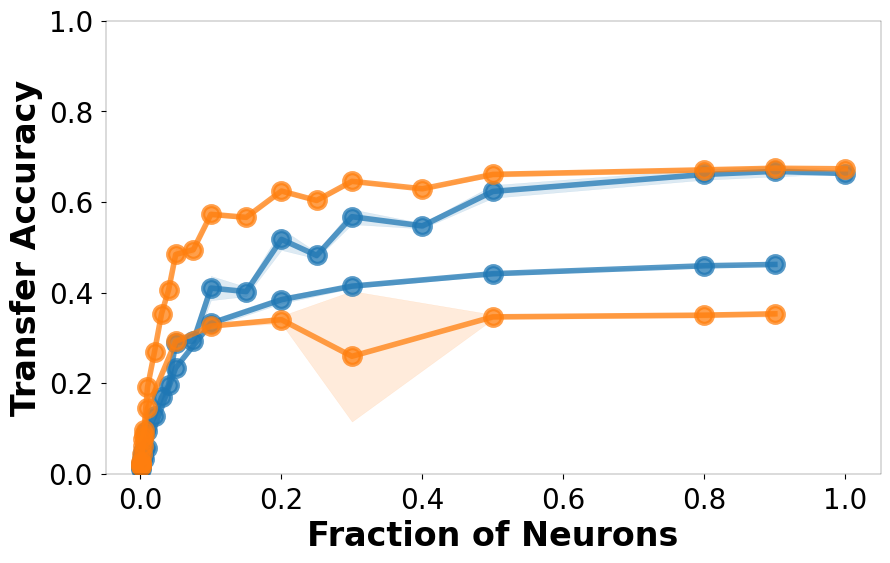

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0293],
        [0.0092],
        [0.0327],
        ...,
        [0.0364],
        [0.0066],
        [0.0316]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=102, bias=True))]), 'num_neurons': 1, 'in_features': 1, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0237],
        [0.0259],
        [0.0182],
        ...,
        [0.0135],
        [0.0308],
        [0.0183]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=102, bias=True))]), 'num_neurons': 1, 'in_features': 1, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0002],
        [0.0080],
        [0.0066],
        ...,
        [0.0318],
        [0.0235],
        [0.0114]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=102, bias=True))]), 'num_neurons': 1, 'in_features': 1, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0212],
        [0.0182],
        [0.0019],
        ...,
        [0.0097],
        [0.0347],
        [0.0045]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=102, bias=True))]), 'num_neurons': 1, 'in_features': 1, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0319],
        [0.0135],
        [0.0241],
        ...,
        [0.0261],
        [0.0365],
        [0.0142]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=102, bias=True))]), 'num_neurons': 1, 'in_features': 1, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0293, 0.0107],
        [0.0092, 0.0312],
        [0.0327, 0.0087],
        ...,
        [0.0364, 0.0297],
        [0.0066, 0.0059],
        [0.0316, 0.0325]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=2, out_features=102, bias=True))]), 'num_neurons': 2, 'in_features': 2, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0237, 0.0147],
        [0.0259, 0.0166],
        [0.0182, 0.0379],
        ...,
        [0.0135, 0.0363],
        [0.0308, 0.0034],
        [0.0183, 0.0086]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=2, out_features=102, bias=True))]), 'num_neurons': 2, 'in_features': 2, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0002, 0.0040],
        [0.0080, 0.0216],
        [0.0066, 0.0195],
        ...,
        [0.0318, 0.0316],
        [0.0235, 0.0020],
        [0.0114, 0.0307]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=2, out_features=102, bias=True))]), 'num_neurons': 2, 'in_features': 2, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0212, 0.0217],
        [0.0182, 0.0004],
        [0.0019, 0.0112],
        ...,
        [0.0097, 0.0055],
        [0.0347, 0.0033],
        [0.0045, 0.0179]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=2, out_features=102, bias=True))]), 'num_neurons': 2, 'in_features': 2, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0319, 0.0048],
        [0.0135, 0.0354],
        [0.0241, 0.0242],
        ...,
        [0.0261, 0.0080],
        [0.0365, 0.0261],
        [0.0142, 0.0321]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=2, out_features=102, bias=True))]), 'num_neurons': 2, 'in_features': 2, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0293, 0.0107, 0.0154,  ..., 0.0282, 0.0217, 0.0167],
        [0.0092, 0.0312, 0.0360,  ..., 0.0061, 0.0263, 0.0285],
        [0.0327, 0.0087, 0.0024,  ..., 0.0358, 0.0185, 0.0114],
        ...,
        [0.0364, 0.0297, 0.0368,  ..., 0.0301, 0.0206, 0.0141],
        [0.0066, 0.0059, 0.0168,  ..., 0.0306, 0.0300, 0.0137],
        [0.0316, 0.0325, 0.0240,  ..., 0.0268, 0.0371, 0.0273]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=10, out_features=102, bias=True))]), 'num_neurons': 10, 'in_features': 10, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0237, 0.0147, 0.0247,  ..., 0.0036, 0.0233, 0.0022],
        [0.0259, 0.0166, 0.0207,  ..., 0.0288, 0.0055, 0.0107],
        [0.0182, 0.0379, 0.0208,  ..., 0.0281, 0.0233, 0.0351],
        ...,
        [0.0135, 0.0363, 0.0187,  ..., 0.0207, 0.0165, 0.0339],
        [0.0308, 0.0034, 0.0073,  ..., 0.0107, 0.0183, 0.0165],
        [0.0183, 0.0086, 0.0305,  ..., 0.0292, 0.0325, 0.0226]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=10, out_features=102, bias=True))]), 'num_neurons': 10, 'in_features': 10, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0002, 0.0040, 0.0110,  ..., 0.0285, 0.0229, 0.0333],
        [0.0080, 0.0216, 0.0208,  ..., 0.0231, 0.0242, 0.0344],
        [0.0066, 0.0195, 0.0333,  ..., 0.0203, 0.0087, 0.0076],
        ...,
        [0.0318, 0.0316, 0.0314,  ..., 0.0128, 0.0191, 0.0040],
        [0.0235, 0.0020, 0.0176,  ..., 0.0106, 0.0372, 0.0259],
        [0.0114, 0.0307, 0.0021,  ..., 0.0274, 0.0280, 0.0313]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=10, out_features=102, bias=True))]), 'num_neurons': 10, 'in_features': 10, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0212, 0.0217, 0.0035,  ..., 0.0352, 0.0240, 0.0376],
        [0.0182, 0.0004, 0.0350,  ..., 0.0122, 0.0038, 0.0117],
        [0.0019, 0.0112, 0.0323,  ..., 0.0344, 0.0048, 0.0346],
        ...,
        [0.0097, 0.0055, 0.0274,  ..., 0.0083, 0.0224, 0.0382],
        [0.0347, 0.0033, 0.0186,  ..., 0.0082, 0.0169, 0.0161],
        [0.0045, 0.0179, 0.0291,  ..., 0.0192, 0.0191, 0.0207]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=10, out_features=102, bias=True))]), 'num_neurons': 10, 'in_features': 10, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0319, 0.0048, 0.0344,  ..., 0.0285, 0.0013, 0.0381],
        [0.0135, 0.0354, 0.0049,  ..., 0.0185, 0.0360, 0.0059],
        [0.0241, 0.0242, 0.0321,  ..., 0.0339, 0.0296, 0.0156],
        ...,
        [0.0261, 0.0080, 0.0176,  ..., 0.0104, 0.0304, 0.0281],
        [0.0365, 0.0261, 0.0331,  ..., 0.0180, 0.0108, 0.0319],
        [0.0142, 0.0321, 0.0103,  ..., 0.0324, 0.0381, 0.0316]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=10, out_features=102, bias=True))]), 'num_neurons': 10, 'in_features': 10, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0293, 0.0107, 0.0154,  ..., 0.0190, 0.0356, 0.0251],
        [0.0092, 0.0312, 0.0360,  ..., 0.0186, 0.0359, 0.0336],
        [0.0327, 0.0087, 0.0024,  ..., 0.0059, 0.0310, 0.0329],
        ...,
        [0.0364, 0.0297, 0.0368,  ..., 0.0094, 0.0038, 0.0323],
        [0.0066, 0.0059, 0.0168,  ..., 0.0359, 0.0350, 0.0369],
        [0.0316, 0.0325, 0.0240,  ..., 0.0085, 0.0256, 0.0127]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=20, out_features=102, bias=True))]), 'num_neurons': 20, 'in_features': 20, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0237, 0.0147, 0.0247,  ..., 0.0080, 0.0119, 0.0383],
        [0.0259, 0.0166, 0.0207,  ..., 0.0301, 0.0183, 0.0238],
        [0.0182, 0.0379, 0.0208,  ..., 0.0186, 0.0304, 0.0287],
        ...,
        [0.0135, 0.0363, 0.0187,  ..., 0.0152, 0.0053, 0.0070],
        [0.0308, 0.0034, 0.0073,  ..., 0.0302, 0.0018, 0.0185],
        [0.0183, 0.0086, 0.0305,  ..., 0.0326, 0.0316, 0.0097]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=20, out_features=102, bias=True))]), 'num_neurons': 20, 'in_features': 20, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0002, 0.0040, 0.0110,  ..., 0.0369, 0.0320, 0.0332],
        [0.0080, 0.0216, 0.0208,  ..., 0.0130, 0.0220, 0.0108],
        [0.0066, 0.0195, 0.0333,  ..., 0.0226, 0.0099, 0.0352],
        ...,
        [0.0318, 0.0316, 0.0314,  ..., 0.0201, 0.0034, 0.0083],
        [0.0235, 0.0020, 0.0176,  ..., 0.0246, 0.0103, 0.0047],
        [0.0114, 0.0307, 0.0021,  ..., 0.0145, 0.0154, 0.0072]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=20, out_features=102, bias=True))]), 'num_neurons': 20, 'in_features': 20, 'out_features': 102}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0212, 0.0217, 0.0035,  ..., 0.0083, 0.0117, 0.0015],
        [0.0182, 0.0004, 0.0350,  ..., 0.0266, 0.0333, 0.0358],
        [0.0019, 0.0112, 0.0323,  ..., 0.0384, 0.0083, 0.0380],
        ...,
        [0.0097, 0.0055, 0.0274,  ..., 0.0257, 0.0005, 0.0058],
        [0.0347, 0.0033, 0.0186,  ..., 0.0114, 0.0024, 0.0210],
        [0.0045, 0.0179, 0.0291,  ..., 0.0354, 0.0036, 0.0130]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=20, out_features=102, bias=True))]), 'num_neurons': 20, 'in_features': 20, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0319, 0.0048, 0.0344,  ..., 0.0243, 0.0022, 0.0358],
        [0.0135, 0.0354, 0.0049,  ..., 0.0249, 0.0295, 0.0001],
        [0.0241, 0.0242, 0.0321,  ..., 0.0007, 0.0380, 0.0348],
        ...,
        [0.0261, 0.0080, 0.0176,  ..., 0.0016, 0.0302, 0.0084],
        [0.0365, 0.0261, 0.0331,  ..., 0.0037, 0.0352, 0.0001],
        [0.0142, 0.0321, 0.0103,  ..., 0.0289, 0.0378, 0.0146]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=20, out_features=102, bias=True))]), 'num_neurons': 20, 'in_features': 20, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0293, 0.0107, 0.0154,  ..., 0.0133, 0.0367, 0.0156],
        [0.0092, 0.0312, 0.0360,  ..., 0.0365, 0.0281, 0.0273],
        [0.0327, 0.0087, 0.0024,  ..., 0.0351, 0.0139, 0.0225],
        ...,
        [0.0364, 0.0297, 0.0368,  ..., 0.0002, 0.0188, 0.0039],
        [0.0066, 0.0059, 0.0168,  ..., 0.0213, 0.0050, 0.0259],
        [0.0316, 0.0325, 0.0240,  ..., 0.0077, 0.0032, 0.0136]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=102, out_features=102, bias=True))]), 'num_neurons': 102, 'in_features': 102, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0237, 0.0147, 0.0247,  ..., 0.0129, 0.0122, 0.0161],
        [0.0259, 0.0166, 0.0207,  ..., 0.0199, 0.0330, 0.0291],
        [0.0182, 0.0379, 0.0208,  ..., 0.0300, 0.0339, 0.0076],
        ...,
        [0.0135, 0.0363, 0.0187,  ..., 0.0074, 0.0123, 0.0245],
        [0.0308, 0.0034, 0.0073,  ..., 0.0120, 0.0380, 0.0271],
        [0.0183, 0.0086, 0.0305,  ..., 0.0190, 0.0276, 0.0226]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=102, out_features=102, bias=True))]), 'num_neurons': 102, 'in_features': 102, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0002, 0.0040, 0.0110,  ..., 0.0097, 0.0223, 0.0270],
        [0.0080, 0.0216, 0.0208,  ..., 0.0084, 0.0101, 0.0088],
        [0.0066, 0.0195, 0.0333,  ..., 0.0253, 0.0238, 0.0161],
        ...,
        [0.0318, 0.0316, 0.0314,  ..., 0.0180, 0.0277, 0.0311],
        [0.0235, 0.0020, 0.0176,  ..., 0.0380, 0.0241, 0.0220],
        [0.0114, 0.0307, 0.0021,  ..., 0.0367, 0.0165, 0.0123]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=102, out_features=102, bias=True))]), 'num_neurons': 102, 'in_features': 102, 'out_features': 102}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0212, 0.0217, 0.0035,  ..., 0.0053, 0.0095, 0.0354],
        [0.0182, 0.0004, 0.0350,  ..., 0.0128, 0.0109, 0.0342],
        [0.0019, 0.0112, 0.0323,  ..., 0.0292, 0.0367, 0.0273],
        ...,
        [0.0097, 0.0055, 0.0274,  ..., 0.0151, 0.0077, 0.0232],
        [0.0347, 0.0033, 0.0186,  ..., 0.0288, 0.0320, 0.0210],
        [0.0045, 0.0179, 0.0291,  ..., 0.0333, 0.0304, 0.0359]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=102, out_features=102, bias=True))]), 'num_neurons': 102, 'in_features': 102, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0319, 0.0048, 0.0344,  ..., 0.0313, 0.0131, 0.0016],
        [0.0135, 0.0354, 0.0049,  ..., 0.0133, 0.0258, 0.0229],
        [0.0241, 0.0242, 0.0321,  ..., 0.0373, 0.0357, 0.0187],
        ...,
        [0.0261, 0.0080, 0.0176,  ..., 0.0018, 0.0015, 0.0259],
        [0.0365, 0.0261, 0.0331,  ..., 0.0081, 0.0103, 0.0239],
        [0.0142, 0.0321, 0.0103,  ..., 0.0278, 0.0318, 0.0347]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=102, out_features=102, bias=True))]), 'num_neurons': 102, 'in_features': 102, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0293, 0.0107, 0.0154,  ..., 0.0050, 0.0351, 0.0116],
        [0.0092, 0.0312, 0.0360,  ..., 0.0061, 0.0307, 0.0281],
        [0.0327, 0.0087, 0.0024,  ..., 0.0374, 0.0237, 0.0074],
        ...,
        [0.0364, 0.0297, 0.0368,  ..., 0.0231, 0.0144, 0.0156],
        [0.0066, 0.0059, 0.0168,  ..., 0.0354, 0.0191, 0.0047],
        [0.0316, 0.0325, 0.0240,  ..., 0.0038, 0.0319, 0.0265]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=204, out_features=102, bias=True))]), 'num_neurons': 204, 'in_features': 204, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0237, 0.0147, 0.0247,  ..., 0.0071, 0.0111, 0.0028],
        [0.0259, 0.0166, 0.0207,  ..., 0.0149, 0.0029, 0.0364],
        [0.0182, 0.0379, 0.0208,  ..., 0.0254, 0.0253, 0.0027],
        ...,
        [0.0135, 0.0363, 0.0187,  ..., 0.0327, 0.0244, 0.0027],
        [0.0308, 0.0034, 0.0073,  ..., 0.0323, 0.0115, 0.0159],
        [0.0183, 0.0086, 0.0305,  ..., 0.0300, 0.0069, 0.0267]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=204, out_features=102, bias=True))]), 'num_neurons': 204, 'in_features': 204, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0002, 0.0040, 0.0110,  ..., 0.0315, 0.0298, 0.0361],
        [0.0080, 0.0216, 0.0208,  ..., 0.0080, 0.0197, 0.0249],
        [0.0066, 0.0195, 0.0333,  ..., 0.0325, 0.0247, 0.0067],
        ...,
        [0.0318, 0.0316, 0.0314,  ..., 0.0133, 0.0363, 0.0153],
        [0.0235, 0.0020, 0.0176,  ..., 0.0027, 0.0060, 0.0220],
        [0.0114, 0.0307, 0.0021,  ..., 0.0026, 0.0065, 0.0074]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=204, out_features=102, bias=True))]), 'num_neurons': 204, 'in_features': 204, 'out_features': 102}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0212, 0.0217, 0.0035,  ..., 0.0020, 0.0225, 0.0305],
        [0.0182, 0.0004, 0.0350,  ..., 0.0345, 0.0147, 0.0361],
        [0.0019, 0.0112, 0.0323,  ..., 0.0088, 0.0139, 0.0239],
        ...,
        [0.0097, 0.0055, 0.0274,  ..., 0.0151, 0.0222, 0.0361],
        [0.0347, 0.0033, 0.0186,  ..., 0.0287, 0.0029, 0.0244],
        [0.0045, 0.0179, 0.0291,  ..., 0.0369, 0.0239, 0.0222]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=204, out_features=102, bias=True))]), 'num_neurons': 204, 'in_features': 204, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0319, 0.0048, 0.0344,  ..., 0.0198, 0.0061, 0.0242],
        [0.0135, 0.0354, 0.0049,  ..., 0.0162, 0.0007, 0.0146],
        [0.0241, 0.0242, 0.0321,  ..., 0.0265, 0.0339, 0.0033],
        ...,
        [0.0261, 0.0080, 0.0176,  ..., 0.0048, 0.0366, 0.0362],
        [0.0365, 0.0261, 0.0331,  ..., 0.0094, 0.0277, 0.0077],
        [0.0142, 0.0321, 0.0103,  ..., 0.0253, 0.0220, 0.0017]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=204, out_features=102, bias=True))]), 'num_neurons': 204, 'in_features': 204, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[2.9297e-02, 1.0726e-02, 1.5391e-02,  ..., 9.3566e-03, 5.5641e-03,
         3.2455e-02],
        [9.2465e-03, 3.1238e-02, 3.6019e-02,  ..., 6.4606e-03, 3.7757e-02,
         2.7041e-02],
        [3.2742e-02, 8.7411e-03, 2.3545e-03,  ..., 1.1711e-02, 3.0374e-02,
         1.3710e-02],
        ...,
        [3.6448e-02, 2.9718e-02, 3.6840e-02,  ..., 1.1693e-02, 6.9777e-05,
         3.4326e-02],
        [6.5958e-03, 5.8966e-03, 1.6845e-02,  ..., 2.4715e-02, 7.5857e-03,
         2.1349e-02],
        [3.1606e-02, 3.2466e-02, 2.4011e-02,  ..., 1.4379e-02, 1.8828e-03,
         1.8098e-02]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules'

Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0237, 0.0147, 0.0247,  ..., 0.0074, 0.0019, 0.0368],
        [0.0259, 0.0166, 0.0207,  ..., 0.0287, 0.0281, 0.0169],
        [0.0182, 0.0379, 0.0208,  ..., 0.0221, 0.0018, 0.0113],
        ...,
        [0.0135, 0.0363, 0.0187,  ..., 0.0083, 0.0181, 0.0270],
        [0.0308, 0.0034, 0.0073,  ..., 0.0095, 0.0301, 0.0162],
        [0.0183, 0.0086, 0.0305,  ..., 0.0255, 0.0292, 0.0221]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=409, out_features=102, bias=True))]), 'num_neurons': 409, 'in_features': 409, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0002, 0.0040, 0.0110,  ..., 0.0132, 0.0079, 0.0017],
        [0.0080, 0.0216, 0.0208,  ..., 0.0221, 0.0081, 0.0348],
        [0.0066, 0.0195, 0.0333,  ..., 0.0185, 0.0106, 0.0206],
        ...,
        [0.0318, 0.0316, 0.0314,  ..., 0.0155, 0.0141, 0.0143],
        [0.0235, 0.0020, 0.0176,  ..., 0.0371, 0.0330, 0.0281],
        [0.0114, 0.0307, 0.0021,  ..., 0.0039, 0.0009, 0.0119]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=409, out_features=102, bias=True))]), 'num_neurons': 409, 'in_features': 409, 'out_features': 102}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0212, 0.0217, 0.0035,  ..., 0.0316, 0.0187, 0.0256],
        [0.0182, 0.0004, 0.0350,  ..., 0.0191, 0.0177, 0.0346],
        [0.0019, 0.0112, 0.0323,  ..., 0.0022, 0.0197, 0.0364],
        ...,
        [0.0097, 0.0055, 0.0274,  ..., 0.0194, 0.0274, 0.0343],
        [0.0347, 0.0033, 0.0186,  ..., 0.0021, 0.0157, 0.0042],
        [0.0045, 0.0179, 0.0291,  ..., 0.0224, 0.0129, 0.0105]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=409, out_features=102, bias=True))]), 'num_neurons': 409, 'in_features': 409, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0319, 0.0048, 0.0344,  ..., 0.0174, 0.0033, 0.0079],
        [0.0135, 0.0354, 0.0049,  ..., 0.0337, 0.0296, 0.0372],
        [0.0241, 0.0242, 0.0321,  ..., 0.0163, 0.0325, 0.0043],
        ...,
        [0.0261, 0.0080, 0.0176,  ..., 0.0286, 0.0282, 0.0101],
        [0.0365, 0.0261, 0.0331,  ..., 0.0027, 0.0376, 0.0097],
        [0.0142, 0.0321, 0.0103,  ..., 0.0256, 0.0206, 0.0002]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=409, out_features=102, bias=True))]), 'num_neurons': 409, 'in_features': 409, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0293, 0.0107, 0.0154,  ..., 0.0150, 0.0139, 0.0249],
        [0.0092, 0.0312, 0.0360,  ..., 0.0338, 0.0365, 0.0268],
        [0.0327, 0.0087, 0.0024,  ..., 0.0156, 0.0285, 0.0277],
        ...,
        [0.0364, 0.0297, 0.0368,  ..., 0.0066, 0.0152, 0.0143],
        [0.0066, 0.0059, 0.0168,  ..., 0.0061, 0.0138, 0.0120],
        [0.0316, 0.0325, 0.0240,  ..., 0.0198, 0.0086, 0.0070]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=614, out_features=102, bias=True))]), 'num_neurons': 614, 'in_features': 614, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0237, 0.0147, 0.0247,  ..., 0.0034, 0.0243, 0.0247],
        [0.0259, 0.0166, 0.0207,  ..., 0.0176, 0.0365, 0.0244],
        [0.0182, 0.0379, 0.0208,  ..., 0.0202, 0.0271, 0.0084],
        ...,
        [0.0135, 0.0363, 0.0187,  ..., 0.0202, 0.0013, 0.0184],
        [0.0308, 0.0034, 0.0073,  ..., 0.0121, 0.0274, 0.0190],
        [0.0183, 0.0086, 0.0305,  ..., 0.0307, 0.0221, 0.0266]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=614, out_features=102, bias=True))]), 'num_neurons': 614, 'in_features': 614, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0002, 0.0040, 0.0110,  ..., 0.0115, 0.0265, 0.0153],
        [0.0080, 0.0216, 0.0208,  ..., 0.0156, 0.0036, 0.0050],
        [0.0066, 0.0195, 0.0333,  ..., 0.0333, 0.0141, 0.0136],
        ...,
        [0.0318, 0.0316, 0.0314,  ..., 0.0103, 0.0304, 0.0136],
        [0.0235, 0.0020, 0.0176,  ..., 0.0159, 0.0236, 0.0263],
        [0.0114, 0.0307, 0.0021,  ..., 0.0309, 0.0372, 0.0258]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=614, out_features=102, bias=True))]), 'num_neurons': 614, 'in_features': 614, 'out_features': 102}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0212, 0.0217, 0.0035,  ..., 0.0227, 0.0180, 0.0357],
        [0.0182, 0.0004, 0.0350,  ..., 0.0203, 0.0346, 0.0136],
        [0.0019, 0.0112, 0.0323,  ..., 0.0247, 0.0230, 0.0289],
        ...,
        [0.0097, 0.0055, 0.0274,  ..., 0.0142, 0.0120, 0.0285],
        [0.0347, 0.0033, 0.0186,  ..., 0.0022, 0.0115, 0.0276],
        [0.0045, 0.0179, 0.0291,  ..., 0.0198, 0.0326, 0.0330]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=614, out_features=102, bias=True))]), 'num_neurons': 614, 'in_features': 614, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0319, 0.0048, 0.0344,  ..., 0.0050, 0.0100, 0.0076],
        [0.0135, 0.0354, 0.0049,  ..., 0.0346, 0.0364, 0.0110],
        [0.0241, 0.0242, 0.0321,  ..., 0.0356, 0.0113, 0.0137],
        ...,
        [0.0261, 0.0080, 0.0176,  ..., 0.0265, 0.0139, 0.0033],
        [0.0365, 0.0261, 0.0331,  ..., 0.0047, 0.0029, 0.0202],
        [0.0142, 0.0321, 0.0103,  ..., 0.0347, 0.0225, 0.0007]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=614, out_features=102, bias=True))]), 'num_neurons': 614, 'in_features': 614, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0293, 0.0107, 0.0154,  ..., 0.0187, 0.0130, 0.0071],
        [0.0092, 0.0312, 0.0360,  ..., 0.0157, 0.0263, 0.0095],
        [0.0327, 0.0087, 0.0024,  ..., 0.0356, 0.0087, 0.0038],
        ...,
        [0.0364, 0.0297, 0.0368,  ..., 0.0145, 0.0137, 0.0240],
        [0.0066, 0.0059, 0.0168,  ..., 0.0228, 0.0178, 0.0297],
        [0.0316, 0.0325, 0.0240,  ..., 0.0240, 0.0245, 0.0279]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1024, out_features=102, bias=True))]), 'num_neurons': 1024, 'in_features': 1024, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0237, 0.0147, 0.0247,  ..., 0.0211, 0.0033, 0.0133],
        [0.0259, 0.0166, 0.0207,  ..., 0.0110, 0.0036, 0.0106],
        [0.0182, 0.0379, 0.0208,  ..., 0.0214, 0.0125, 0.0291],
        ...,
        [0.0135, 0.0363, 0.0187,  ..., 0.0109, 0.0372, 0.0319],
        [0.0308, 0.0034, 0.0073,  ..., 0.0320, 0.0087, 0.0187],
        [0.0183, 0.0086, 0.0305,  ..., 0.0269, 0.0097, 0.0097]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1024, out_features=102, bias=True))]), 'num_neurons': 1024, 'in_features': 1024, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0002, 0.0040, 0.0110,  ..., 0.0148, 0.0241, 0.0101],
        [0.0080, 0.0216, 0.0208,  ..., 0.0367, 0.0005, 0.0321],
        [0.0066, 0.0195, 0.0333,  ..., 0.0098, 0.0293, 0.0012],
        ...,
        [0.0318, 0.0316, 0.0314,  ..., 0.0277, 0.0065, 0.0099],
        [0.0235, 0.0020, 0.0176,  ..., 0.0137, 0.0184, 0.0083],
        [0.0114, 0.0307, 0.0021,  ..., 0.0065, 0.0333, 0.0124]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1024, out_features=102, bias=True))]), 'num_neurons': 1024, 'in_features': 1024, 'out_features': 102}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0212, 0.0217, 0.0035,  ..., 0.0008, 0.0206, 0.0055],
        [0.0182, 0.0004, 0.0350,  ..., 0.0233, 0.0069, 0.0169],
        [0.0019, 0.0112, 0.0323,  ..., 0.0128, 0.0183, 0.0004],
        ...,
        [0.0097, 0.0055, 0.0274,  ..., 0.0340, 0.0032, 0.0017],
        [0.0347, 0.0033, 0.0186,  ..., 0.0136, 0.0148, 0.0295],
        [0.0045, 0.0179, 0.0291,  ..., 0.0276, 0.0068, 0.0283]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1024, out_features=102, bias=True))]), 'num_neurons': 1024, 'in_features': 1024, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0319, 0.0048, 0.0344,  ..., 0.0266, 0.0262, 0.0129],
        [0.0135, 0.0354, 0.0049,  ..., 0.0234, 0.0269, 0.0311],
        [0.0241, 0.0242, 0.0321,  ..., 0.0125, 0.0044, 0.0112],
        ...,
        [0.0261, 0.0080, 0.0176,  ..., 0.0016, 0.0357, 0.0039],
        [0.0365, 0.0261, 0.0331,  ..., 0.0271, 0.0275, 0.0260],
        [0.0142, 0.0321, 0.0103,  ..., 0.0062, 0.0164, 0.0211]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1024, out_features=102, bias=True))]), 'num_neurons': 1024, 'in_features': 1024, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0293, 0.0107, 0.0154,  ..., 0.0235, 0.0189, 0.0341],
        [0.0092, 0.0312, 0.0360,  ..., 0.0015, 0.0078, 0.0258],
        [0.0327, 0.0087, 0.0024,  ..., 0.0012, 0.0320, 0.0255],
        ...,
        [0.0364, 0.0297, 0.0368,  ..., 0.0164, 0.0180, 0.0305],
        [0.0066, 0.0059, 0.0168,  ..., 0.0074, 0.0221, 0.0121],
        [0.0316, 0.0325, 0.0240,  ..., 0.0105, 0.0372, 0.0099]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1638, out_features=102, bias=True))]), 'num_neurons': 1638, 'in_features': 1638, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0237, 0.0147, 0.0247,  ..., 0.0339, 0.0127, 0.0115],
        [0.0259, 0.0166, 0.0207,  ..., 0.0224, 0.0329, 0.0158],
        [0.0182, 0.0379, 0.0208,  ..., 0.0316, 0.0210, 0.0051],
        ...,
        [0.0135, 0.0363, 0.0187,  ..., 0.0349, 0.0041, 0.0198],
        [0.0308, 0.0034, 0.0073,  ..., 0.0130, 0.0138, 0.0214],
        [0.0183, 0.0086, 0.0305,  ..., 0.0020, 0.0026, 0.0246]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1638, out_features=102, bias=True))]), 'num_neurons': 1638, 'in_features': 1638, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0002, 0.0040, 0.0110,  ..., 0.0119, 0.0375, 0.0179],
        [0.0080, 0.0216, 0.0208,  ..., 0.0326, 0.0116, 0.0155],
        [0.0066, 0.0195, 0.0333,  ..., 0.0062, 0.0294, 0.0158],
        ...,
        [0.0318, 0.0316, 0.0314,  ..., 0.0300, 0.0187, 0.0268],
        [0.0235, 0.0020, 0.0176,  ..., 0.0351, 0.0040, 0.0090],
        [0.0114, 0.0307, 0.0021,  ..., 0.0066, 0.0242, 0.0296]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1638, out_features=102, bias=True))]), 'num_neurons': 1638, 'in_features': 1638, 'out_features': 102}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0212, 0.0217, 0.0035,  ..., 0.0260, 0.0147, 0.0177],
        [0.0182, 0.0004, 0.0350,  ..., 0.0270, 0.0248, 0.0073],
        [0.0019, 0.0112, 0.0323,  ..., 0.0253, 0.0061, 0.0015],
        ...,
        [0.0097, 0.0055, 0.0274,  ..., 0.0068, 0.0342, 0.0035],
        [0.0347, 0.0033, 0.0186,  ..., 0.0206, 0.0079, 0.0105],
        [0.0045, 0.0179, 0.0291,  ..., 0.0070, 0.0104, 0.0300]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1638, out_features=102, bias=True))]), 'num_neurons': 1638, 'in_features': 1638, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0319, 0.0048, 0.0344,  ..., 0.0259, 0.0345, 0.0123],
        [0.0135, 0.0354, 0.0049,  ..., 0.0007, 0.0037, 0.0172],
        [0.0241, 0.0242, 0.0321,  ..., 0.0313, 0.0381, 0.0209],
        ...,
        [0.0261, 0.0080, 0.0176,  ..., 0.0054, 0.0298, 0.0331],
        [0.0365, 0.0261, 0.0331,  ..., 0.0286, 0.0250, 0.0080],
        [0.0142, 0.0321, 0.0103,  ..., 0.0109, 0.0008, 0.0106]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1638, out_features=102, bias=True))]), 'num_neurons': 1638, 'in_features': 1638, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0293, 0.0107, 0.0154,  ..., 0.0232, 0.0017, 0.0217],
        [0.0092, 0.0312, 0.0360,  ..., 0.0092, 0.0185, 0.0343],
        [0.0327, 0.0087, 0.0024,  ..., 0.0220, 0.0255, 0.0307],
        ...,
        [0.0364, 0.0297, 0.0368,  ..., 0.0088, 0.0218, 0.0140],
        [0.0066, 0.0059, 0.0168,  ..., 0.0239, 0.0337, 0.0281],
        [0.0316, 0.0325, 0.0240,  ..., 0.0188, 0.0016, 0.0312]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1843, out_features=102, bias=True))]), 'num_neurons': 1843, 'in_features': 1843, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0237, 0.0147, 0.0247,  ..., 0.0085, 0.0174, 0.0276],
        [0.0259, 0.0166, 0.0207,  ..., 0.0225, 0.0308, 0.0290],
        [0.0182, 0.0379, 0.0208,  ..., 0.0292, 0.0020, 0.0192],
        ...,
        [0.0135, 0.0363, 0.0187,  ..., 0.0216, 0.0131, 0.0333],
        [0.0308, 0.0034, 0.0073,  ..., 0.0274, 0.0008, 0.0328],
        [0.0183, 0.0086, 0.0305,  ..., 0.0260, 0.0057, 0.0025]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1843, out_features=102, bias=True))]), 'num_neurons': 1843, 'in_features': 1843, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[1.6364e-04, 4.0469e-03, 1.1049e-02,  ..., 1.3039e-02, 1.2401e-02,
         3.6576e-02],
        [7.9523e-03, 2.1579e-02, 2.0770e-02,  ..., 1.6732e-02, 7.4345e-03,
         1.5582e-02],
        [6.5652e-03, 1.9527e-02, 3.3286e-02,  ..., 3.2518e-02, 3.5044e-02,
         9.6515e-03],
        ...,
        [3.1779e-02, 3.1634e-02, 3.1350e-02,  ..., 6.7258e-03, 1.9493e-02,
         1.9070e-02],
        [2.3496e-02, 1.9626e-03, 1.7631e-02,  ..., 1.8468e-02, 7.1234e-05,
         3.6016e-02],
        [1.1356e-02, 3.0729e-02, 2.1142e-03,  ..., 3.1660e-02, 3.5862e-02,
         3.1412e-03]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules'

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0212, 0.0217, 0.0035,  ..., 0.0166, 0.0330, 0.0268],
        [0.0182, 0.0004, 0.0350,  ..., 0.0053, 0.0320, 0.0089],
        [0.0019, 0.0112, 0.0323,  ..., 0.0305, 0.0323, 0.0078],
        ...,
        [0.0097, 0.0055, 0.0274,  ..., 0.0043, 0.0149, 0.0103],
        [0.0347, 0.0033, 0.0186,  ..., 0.0266, 0.0305, 0.0285],
        [0.0045, 0.0179, 0.0291,  ..., 0.0336, 0.0307, 0.0364]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1843, out_features=102, bias=True))]), 'num_neurons': 1843, 'in_features': 1843, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0319, 0.0048, 0.0344,  ..., 0.0238, 0.0148, 0.0136],
        [0.0135, 0.0354, 0.0049,  ..., 0.0220, 0.0310, 0.0125],
        [0.0241, 0.0242, 0.0321,  ..., 0.0197, 0.0239, 0.0207],
        ...,
        [0.0261, 0.0080, 0.0176,  ..., 0.0347, 0.0139, 0.0173],
        [0.0365, 0.0261, 0.0331,  ..., 0.0235, 0.0384, 0.0365],
        [0.0142, 0.0321, 0.0103,  ..., 0.0250, 0.0100, 0.0137]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1843, out_features=102, bias=True))]), 'num_neurons': 1843, 'in_features': 1843, 'out_features': 102}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0293],
        [0.0092],
        [0.0327],
        ...,
        [0.0364],
        [0.0066],
        [0.0316]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=102, bias=True))]), 'num_neurons': 1, 'in_features': 1, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0237],
        [0.0259],
        [0.0182],
        ...,
        [0.0135],
        [0.0308],
        [0.0183]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=102, bias=True))]), 'num_neurons': 1, 'in_features': 1, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0002],
        [0.0080],
        [0.0066],
        ...,
        [0.0318],
        [0.0235],
        [0.0114]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=102, bias=True))]), 'num_neurons': 1, 'in_features': 1, 'out_features': 102}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0212],
        [0.0182],
        [0.0019],
        ...,
        [0.0097],
        [0.0347],
        [0.0045]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=102, bias=True))]), 'num_neurons': 1, 'in_features': 1, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0319],
        [0.0135],
        [0.0241],
        ...,
        [0.0261],
        [0.0365],
        [0.0142]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=102, bias=True))]), 'num_neurons': 1, 'in_features': 1, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0293, 0.0107],
        [0.0092, 0.0312],
        [0.0327, 0.0087],
        ...,
        [0.0364, 0.0297],
        [0.0066, 0.0059],
        [0.0316, 0.0325]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=2, out_features=102, bias=True))]), 'num_neurons': 2, 'in_features': 2, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0237, 0.0147],
        [0.0259, 0.0166],
        [0.0182, 0.0379],
        ...,
        [0.0135, 0.0363],
        [0.0308, 0.0034],
        [0.0183, 0.0086]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=2, out_features=102, bias=True))]), 'num_neurons': 2, 'in_features': 2, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0002, 0.0040],
        [0.0080, 0.0216],
        [0.0066, 0.0195],
        ...,
        [0.0318, 0.0316],
        [0.0235, 0.0020],
        [0.0114, 0.0307]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=2, out_features=102, bias=True))]), 'num_neurons': 2, 'in_features': 2, 'out_features': 102}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0212, 0.0217],
        [0.0182, 0.0004],
        [0.0019, 0.0112],
        ...,
        [0.0097, 0.0055],
        [0.0347, 0.0033],
        [0.0045, 0.0179]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=2, out_features=102, bias=True))]), 'num_neurons': 2, 'in_features': 2, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0319, 0.0048],
        [0.0135, 0.0354],
        [0.0241, 0.0242],
        ...,
        [0.0261, 0.0080],
        [0.0365, 0.0261],
        [0.0142, 0.0321]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=2, out_features=102, bias=True))]), 'num_neurons': 2, 'in_features': 2, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0293, 0.0107, 0.0154,  ..., 0.0282, 0.0217, 0.0167],
        [0.0092, 0.0312, 0.0360,  ..., 0.0061, 0.0263, 0.0285],
        [0.0327, 0.0087, 0.0024,  ..., 0.0358, 0.0185, 0.0114],
        ...,
        [0.0364, 0.0297, 0.0368,  ..., 0.0301, 0.0206, 0.0141],
        [0.0066, 0.0059, 0.0168,  ..., 0.0306, 0.0300, 0.0137],
        [0.0316, 0.0325, 0.0240,  ..., 0.0268, 0.0371, 0.0273]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=10, out_features=102, bias=True))]), 'num_neurons': 10, 'in_features': 10, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0237, 0.0147, 0.0247,  ..., 0.0036, 0.0233, 0.0022],
        [0.0259, 0.0166, 0.0207,  ..., 0.0288, 0.0055, 0.0107],
        [0.0182, 0.0379, 0.0208,  ..., 0.0281, 0.0233, 0.0351],
        ...,
        [0.0135, 0.0363, 0.0187,  ..., 0.0207, 0.0165, 0.0339],
        [0.0308, 0.0034, 0.0073,  ..., 0.0107, 0.0183, 0.0165],
        [0.0183, 0.0086, 0.0305,  ..., 0.0292, 0.0325, 0.0226]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=10, out_features=102, bias=True))]), 'num_neurons': 10, 'in_features': 10, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0002, 0.0040, 0.0110,  ..., 0.0285, 0.0229, 0.0333],
        [0.0080, 0.0216, 0.0208,  ..., 0.0231, 0.0242, 0.0344],
        [0.0066, 0.0195, 0.0333,  ..., 0.0203, 0.0087, 0.0076],
        ...,
        [0.0318, 0.0316, 0.0314,  ..., 0.0128, 0.0191, 0.0040],
        [0.0235, 0.0020, 0.0176,  ..., 0.0106, 0.0372, 0.0259],
        [0.0114, 0.0307, 0.0021,  ..., 0.0274, 0.0280, 0.0313]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=10, out_features=102, bias=True))]), 'num_neurons': 10, 'in_features': 10, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0212, 0.0217, 0.0035,  ..., 0.0352, 0.0240, 0.0376],
        [0.0182, 0.0004, 0.0350,  ..., 0.0122, 0.0038, 0.0117],
        [0.0019, 0.0112, 0.0323,  ..., 0.0344, 0.0048, 0.0346],
        ...,
        [0.0097, 0.0055, 0.0274,  ..., 0.0083, 0.0224, 0.0382],
        [0.0347, 0.0033, 0.0186,  ..., 0.0082, 0.0169, 0.0161],
        [0.0045, 0.0179, 0.0291,  ..., 0.0192, 0.0191, 0.0207]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=10, out_features=102, bias=True))]), 'num_neurons': 10, 'in_features': 10, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0319, 0.0048, 0.0344,  ..., 0.0285, 0.0013, 0.0381],
        [0.0135, 0.0354, 0.0049,  ..., 0.0185, 0.0360, 0.0059],
        [0.0241, 0.0242, 0.0321,  ..., 0.0339, 0.0296, 0.0156],
        ...,
        [0.0261, 0.0080, 0.0176,  ..., 0.0104, 0.0304, 0.0281],
        [0.0365, 0.0261, 0.0331,  ..., 0.0180, 0.0108, 0.0319],
        [0.0142, 0.0321, 0.0103,  ..., 0.0324, 0.0381, 0.0316]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=10, out_features=102, bias=True))]), 'num_neurons': 10, 'in_features': 10, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0293, 0.0107, 0.0154,  ..., 0.0190, 0.0356, 0.0251],
        [0.0092, 0.0312, 0.0360,  ..., 0.0186, 0.0359, 0.0336],
        [0.0327, 0.0087, 0.0024,  ..., 0.0059, 0.0310, 0.0329],
        ...,
        [0.0364, 0.0297, 0.0368,  ..., 0.0094, 0.0038, 0.0323],
        [0.0066, 0.0059, 0.0168,  ..., 0.0359, 0.0350, 0.0369],
        [0.0316, 0.0325, 0.0240,  ..., 0.0085, 0.0256, 0.0127]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=20, out_features=102, bias=True))]), 'num_neurons': 20, 'in_features': 20, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0237, 0.0147, 0.0247,  ..., 0.0080, 0.0119, 0.0383],
        [0.0259, 0.0166, 0.0207,  ..., 0.0301, 0.0183, 0.0238],
        [0.0182, 0.0379, 0.0208,  ..., 0.0186, 0.0304, 0.0287],
        ...,
        [0.0135, 0.0363, 0.0187,  ..., 0.0152, 0.0053, 0.0070],
        [0.0308, 0.0034, 0.0073,  ..., 0.0302, 0.0018, 0.0185],
        [0.0183, 0.0086, 0.0305,  ..., 0.0326, 0.0316, 0.0097]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=20, out_features=102, bias=True))]), 'num_neurons': 20, 'in_features': 20, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0002, 0.0040, 0.0110,  ..., 0.0369, 0.0320, 0.0332],
        [0.0080, 0.0216, 0.0208,  ..., 0.0130, 0.0220, 0.0108],
        [0.0066, 0.0195, 0.0333,  ..., 0.0226, 0.0099, 0.0352],
        ...,
        [0.0318, 0.0316, 0.0314,  ..., 0.0201, 0.0034, 0.0083],
        [0.0235, 0.0020, 0.0176,  ..., 0.0246, 0.0103, 0.0047],
        [0.0114, 0.0307, 0.0021,  ..., 0.0145, 0.0154, 0.0072]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=20, out_features=102, bias=True))]), 'num_neurons': 20, 'in_features': 20, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0212, 0.0217, 0.0035,  ..., 0.0083, 0.0117, 0.0015],
        [0.0182, 0.0004, 0.0350,  ..., 0.0266, 0.0333, 0.0358],
        [0.0019, 0.0112, 0.0323,  ..., 0.0384, 0.0083, 0.0380],
        ...,
        [0.0097, 0.0055, 0.0274,  ..., 0.0257, 0.0005, 0.0058],
        [0.0347, 0.0033, 0.0186,  ..., 0.0114, 0.0024, 0.0210],
        [0.0045, 0.0179, 0.0291,  ..., 0.0354, 0.0036, 0.0130]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=20, out_features=102, bias=True))]), 'num_neurons': 20, 'in_features': 20, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0319, 0.0048, 0.0344,  ..., 0.0243, 0.0022, 0.0358],
        [0.0135, 0.0354, 0.0049,  ..., 0.0249, 0.0295, 0.0001],
        [0.0241, 0.0242, 0.0321,  ..., 0.0007, 0.0380, 0.0348],
        ...,
        [0.0261, 0.0080, 0.0176,  ..., 0.0016, 0.0302, 0.0084],
        [0.0365, 0.0261, 0.0331,  ..., 0.0037, 0.0352, 0.0001],
        [0.0142, 0.0321, 0.0103,  ..., 0.0289, 0.0378, 0.0146]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=20, out_features=102, bias=True))]), 'num_neurons': 20, 'in_features': 20, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0293, 0.0107, 0.0154,  ..., 0.0133, 0.0367, 0.0156],
        [0.0092, 0.0312, 0.0360,  ..., 0.0365, 0.0281, 0.0273],
        [0.0327, 0.0087, 0.0024,  ..., 0.0351, 0.0139, 0.0225],
        ...,
        [0.0364, 0.0297, 0.0368,  ..., 0.0002, 0.0188, 0.0039],
        [0.0066, 0.0059, 0.0168,  ..., 0.0213, 0.0050, 0.0259],
        [0.0316, 0.0325, 0.0240,  ..., 0.0077, 0.0032, 0.0136]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=102, out_features=102, bias=True))]), 'num_neurons': 102, 'in_features': 102, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0237, 0.0147, 0.0247,  ..., 0.0129, 0.0122, 0.0161],
        [0.0259, 0.0166, 0.0207,  ..., 0.0199, 0.0330, 0.0291],
        [0.0182, 0.0379, 0.0208,  ..., 0.0300, 0.0339, 0.0076],
        ...,
        [0.0135, 0.0363, 0.0187,  ..., 0.0074, 0.0123, 0.0245],
        [0.0308, 0.0034, 0.0073,  ..., 0.0120, 0.0380, 0.0271],
        [0.0183, 0.0086, 0.0305,  ..., 0.0190, 0.0276, 0.0226]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=102, out_features=102, bias=True))]), 'num_neurons': 102, 'in_features': 102, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0002, 0.0040, 0.0110,  ..., 0.0097, 0.0223, 0.0270],
        [0.0080, 0.0216, 0.0208,  ..., 0.0084, 0.0101, 0.0088],
        [0.0066, 0.0195, 0.0333,  ..., 0.0253, 0.0238, 0.0161],
        ...,
        [0.0318, 0.0316, 0.0314,  ..., 0.0180, 0.0277, 0.0311],
        [0.0235, 0.0020, 0.0176,  ..., 0.0380, 0.0241, 0.0220],
        [0.0114, 0.0307, 0.0021,  ..., 0.0367, 0.0165, 0.0123]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=102, out_features=102, bias=True))]), 'num_neurons': 102, 'in_features': 102, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0212, 0.0217, 0.0035,  ..., 0.0053, 0.0095, 0.0354],
        [0.0182, 0.0004, 0.0350,  ..., 0.0128, 0.0109, 0.0342],
        [0.0019, 0.0112, 0.0323,  ..., 0.0292, 0.0367, 0.0273],
        ...,
        [0.0097, 0.0055, 0.0274,  ..., 0.0151, 0.0077, 0.0232],
        [0.0347, 0.0033, 0.0186,  ..., 0.0288, 0.0320, 0.0210],
        [0.0045, 0.0179, 0.0291,  ..., 0.0333, 0.0304, 0.0359]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=102, out_features=102, bias=True))]), 'num_neurons': 102, 'in_features': 102, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0319, 0.0048, 0.0344,  ..., 0.0313, 0.0131, 0.0016],
        [0.0135, 0.0354, 0.0049,  ..., 0.0133, 0.0258, 0.0229],
        [0.0241, 0.0242, 0.0321,  ..., 0.0373, 0.0357, 0.0187],
        ...,
        [0.0261, 0.0080, 0.0176,  ..., 0.0018, 0.0015, 0.0259],
        [0.0365, 0.0261, 0.0331,  ..., 0.0081, 0.0103, 0.0239],
        [0.0142, 0.0321, 0.0103,  ..., 0.0278, 0.0318, 0.0347]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=102, out_features=102, bias=True))]), 'num_neurons': 102, 'in_features': 102, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0293, 0.0107, 0.0154,  ..., 0.0050, 0.0351, 0.0116],
        [0.0092, 0.0312, 0.0360,  ..., 0.0061, 0.0307, 0.0281],
        [0.0327, 0.0087, 0.0024,  ..., 0.0374, 0.0237, 0.0074],
        ...,
        [0.0364, 0.0297, 0.0368,  ..., 0.0231, 0.0144, 0.0156],
        [0.0066, 0.0059, 0.0168,  ..., 0.0354, 0.0191, 0.0047],
        [0.0316, 0.0325, 0.0240,  ..., 0.0038, 0.0319, 0.0265]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=204, out_features=102, bias=True))]), 'num_neurons': 204, 'in_features': 204, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0237, 0.0147, 0.0247,  ..., 0.0071, 0.0111, 0.0028],
        [0.0259, 0.0166, 0.0207,  ..., 0.0149, 0.0029, 0.0364],
        [0.0182, 0.0379, 0.0208,  ..., 0.0254, 0.0253, 0.0027],
        ...,
        [0.0135, 0.0363, 0.0187,  ..., 0.0327, 0.0244, 0.0027],
        [0.0308, 0.0034, 0.0073,  ..., 0.0323, 0.0115, 0.0159],
        [0.0183, 0.0086, 0.0305,  ..., 0.0300, 0.0069, 0.0267]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=204, out_features=102, bias=True))]), 'num_neurons': 204, 'in_features': 204, 'out_features': 102}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0002, 0.0040, 0.0110,  ..., 0.0315, 0.0298, 0.0361],
        [0.0080, 0.0216, 0.0208,  ..., 0.0080, 0.0197, 0.0249],
        [0.0066, 0.0195, 0.0333,  ..., 0.0325, 0.0247, 0.0067],
        ...,
        [0.0318, 0.0316, 0.0314,  ..., 0.0133, 0.0363, 0.0153],
        [0.0235, 0.0020, 0.0176,  ..., 0.0027, 0.0060, 0.0220],
        [0.0114, 0.0307, 0.0021,  ..., 0.0026, 0.0065, 0.0074]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=204, out_features=102, bias=True))]), 'num_neurons': 204, 'in_features': 204, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0212, 0.0217, 0.0035,  ..., 0.0020, 0.0225, 0.0305],
        [0.0182, 0.0004, 0.0350,  ..., 0.0345, 0.0147, 0.0361],
        [0.0019, 0.0112, 0.0323,  ..., 0.0088, 0.0139, 0.0239],
        ...,
        [0.0097, 0.0055, 0.0274,  ..., 0.0151, 0.0222, 0.0361],
        [0.0347, 0.0033, 0.0186,  ..., 0.0287, 0.0029, 0.0244],
        [0.0045, 0.0179, 0.0291,  ..., 0.0369, 0.0239, 0.0222]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=204, out_features=102, bias=True))]), 'num_neurons': 204, 'in_features': 204, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0319, 0.0048, 0.0344,  ..., 0.0198, 0.0061, 0.0242],
        [0.0135, 0.0354, 0.0049,  ..., 0.0162, 0.0007, 0.0146],
        [0.0241, 0.0242, 0.0321,  ..., 0.0265, 0.0339, 0.0033],
        ...,
        [0.0261, 0.0080, 0.0176,  ..., 0.0048, 0.0366, 0.0362],
        [0.0365, 0.0261, 0.0331,  ..., 0.0094, 0.0277, 0.0077],
        [0.0142, 0.0321, 0.0103,  ..., 0.0253, 0.0220, 0.0017]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=204, out_features=102, bias=True))]), 'num_neurons': 204, 'in_features': 204, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[2.9297e-02, 1.0726e-02, 1.5391e-02,  ..., 9.3566e-03, 5.5641e-03,
         3.2455e-02],
        [9.2465e-03, 3.1238e-02, 3.6019e-02,  ..., 6.4606e-03, 3.7757e-02,
         2.7041e-02],
        [3.2742e-02, 8.7411e-03, 2.3545e-03,  ..., 1.1711e-02, 3.0374e-02,
         1.3710e-02],
        ...,
        [3.6448e-02, 2.9718e-02, 3.6840e-02,  ..., 1.1693e-02, 6.9777e-05,
         3.4326e-02],
        [6.5958e-03, 5.8966e-03, 1.6845e-02,  ..., 2.4715e-02, 7.5857e-03,
         2.1349e-02],
        [3.1606e-02, 3.2466e-02, 2.4011e-02,  ..., 1.4379e-02, 1.8828e-03,
         1.8098e-02]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules'

Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0237, 0.0147, 0.0247,  ..., 0.0074, 0.0019, 0.0368],
        [0.0259, 0.0166, 0.0207,  ..., 0.0287, 0.0281, 0.0169],
        [0.0182, 0.0379, 0.0208,  ..., 0.0221, 0.0018, 0.0113],
        ...,
        [0.0135, 0.0363, 0.0187,  ..., 0.0083, 0.0181, 0.0270],
        [0.0308, 0.0034, 0.0073,  ..., 0.0095, 0.0301, 0.0162],
        [0.0183, 0.0086, 0.0305,  ..., 0.0255, 0.0292, 0.0221]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=409, out_features=102, bias=True))]), 'num_neurons': 409, 'in_features': 409, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0002, 0.0040, 0.0110,  ..., 0.0132, 0.0079, 0.0017],
        [0.0080, 0.0216, 0.0208,  ..., 0.0221, 0.0081, 0.0348],
        [0.0066, 0.0195, 0.0333,  ..., 0.0185, 0.0106, 0.0206],
        ...,
        [0.0318, 0.0316, 0.0314,  ..., 0.0155, 0.0141, 0.0143],
        [0.0235, 0.0020, 0.0176,  ..., 0.0371, 0.0330, 0.0281],
        [0.0114, 0.0307, 0.0021,  ..., 0.0039, 0.0009, 0.0119]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=409, out_features=102, bias=True))]), 'num_neurons': 409, 'in_features': 409, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0212, 0.0217, 0.0035,  ..., 0.0316, 0.0187, 0.0256],
        [0.0182, 0.0004, 0.0350,  ..., 0.0191, 0.0177, 0.0346],
        [0.0019, 0.0112, 0.0323,  ..., 0.0022, 0.0197, 0.0364],
        ...,
        [0.0097, 0.0055, 0.0274,  ..., 0.0194, 0.0274, 0.0343],
        [0.0347, 0.0033, 0.0186,  ..., 0.0021, 0.0157, 0.0042],
        [0.0045, 0.0179, 0.0291,  ..., 0.0224, 0.0129, 0.0105]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=409, out_features=102, bias=True))]), 'num_neurons': 409, 'in_features': 409, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0319, 0.0048, 0.0344,  ..., 0.0174, 0.0033, 0.0079],
        [0.0135, 0.0354, 0.0049,  ..., 0.0337, 0.0296, 0.0372],
        [0.0241, 0.0242, 0.0321,  ..., 0.0163, 0.0325, 0.0043],
        ...,
        [0.0261, 0.0080, 0.0176,  ..., 0.0286, 0.0282, 0.0101],
        [0.0365, 0.0261, 0.0331,  ..., 0.0027, 0.0376, 0.0097],
        [0.0142, 0.0321, 0.0103,  ..., 0.0256, 0.0206, 0.0002]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=409, out_features=102, bias=True))]), 'num_neurons': 409, 'in_features': 409, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0293, 0.0107, 0.0154,  ..., 0.0150, 0.0139, 0.0249],
        [0.0092, 0.0312, 0.0360,  ..., 0.0338, 0.0365, 0.0268],
        [0.0327, 0.0087, 0.0024,  ..., 0.0156, 0.0285, 0.0277],
        ...,
        [0.0364, 0.0297, 0.0368,  ..., 0.0066, 0.0152, 0.0143],
        [0.0066, 0.0059, 0.0168,  ..., 0.0061, 0.0138, 0.0120],
        [0.0316, 0.0325, 0.0240,  ..., 0.0198, 0.0086, 0.0070]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=614, out_features=102, bias=True))]), 'num_neurons': 614, 'in_features': 614, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0237, 0.0147, 0.0247,  ..., 0.0034, 0.0243, 0.0247],
        [0.0259, 0.0166, 0.0207,  ..., 0.0176, 0.0365, 0.0244],
        [0.0182, 0.0379, 0.0208,  ..., 0.0202, 0.0271, 0.0084],
        ...,
        [0.0135, 0.0363, 0.0187,  ..., 0.0202, 0.0013, 0.0184],
        [0.0308, 0.0034, 0.0073,  ..., 0.0121, 0.0274, 0.0190],
        [0.0183, 0.0086, 0.0305,  ..., 0.0307, 0.0221, 0.0266]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=614, out_features=102, bias=True))]), 'num_neurons': 614, 'in_features': 614, 'out_features': 102}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0002, 0.0040, 0.0110,  ..., 0.0115, 0.0265, 0.0153],
        [0.0080, 0.0216, 0.0208,  ..., 0.0156, 0.0036, 0.0050],
        [0.0066, 0.0195, 0.0333,  ..., 0.0333, 0.0141, 0.0136],
        ...,
        [0.0318, 0.0316, 0.0314,  ..., 0.0103, 0.0304, 0.0136],
        [0.0235, 0.0020, 0.0176,  ..., 0.0159, 0.0236, 0.0263],
        [0.0114, 0.0307, 0.0021,  ..., 0.0309, 0.0372, 0.0258]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=614, out_features=102, bias=True))]), 'num_neurons': 614, 'in_features': 614, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0212, 0.0217, 0.0035,  ..., 0.0227, 0.0180, 0.0357],
        [0.0182, 0.0004, 0.0350,  ..., 0.0203, 0.0346, 0.0136],
        [0.0019, 0.0112, 0.0323,  ..., 0.0247, 0.0230, 0.0289],
        ...,
        [0.0097, 0.0055, 0.0274,  ..., 0.0142, 0.0120, 0.0285],
        [0.0347, 0.0033, 0.0186,  ..., 0.0022, 0.0115, 0.0276],
        [0.0045, 0.0179, 0.0291,  ..., 0.0198, 0.0326, 0.0330]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=614, out_features=102, bias=True))]), 'num_neurons': 614, 'in_features': 614, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0319, 0.0048, 0.0344,  ..., 0.0050, 0.0100, 0.0076],
        [0.0135, 0.0354, 0.0049,  ..., 0.0346, 0.0364, 0.0110],
        [0.0241, 0.0242, 0.0321,  ..., 0.0356, 0.0113, 0.0137],
        ...,
        [0.0261, 0.0080, 0.0176,  ..., 0.0265, 0.0139, 0.0033],
        [0.0365, 0.0261, 0.0331,  ..., 0.0047, 0.0029, 0.0202],
        [0.0142, 0.0321, 0.0103,  ..., 0.0347, 0.0225, 0.0007]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=614, out_features=102, bias=True))]), 'num_neurons': 614, 'in_features': 614, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0293, 0.0107, 0.0154,  ..., 0.0187, 0.0130, 0.0071],
        [0.0092, 0.0312, 0.0360,  ..., 0.0157, 0.0263, 0.0095],
        [0.0327, 0.0087, 0.0024,  ..., 0.0356, 0.0087, 0.0038],
        ...,
        [0.0364, 0.0297, 0.0368,  ..., 0.0145, 0.0137, 0.0240],
        [0.0066, 0.0059, 0.0168,  ..., 0.0228, 0.0178, 0.0297],
        [0.0316, 0.0325, 0.0240,  ..., 0.0240, 0.0245, 0.0279]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1024, out_features=102, bias=True))]), 'num_neurons': 1024, 'in_features': 1024, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0237, 0.0147, 0.0247,  ..., 0.0211, 0.0033, 0.0133],
        [0.0259, 0.0166, 0.0207,  ..., 0.0110, 0.0036, 0.0106],
        [0.0182, 0.0379, 0.0208,  ..., 0.0214, 0.0125, 0.0291],
        ...,
        [0.0135, 0.0363, 0.0187,  ..., 0.0109, 0.0372, 0.0319],
        [0.0308, 0.0034, 0.0073,  ..., 0.0320, 0.0087, 0.0187],
        [0.0183, 0.0086, 0.0305,  ..., 0.0269, 0.0097, 0.0097]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1024, out_features=102, bias=True))]), 'num_neurons': 1024, 'in_features': 1024, 'out_features': 102}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0002, 0.0040, 0.0110,  ..., 0.0148, 0.0241, 0.0101],
        [0.0080, 0.0216, 0.0208,  ..., 0.0367, 0.0005, 0.0321],
        [0.0066, 0.0195, 0.0333,  ..., 0.0098, 0.0293, 0.0012],
        ...,
        [0.0318, 0.0316, 0.0314,  ..., 0.0277, 0.0065, 0.0099],
        [0.0235, 0.0020, 0.0176,  ..., 0.0137, 0.0184, 0.0083],
        [0.0114, 0.0307, 0.0021,  ..., 0.0065, 0.0333, 0.0124]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1024, out_features=102, bias=True))]), 'num_neurons': 1024, 'in_features': 1024, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0212, 0.0217, 0.0035,  ..., 0.0008, 0.0206, 0.0055],
        [0.0182, 0.0004, 0.0350,  ..., 0.0233, 0.0069, 0.0169],
        [0.0019, 0.0112, 0.0323,  ..., 0.0128, 0.0183, 0.0004],
        ...,
        [0.0097, 0.0055, 0.0274,  ..., 0.0340, 0.0032, 0.0017],
        [0.0347, 0.0033, 0.0186,  ..., 0.0136, 0.0148, 0.0295],
        [0.0045, 0.0179, 0.0291,  ..., 0.0276, 0.0068, 0.0283]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1024, out_features=102, bias=True))]), 'num_neurons': 1024, 'in_features': 1024, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0319, 0.0048, 0.0344,  ..., 0.0266, 0.0262, 0.0129],
        [0.0135, 0.0354, 0.0049,  ..., 0.0234, 0.0269, 0.0311],
        [0.0241, 0.0242, 0.0321,  ..., 0.0125, 0.0044, 0.0112],
        ...,
        [0.0261, 0.0080, 0.0176,  ..., 0.0016, 0.0357, 0.0039],
        [0.0365, 0.0261, 0.0331,  ..., 0.0271, 0.0275, 0.0260],
        [0.0142, 0.0321, 0.0103,  ..., 0.0062, 0.0164, 0.0211]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1024, out_features=102, bias=True))]), 'num_neurons': 1024, 'in_features': 1024, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0293, 0.0107, 0.0154,  ..., 0.0235, 0.0189, 0.0341],
        [0.0092, 0.0312, 0.0360,  ..., 0.0015, 0.0078, 0.0258],
        [0.0327, 0.0087, 0.0024,  ..., 0.0012, 0.0320, 0.0255],
        ...,
        [0.0364, 0.0297, 0.0368,  ..., 0.0164, 0.0180, 0.0305],
        [0.0066, 0.0059, 0.0168,  ..., 0.0074, 0.0221, 0.0121],
        [0.0316, 0.0325, 0.0240,  ..., 0.0105, 0.0372, 0.0099]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1638, out_features=102, bias=True))]), 'num_neurons': 1638, 'in_features': 1638, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0237, 0.0147, 0.0247,  ..., 0.0339, 0.0127, 0.0115],
        [0.0259, 0.0166, 0.0207,  ..., 0.0224, 0.0329, 0.0158],
        [0.0182, 0.0379, 0.0208,  ..., 0.0316, 0.0210, 0.0051],
        ...,
        [0.0135, 0.0363, 0.0187,  ..., 0.0349, 0.0041, 0.0198],
        [0.0308, 0.0034, 0.0073,  ..., 0.0130, 0.0138, 0.0214],
        [0.0183, 0.0086, 0.0305,  ..., 0.0020, 0.0026, 0.0246]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1638, out_features=102, bias=True))]), 'num_neurons': 1638, 'in_features': 1638, 'out_features': 102}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0002, 0.0040, 0.0110,  ..., 0.0119, 0.0375, 0.0179],
        [0.0080, 0.0216, 0.0208,  ..., 0.0326, 0.0116, 0.0155],
        [0.0066, 0.0195, 0.0333,  ..., 0.0062, 0.0294, 0.0158],
        ...,
        [0.0318, 0.0316, 0.0314,  ..., 0.0300, 0.0187, 0.0268],
        [0.0235, 0.0020, 0.0176,  ..., 0.0351, 0.0040, 0.0090],
        [0.0114, 0.0307, 0.0021,  ..., 0.0066, 0.0242, 0.0296]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1638, out_features=102, bias=True))]), 'num_neurons': 1638, 'in_features': 1638, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0212, 0.0217, 0.0035,  ..., 0.0260, 0.0147, 0.0177],
        [0.0182, 0.0004, 0.0350,  ..., 0.0270, 0.0248, 0.0073],
        [0.0019, 0.0112, 0.0323,  ..., 0.0253, 0.0061, 0.0015],
        ...,
        [0.0097, 0.0055, 0.0274,  ..., 0.0068, 0.0342, 0.0035],
        [0.0347, 0.0033, 0.0186,  ..., 0.0206, 0.0079, 0.0105],
        [0.0045, 0.0179, 0.0291,  ..., 0.0070, 0.0104, 0.0300]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1638, out_features=102, bias=True))]), 'num_neurons': 1638, 'in_features': 1638, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0319, 0.0048, 0.0344,  ..., 0.0259, 0.0345, 0.0123],
        [0.0135, 0.0354, 0.0049,  ..., 0.0007, 0.0037, 0.0172],
        [0.0241, 0.0242, 0.0321,  ..., 0.0313, 0.0381, 0.0209],
        ...,
        [0.0261, 0.0080, 0.0176,  ..., 0.0054, 0.0298, 0.0331],
        [0.0365, 0.0261, 0.0331,  ..., 0.0286, 0.0250, 0.0080],
        [0.0142, 0.0321, 0.0103,  ..., 0.0109, 0.0008, 0.0106]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1638, out_features=102, bias=True))]), 'num_neurons': 1638, 'in_features': 1638, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0293, 0.0107, 0.0154,  ..., 0.0232, 0.0017, 0.0217],
        [0.0092, 0.0312, 0.0360,  ..., 0.0092, 0.0185, 0.0343],
        [0.0327, 0.0087, 0.0024,  ..., 0.0220, 0.0255, 0.0307],
        ...,
        [0.0364, 0.0297, 0.0368,  ..., 0.0088, 0.0218, 0.0140],
        [0.0066, 0.0059, 0.0168,  ..., 0.0239, 0.0337, 0.0281],
        [0.0316, 0.0325, 0.0240,  ..., 0.0188, 0.0016, 0.0312]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1843, out_features=102, bias=True))]), 'num_neurons': 1843, 'in_features': 1843, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0237, 0.0147, 0.0247,  ..., 0.0085, 0.0174, 0.0276],
        [0.0259, 0.0166, 0.0207,  ..., 0.0225, 0.0308, 0.0290],
        [0.0182, 0.0379, 0.0208,  ..., 0.0292, 0.0020, 0.0192],
        ...,
        [0.0135, 0.0363, 0.0187,  ..., 0.0216, 0.0131, 0.0333],
        [0.0308, 0.0034, 0.0073,  ..., 0.0274, 0.0008, 0.0328],
        [0.0183, 0.0086, 0.0305,  ..., 0.0260, 0.0057, 0.0025]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1843, out_features=102, bias=True))]), 'num_neurons': 1843, 'in_features': 1843, 'out_features': 102}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[1.6364e-04, 4.0469e-03, 1.1049e-02,  ..., 1.3039e-02, 1.2401e-02,
         3.6576e-02],
        [7.9523e-03, 2.1579e-02, 2.0770e-02,  ..., 1.6732e-02, 7.4345e-03,
         1.5582e-02],
        [6.5652e-03, 1.9527e-02, 3.3286e-02,  ..., 3.2518e-02, 3.5044e-02,
         9.6515e-03],
        ...,
        [3.1779e-02, 3.1634e-02, 3.1350e-02,  ..., 6.7258e-03, 1.9493e-02,
         1.9070e-02],
        [2.3496e-02, 1.9626e-03, 1.7631e-02,  ..., 1.8468e-02, 7.1234e-05,
         3.6016e-02],
        [1.1356e-02, 3.0729e-02, 2.1142e-03,  ..., 3.1660e-02, 3.5862e-02,
         3.1412e-03]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules'

Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0212, 0.0217, 0.0035,  ..., 0.0166, 0.0330, 0.0268],
        [0.0182, 0.0004, 0.0350,  ..., 0.0053, 0.0320, 0.0089],
        [0.0019, 0.0112, 0.0323,  ..., 0.0305, 0.0323, 0.0078],
        ...,
        [0.0097, 0.0055, 0.0274,  ..., 0.0043, 0.0149, 0.0103],
        [0.0347, 0.0033, 0.0186,  ..., 0.0266, 0.0305, 0.0285],
        [0.0045, 0.0179, 0.0291,  ..., 0.0336, 0.0307, 0.0364]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1843, out_features=102, bias=True))]), 'num_neurons': 1843, 'in_features': 1843, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0319, 0.0048, 0.0344,  ..., 0.0238, 0.0148, 0.0136],
        [0.0135, 0.0354, 0.0049,  ..., 0.0220, 0.0310, 0.0125],
        [0.0241, 0.0242, 0.0321,  ..., 0.0197, 0.0239, 0.0207],
        ...,
        [0.0261, 0.0080, 0.0176,  ..., 0.0347, 0.0139, 0.0173],
        [0.0365, 0.0261, 0.0331,  ..., 0.0235, 0.0384, 0.0365],
        [0.0142, 0.0321, 0.0103,  ..., 0.0250, 0.0100, 0.0137]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1843, out_features=102, bias=True))]), 'num_neurons': 1843, 'in_features': 1843, 'out_features': 102}


Predicting: 0it [00:00, ?it/s]

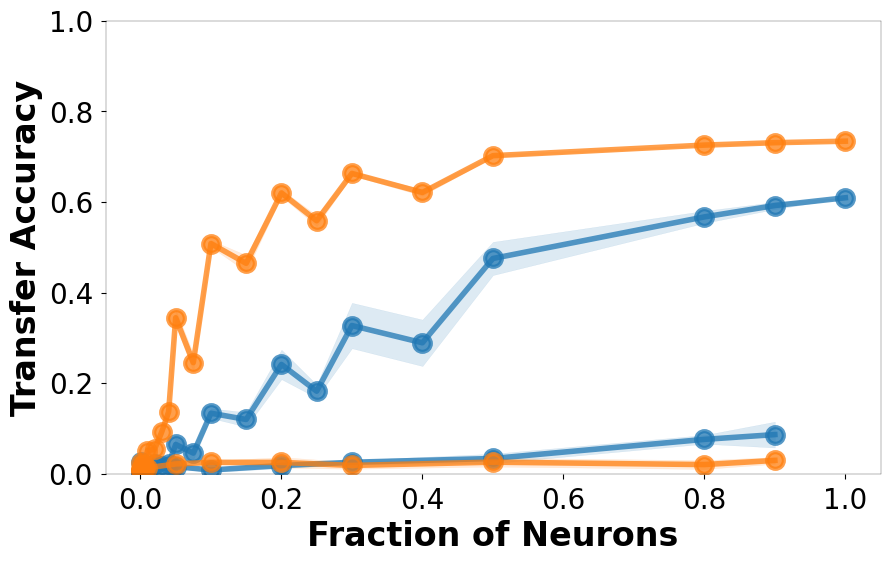

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0293],
        [0.0092],
        [0.0327],
        ...,
        [0.0364],
        [0.0066],
        [0.0316]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=37, bias=True))]), 'num_neurons': 1, 'in_features': 1, 'out_features': 37}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0237],
        [0.0259],
        [0.0182],
        ...,
        [0.0135],
        [0.0308],
        [0.0183]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=37, bias=True))]), 'num_neurons': 1, 'in_features': 1, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0002],
        [0.0080],
        [0.0066],
        ...,
        [0.0318],
        [0.0235],
        [0.0114]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=37, bias=True))]), 'num_neurons': 1, 'in_features': 1, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0212],
        [0.0182],
        [0.0019],
        ...,
        [0.0097],
        [0.0347],
        [0.0045]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=37, bias=True))]), 'num_neurons': 1, 'in_features': 1, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0319],
        [0.0135],
        [0.0241],
        ...,
        [0.0261],
        [0.0365],
        [0.0142]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=37, bias=True))]), 'num_neurons': 1, 'in_features': 1, 'out_features': 37}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0293, 0.0107],
        [0.0092, 0.0312],
        [0.0327, 0.0087],
        ...,
        [0.0364, 0.0297],
        [0.0066, 0.0059],
        [0.0316, 0.0325]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=2, out_features=37, bias=True))]), 'num_neurons': 2, 'in_features': 2, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0237, 0.0147],
        [0.0259, 0.0166],
        [0.0182, 0.0379],
        ...,
        [0.0135, 0.0363],
        [0.0308, 0.0034],
        [0.0183, 0.0086]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=2, out_features=37, bias=True))]), 'num_neurons': 2, 'in_features': 2, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0002, 0.0040],
        [0.0080, 0.0216],
        [0.0066, 0.0195],
        ...,
        [0.0318, 0.0316],
        [0.0235, 0.0020],
        [0.0114, 0.0307]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=2, out_features=37, bias=True))]), 'num_neurons': 2, 'in_features': 2, 'out_features': 37}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0212, 0.0217],
        [0.0182, 0.0004],
        [0.0019, 0.0112],
        ...,
        [0.0097, 0.0055],
        [0.0347, 0.0033],
        [0.0045, 0.0179]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=2, out_features=37, bias=True))]), 'num_neurons': 2, 'in_features': 2, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0319, 0.0048],
        [0.0135, 0.0354],
        [0.0241, 0.0242],
        ...,
        [0.0261, 0.0080],
        [0.0365, 0.0261],
        [0.0142, 0.0321]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=2, out_features=37, bias=True))]), 'num_neurons': 2, 'in_features': 2, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0293, 0.0107, 0.0154,  ..., 0.0282, 0.0217, 0.0167],
        [0.0092, 0.0312, 0.0360,  ..., 0.0061, 0.0263, 0.0285],
        [0.0327, 0.0087, 0.0024,  ..., 0.0358, 0.0185, 0.0114],
        ...,
        [0.0364, 0.0297, 0.0368,  ..., 0.0301, 0.0206, 0.0141],
        [0.0066, 0.0059, 0.0168,  ..., 0.0306, 0.0300, 0.0137],
        [0.0316, 0.0325, 0.0240,  ..., 0.0268, 0.0371, 0.0273]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=10, out_features=37, bias=True))]), 'num_neurons': 10, 'in_features': 10, 'out_features': 37}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0237, 0.0147, 0.0247,  ..., 0.0036, 0.0233, 0.0022],
        [0.0259, 0.0166, 0.0207,  ..., 0.0288, 0.0055, 0.0107],
        [0.0182, 0.0379, 0.0208,  ..., 0.0281, 0.0233, 0.0351],
        ...,
        [0.0135, 0.0363, 0.0187,  ..., 0.0207, 0.0165, 0.0339],
        [0.0308, 0.0034, 0.0073,  ..., 0.0107, 0.0183, 0.0165],
        [0.0183, 0.0086, 0.0305,  ..., 0.0292, 0.0325, 0.0226]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=10, out_features=37, bias=True))]), 'num_neurons': 10, 'in_features': 10, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0002, 0.0040, 0.0110,  ..., 0.0285, 0.0229, 0.0333],
        [0.0080, 0.0216, 0.0208,  ..., 0.0231, 0.0242, 0.0344],
        [0.0066, 0.0195, 0.0333,  ..., 0.0203, 0.0087, 0.0076],
        ...,
        [0.0318, 0.0316, 0.0314,  ..., 0.0128, 0.0191, 0.0040],
        [0.0235, 0.0020, 0.0176,  ..., 0.0106, 0.0372, 0.0259],
        [0.0114, 0.0307, 0.0021,  ..., 0.0274, 0.0280, 0.0313]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=10, out_features=37, bias=True))]), 'num_neurons': 10, 'in_features': 10, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0212, 0.0217, 0.0035,  ..., 0.0352, 0.0240, 0.0376],
        [0.0182, 0.0004, 0.0350,  ..., 0.0122, 0.0038, 0.0117],
        [0.0019, 0.0112, 0.0323,  ..., 0.0344, 0.0048, 0.0346],
        ...,
        [0.0097, 0.0055, 0.0274,  ..., 0.0083, 0.0224, 0.0382],
        [0.0347, 0.0033, 0.0186,  ..., 0.0082, 0.0169, 0.0161],
        [0.0045, 0.0179, 0.0291,  ..., 0.0192, 0.0191, 0.0207]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=10, out_features=37, bias=True))]), 'num_neurons': 10, 'in_features': 10, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0319, 0.0048, 0.0344,  ..., 0.0285, 0.0013, 0.0381],
        [0.0135, 0.0354, 0.0049,  ..., 0.0185, 0.0360, 0.0059],
        [0.0241, 0.0242, 0.0321,  ..., 0.0339, 0.0296, 0.0156],
        ...,
        [0.0261, 0.0080, 0.0176,  ..., 0.0104, 0.0304, 0.0281],
        [0.0365, 0.0261, 0.0331,  ..., 0.0180, 0.0108, 0.0319],
        [0.0142, 0.0321, 0.0103,  ..., 0.0324, 0.0381, 0.0316]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=10, out_features=37, bias=True))]), 'num_neurons': 10, 'in_features': 10, 'out_features': 37}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0293, 0.0107, 0.0154,  ..., 0.0190, 0.0356, 0.0251],
        [0.0092, 0.0312, 0.0360,  ..., 0.0186, 0.0359, 0.0336],
        [0.0327, 0.0087, 0.0024,  ..., 0.0059, 0.0310, 0.0329],
        ...,
        [0.0364, 0.0297, 0.0368,  ..., 0.0094, 0.0038, 0.0323],
        [0.0066, 0.0059, 0.0168,  ..., 0.0359, 0.0350, 0.0369],
        [0.0316, 0.0325, 0.0240,  ..., 0.0085, 0.0256, 0.0127]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=20, out_features=37, bias=True))]), 'num_neurons': 20, 'in_features': 20, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0237, 0.0147, 0.0247,  ..., 0.0080, 0.0119, 0.0383],
        [0.0259, 0.0166, 0.0207,  ..., 0.0301, 0.0183, 0.0238],
        [0.0182, 0.0379, 0.0208,  ..., 0.0186, 0.0304, 0.0287],
        ...,
        [0.0135, 0.0363, 0.0187,  ..., 0.0152, 0.0053, 0.0070],
        [0.0308, 0.0034, 0.0073,  ..., 0.0302, 0.0018, 0.0185],
        [0.0183, 0.0086, 0.0305,  ..., 0.0326, 0.0316, 0.0097]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=20, out_features=37, bias=True))]), 'num_neurons': 20, 'in_features': 20, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0002, 0.0040, 0.0110,  ..., 0.0369, 0.0320, 0.0332],
        [0.0080, 0.0216, 0.0208,  ..., 0.0130, 0.0220, 0.0108],
        [0.0066, 0.0195, 0.0333,  ..., 0.0226, 0.0099, 0.0352],
        ...,
        [0.0318, 0.0316, 0.0314,  ..., 0.0201, 0.0034, 0.0083],
        [0.0235, 0.0020, 0.0176,  ..., 0.0246, 0.0103, 0.0047],
        [0.0114, 0.0307, 0.0021,  ..., 0.0145, 0.0154, 0.0072]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=20, out_features=37, bias=True))]), 'num_neurons': 20, 'in_features': 20, 'out_features': 37}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0212, 0.0217, 0.0035,  ..., 0.0083, 0.0117, 0.0015],
        [0.0182, 0.0004, 0.0350,  ..., 0.0266, 0.0333, 0.0358],
        [0.0019, 0.0112, 0.0323,  ..., 0.0384, 0.0083, 0.0380],
        ...,
        [0.0097, 0.0055, 0.0274,  ..., 0.0257, 0.0005, 0.0058],
        [0.0347, 0.0033, 0.0186,  ..., 0.0114, 0.0024, 0.0210],
        [0.0045, 0.0179, 0.0291,  ..., 0.0354, 0.0036, 0.0130]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=20, out_features=37, bias=True))]), 'num_neurons': 20, 'in_features': 20, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0319, 0.0048, 0.0344,  ..., 0.0243, 0.0022, 0.0358],
        [0.0135, 0.0354, 0.0049,  ..., 0.0249, 0.0295, 0.0001],
        [0.0241, 0.0242, 0.0321,  ..., 0.0007, 0.0380, 0.0348],
        ...,
        [0.0261, 0.0080, 0.0176,  ..., 0.0016, 0.0302, 0.0084],
        [0.0365, 0.0261, 0.0331,  ..., 0.0037, 0.0352, 0.0001],
        [0.0142, 0.0321, 0.0103,  ..., 0.0289, 0.0378, 0.0146]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=20, out_features=37, bias=True))]), 'num_neurons': 20, 'in_features': 20, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0293, 0.0107, 0.0154,  ..., 0.0133, 0.0367, 0.0156],
        [0.0092, 0.0312, 0.0360,  ..., 0.0365, 0.0281, 0.0273],
        [0.0327, 0.0087, 0.0024,  ..., 0.0351, 0.0139, 0.0225],
        ...,
        [0.0364, 0.0297, 0.0368,  ..., 0.0002, 0.0188, 0.0039],
        [0.0066, 0.0059, 0.0168,  ..., 0.0213, 0.0050, 0.0259],
        [0.0316, 0.0325, 0.0240,  ..., 0.0077, 0.0032, 0.0136]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=102, out_features=37, bias=True))]), 'num_neurons': 102, 'in_features': 102, 'out_features': 37}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0237, 0.0147, 0.0247,  ..., 0.0129, 0.0122, 0.0161],
        [0.0259, 0.0166, 0.0207,  ..., 0.0199, 0.0330, 0.0291],
        [0.0182, 0.0379, 0.0208,  ..., 0.0300, 0.0339, 0.0076],
        ...,
        [0.0135, 0.0363, 0.0187,  ..., 0.0074, 0.0123, 0.0245],
        [0.0308, 0.0034, 0.0073,  ..., 0.0120, 0.0380, 0.0271],
        [0.0183, 0.0086, 0.0305,  ..., 0.0190, 0.0276, 0.0226]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=102, out_features=37, bias=True))]), 'num_neurons': 102, 'in_features': 102, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0002, 0.0040, 0.0110,  ..., 0.0097, 0.0223, 0.0270],
        [0.0080, 0.0216, 0.0208,  ..., 0.0084, 0.0101, 0.0088],
        [0.0066, 0.0195, 0.0333,  ..., 0.0253, 0.0238, 0.0161],
        ...,
        [0.0318, 0.0316, 0.0314,  ..., 0.0180, 0.0277, 0.0311],
        [0.0235, 0.0020, 0.0176,  ..., 0.0380, 0.0241, 0.0220],
        [0.0114, 0.0307, 0.0021,  ..., 0.0367, 0.0165, 0.0123]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=102, out_features=37, bias=True))]), 'num_neurons': 102, 'in_features': 102, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0212, 0.0217, 0.0035,  ..., 0.0053, 0.0095, 0.0354],
        [0.0182, 0.0004, 0.0350,  ..., 0.0128, 0.0109, 0.0342],
        [0.0019, 0.0112, 0.0323,  ..., 0.0292, 0.0367, 0.0273],
        ...,
        [0.0097, 0.0055, 0.0274,  ..., 0.0151, 0.0077, 0.0232],
        [0.0347, 0.0033, 0.0186,  ..., 0.0288, 0.0320, 0.0210],
        [0.0045, 0.0179, 0.0291,  ..., 0.0333, 0.0304, 0.0359]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=102, out_features=37, bias=True))]), 'num_neurons': 102, 'in_features': 102, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0319, 0.0048, 0.0344,  ..., 0.0313, 0.0131, 0.0016],
        [0.0135, 0.0354, 0.0049,  ..., 0.0133, 0.0258, 0.0229],
        [0.0241, 0.0242, 0.0321,  ..., 0.0373, 0.0357, 0.0187],
        ...,
        [0.0261, 0.0080, 0.0176,  ..., 0.0018, 0.0015, 0.0259],
        [0.0365, 0.0261, 0.0331,  ..., 0.0081, 0.0103, 0.0239],
        [0.0142, 0.0321, 0.0103,  ..., 0.0278, 0.0318, 0.0347]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=102, out_features=37, bias=True))]), 'num_neurons': 102, 'in_features': 102, 'out_features': 37}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0293, 0.0107, 0.0154,  ..., 0.0050, 0.0351, 0.0116],
        [0.0092, 0.0312, 0.0360,  ..., 0.0061, 0.0307, 0.0281],
        [0.0327, 0.0087, 0.0024,  ..., 0.0374, 0.0237, 0.0074],
        ...,
        [0.0364, 0.0297, 0.0368,  ..., 0.0231, 0.0144, 0.0156],
        [0.0066, 0.0059, 0.0168,  ..., 0.0354, 0.0191, 0.0047],
        [0.0316, 0.0325, 0.0240,  ..., 0.0038, 0.0319, 0.0265]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=204, out_features=37, bias=True))]), 'num_neurons': 204, 'in_features': 204, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0237, 0.0147, 0.0247,  ..., 0.0071, 0.0111, 0.0028],
        [0.0259, 0.0166, 0.0207,  ..., 0.0149, 0.0029, 0.0364],
        [0.0182, 0.0379, 0.0208,  ..., 0.0254, 0.0253, 0.0027],
        ...,
        [0.0135, 0.0363, 0.0187,  ..., 0.0327, 0.0244, 0.0027],
        [0.0308, 0.0034, 0.0073,  ..., 0.0323, 0.0115, 0.0159],
        [0.0183, 0.0086, 0.0305,  ..., 0.0300, 0.0069, 0.0267]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=204, out_features=37, bias=True))]), 'num_neurons': 204, 'in_features': 204, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0002, 0.0040, 0.0110,  ..., 0.0315, 0.0298, 0.0361],
        [0.0080, 0.0216, 0.0208,  ..., 0.0080, 0.0197, 0.0249],
        [0.0066, 0.0195, 0.0333,  ..., 0.0325, 0.0247, 0.0067],
        ...,
        [0.0318, 0.0316, 0.0314,  ..., 0.0133, 0.0363, 0.0153],
        [0.0235, 0.0020, 0.0176,  ..., 0.0027, 0.0060, 0.0220],
        [0.0114, 0.0307, 0.0021,  ..., 0.0026, 0.0065, 0.0074]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=204, out_features=37, bias=True))]), 'num_neurons': 204, 'in_features': 204, 'out_features': 37}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0212, 0.0217, 0.0035,  ..., 0.0020, 0.0225, 0.0305],
        [0.0182, 0.0004, 0.0350,  ..., 0.0345, 0.0147, 0.0361],
        [0.0019, 0.0112, 0.0323,  ..., 0.0088, 0.0139, 0.0239],
        ...,
        [0.0097, 0.0055, 0.0274,  ..., 0.0151, 0.0222, 0.0361],
        [0.0347, 0.0033, 0.0186,  ..., 0.0287, 0.0029, 0.0244],
        [0.0045, 0.0179, 0.0291,  ..., 0.0369, 0.0239, 0.0222]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=204, out_features=37, bias=True))]), 'num_neurons': 204, 'in_features': 204, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0319, 0.0048, 0.0344,  ..., 0.0198, 0.0061, 0.0242],
        [0.0135, 0.0354, 0.0049,  ..., 0.0162, 0.0007, 0.0146],
        [0.0241, 0.0242, 0.0321,  ..., 0.0265, 0.0339, 0.0033],
        ...,
        [0.0261, 0.0080, 0.0176,  ..., 0.0048, 0.0366, 0.0362],
        [0.0365, 0.0261, 0.0331,  ..., 0.0094, 0.0277, 0.0077],
        [0.0142, 0.0321, 0.0103,  ..., 0.0253, 0.0220, 0.0017]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=204, out_features=37, bias=True))]), 'num_neurons': 204, 'in_features': 204, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[2.9297e-02, 1.0726e-02, 1.5391e-02,  ..., 9.3566e-03, 5.5641e-03,
         3.2455e-02],
        [9.2465e-03, 3.1238e-02, 3.6019e-02,  ..., 6.4606e-03, 3.7757e-02,
         2.7041e-02],
        [3.2742e-02, 8.7411e-03, 2.3545e-03,  ..., 1.1711e-02, 3.0374e-02,
         1.3710e-02],
        ...,
        [3.6448e-02, 2.9718e-02, 3.6840e-02,  ..., 1.1693e-02, 6.9777e-05,
         3.4326e-02],
        [6.5958e-03, 5.8966e-03, 1.6845e-02,  ..., 2.4715e-02, 7.5857e-03,
         2.1349e-02],
        [3.1606e-02, 3.2466e-02, 2.4011e-02,  ..., 1.4379e-02, 1.8828e-03,
         1.8098e-02]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules'

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0237, 0.0147, 0.0247,  ..., 0.0074, 0.0019, 0.0368],
        [0.0259, 0.0166, 0.0207,  ..., 0.0287, 0.0281, 0.0169],
        [0.0182, 0.0379, 0.0208,  ..., 0.0221, 0.0018, 0.0113],
        ...,
        [0.0135, 0.0363, 0.0187,  ..., 0.0083, 0.0181, 0.0270],
        [0.0308, 0.0034, 0.0073,  ..., 0.0095, 0.0301, 0.0162],
        [0.0183, 0.0086, 0.0305,  ..., 0.0255, 0.0292, 0.0221]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=409, out_features=37, bias=True))]), 'num_neurons': 409, 'in_features': 409, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0002, 0.0040, 0.0110,  ..., 0.0132, 0.0079, 0.0017],
        [0.0080, 0.0216, 0.0208,  ..., 0.0221, 0.0081, 0.0348],
        [0.0066, 0.0195, 0.0333,  ..., 0.0185, 0.0106, 0.0206],
        ...,
        [0.0318, 0.0316, 0.0314,  ..., 0.0155, 0.0141, 0.0143],
        [0.0235, 0.0020, 0.0176,  ..., 0.0371, 0.0330, 0.0281],
        [0.0114, 0.0307, 0.0021,  ..., 0.0039, 0.0009, 0.0119]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=409, out_features=37, bias=True))]), 'num_neurons': 409, 'in_features': 409, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0212, 0.0217, 0.0035,  ..., 0.0316, 0.0187, 0.0256],
        [0.0182, 0.0004, 0.0350,  ..., 0.0191, 0.0177, 0.0346],
        [0.0019, 0.0112, 0.0323,  ..., 0.0022, 0.0197, 0.0364],
        ...,
        [0.0097, 0.0055, 0.0274,  ..., 0.0194, 0.0274, 0.0343],
        [0.0347, 0.0033, 0.0186,  ..., 0.0021, 0.0157, 0.0042],
        [0.0045, 0.0179, 0.0291,  ..., 0.0224, 0.0129, 0.0105]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=409, out_features=37, bias=True))]), 'num_neurons': 409, 'in_features': 409, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0319, 0.0048, 0.0344,  ..., 0.0174, 0.0033, 0.0079],
        [0.0135, 0.0354, 0.0049,  ..., 0.0337, 0.0296, 0.0372],
        [0.0241, 0.0242, 0.0321,  ..., 0.0163, 0.0325, 0.0043],
        ...,
        [0.0261, 0.0080, 0.0176,  ..., 0.0286, 0.0282, 0.0101],
        [0.0365, 0.0261, 0.0331,  ..., 0.0027, 0.0376, 0.0097],
        [0.0142, 0.0321, 0.0103,  ..., 0.0256, 0.0206, 0.0002]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=409, out_features=37, bias=True))]), 'num_neurons': 409, 'in_features': 409, 'out_features': 37}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0293, 0.0107, 0.0154,  ..., 0.0150, 0.0139, 0.0249],
        [0.0092, 0.0312, 0.0360,  ..., 0.0338, 0.0365, 0.0268],
        [0.0327, 0.0087, 0.0024,  ..., 0.0156, 0.0285, 0.0277],
        ...,
        [0.0364, 0.0297, 0.0368,  ..., 0.0066, 0.0152, 0.0143],
        [0.0066, 0.0059, 0.0168,  ..., 0.0061, 0.0138, 0.0120],
        [0.0316, 0.0325, 0.0240,  ..., 0.0198, 0.0086, 0.0070]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=614, out_features=37, bias=True))]), 'num_neurons': 614, 'in_features': 614, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0237, 0.0147, 0.0247,  ..., 0.0034, 0.0243, 0.0247],
        [0.0259, 0.0166, 0.0207,  ..., 0.0176, 0.0365, 0.0244],
        [0.0182, 0.0379, 0.0208,  ..., 0.0202, 0.0271, 0.0084],
        ...,
        [0.0135, 0.0363, 0.0187,  ..., 0.0202, 0.0013, 0.0184],
        [0.0308, 0.0034, 0.0073,  ..., 0.0121, 0.0274, 0.0190],
        [0.0183, 0.0086, 0.0305,  ..., 0.0307, 0.0221, 0.0266]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=614, out_features=37, bias=True))]), 'num_neurons': 614, 'in_features': 614, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0002, 0.0040, 0.0110,  ..., 0.0115, 0.0265, 0.0153],
        [0.0080, 0.0216, 0.0208,  ..., 0.0156, 0.0036, 0.0050],
        [0.0066, 0.0195, 0.0333,  ..., 0.0333, 0.0141, 0.0136],
        ...,
        [0.0318, 0.0316, 0.0314,  ..., 0.0103, 0.0304, 0.0136],
        [0.0235, 0.0020, 0.0176,  ..., 0.0159, 0.0236, 0.0263],
        [0.0114, 0.0307, 0.0021,  ..., 0.0309, 0.0372, 0.0258]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=614, out_features=37, bias=True))]), 'num_neurons': 614, 'in_features': 614, 'out_features': 37}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0212, 0.0217, 0.0035,  ..., 0.0227, 0.0180, 0.0357],
        [0.0182, 0.0004, 0.0350,  ..., 0.0203, 0.0346, 0.0136],
        [0.0019, 0.0112, 0.0323,  ..., 0.0247, 0.0230, 0.0289],
        ...,
        [0.0097, 0.0055, 0.0274,  ..., 0.0142, 0.0120, 0.0285],
        [0.0347, 0.0033, 0.0186,  ..., 0.0022, 0.0115, 0.0276],
        [0.0045, 0.0179, 0.0291,  ..., 0.0198, 0.0326, 0.0330]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=614, out_features=37, bias=True))]), 'num_neurons': 614, 'in_features': 614, 'out_features': 37}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0319, 0.0048, 0.0344,  ..., 0.0050, 0.0100, 0.0076],
        [0.0135, 0.0354, 0.0049,  ..., 0.0346, 0.0364, 0.0110],
        [0.0241, 0.0242, 0.0321,  ..., 0.0356, 0.0113, 0.0137],
        ...,
        [0.0261, 0.0080, 0.0176,  ..., 0.0265, 0.0139, 0.0033],
        [0.0365, 0.0261, 0.0331,  ..., 0.0047, 0.0029, 0.0202],
        [0.0142, 0.0321, 0.0103,  ..., 0.0347, 0.0225, 0.0007]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=614, out_features=37, bias=True))]), 'num_neurons': 614, 'in_features': 614, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0293, 0.0107, 0.0154,  ..., 0.0187, 0.0130, 0.0071],
        [0.0092, 0.0312, 0.0360,  ..., 0.0157, 0.0263, 0.0095],
        [0.0327, 0.0087, 0.0024,  ..., 0.0356, 0.0087, 0.0038],
        ...,
        [0.0364, 0.0297, 0.0368,  ..., 0.0145, 0.0137, 0.0240],
        [0.0066, 0.0059, 0.0168,  ..., 0.0228, 0.0178, 0.0297],
        [0.0316, 0.0325, 0.0240,  ..., 0.0240, 0.0245, 0.0279]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1024, out_features=37, bias=True))]), 'num_neurons': 1024, 'in_features': 1024, 'out_features': 37}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0237, 0.0147, 0.0247,  ..., 0.0211, 0.0033, 0.0133],
        [0.0259, 0.0166, 0.0207,  ..., 0.0110, 0.0036, 0.0106],
        [0.0182, 0.0379, 0.0208,  ..., 0.0214, 0.0125, 0.0291],
        ...,
        [0.0135, 0.0363, 0.0187,  ..., 0.0109, 0.0372, 0.0319],
        [0.0308, 0.0034, 0.0073,  ..., 0.0320, 0.0087, 0.0187],
        [0.0183, 0.0086, 0.0305,  ..., 0.0269, 0.0097, 0.0097]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1024, out_features=37, bias=True))]), 'num_neurons': 1024, 'in_features': 1024, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0002, 0.0040, 0.0110,  ..., 0.0148, 0.0241, 0.0101],
        [0.0080, 0.0216, 0.0208,  ..., 0.0367, 0.0005, 0.0321],
        [0.0066, 0.0195, 0.0333,  ..., 0.0098, 0.0293, 0.0012],
        ...,
        [0.0318, 0.0316, 0.0314,  ..., 0.0277, 0.0065, 0.0099],
        [0.0235, 0.0020, 0.0176,  ..., 0.0137, 0.0184, 0.0083],
        [0.0114, 0.0307, 0.0021,  ..., 0.0065, 0.0333, 0.0124]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1024, out_features=37, bias=True))]), 'num_neurons': 1024, 'in_features': 1024, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0212, 0.0217, 0.0035,  ..., 0.0008, 0.0206, 0.0055],
        [0.0182, 0.0004, 0.0350,  ..., 0.0233, 0.0069, 0.0169],
        [0.0019, 0.0112, 0.0323,  ..., 0.0128, 0.0183, 0.0004],
        ...,
        [0.0097, 0.0055, 0.0274,  ..., 0.0340, 0.0032, 0.0017],
        [0.0347, 0.0033, 0.0186,  ..., 0.0136, 0.0148, 0.0295],
        [0.0045, 0.0179, 0.0291,  ..., 0.0276, 0.0068, 0.0283]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1024, out_features=37, bias=True))]), 'num_neurons': 1024, 'in_features': 1024, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0319, 0.0048, 0.0344,  ..., 0.0266, 0.0262, 0.0129],
        [0.0135, 0.0354, 0.0049,  ..., 0.0234, 0.0269, 0.0311],
        [0.0241, 0.0242, 0.0321,  ..., 0.0125, 0.0044, 0.0112],
        ...,
        [0.0261, 0.0080, 0.0176,  ..., 0.0016, 0.0357, 0.0039],
        [0.0365, 0.0261, 0.0331,  ..., 0.0271, 0.0275, 0.0260],
        [0.0142, 0.0321, 0.0103,  ..., 0.0062, 0.0164, 0.0211]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1024, out_features=37, bias=True))]), 'num_neurons': 1024, 'in_features': 1024, 'out_features': 37}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0293, 0.0107, 0.0154,  ..., 0.0235, 0.0189, 0.0341],
        [0.0092, 0.0312, 0.0360,  ..., 0.0015, 0.0078, 0.0258],
        [0.0327, 0.0087, 0.0024,  ..., 0.0012, 0.0320, 0.0255],
        ...,
        [0.0364, 0.0297, 0.0368,  ..., 0.0164, 0.0180, 0.0305],
        [0.0066, 0.0059, 0.0168,  ..., 0.0074, 0.0221, 0.0121],
        [0.0316, 0.0325, 0.0240,  ..., 0.0105, 0.0372, 0.0099]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1638, out_features=37, bias=True))]), 'num_neurons': 1638, 'in_features': 1638, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0237, 0.0147, 0.0247,  ..., 0.0339, 0.0127, 0.0115],
        [0.0259, 0.0166, 0.0207,  ..., 0.0224, 0.0329, 0.0158],
        [0.0182, 0.0379, 0.0208,  ..., 0.0316, 0.0210, 0.0051],
        ...,
        [0.0135, 0.0363, 0.0187,  ..., 0.0349, 0.0041, 0.0198],
        [0.0308, 0.0034, 0.0073,  ..., 0.0130, 0.0138, 0.0214],
        [0.0183, 0.0086, 0.0305,  ..., 0.0020, 0.0026, 0.0246]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1638, out_features=37, bias=True))]), 'num_neurons': 1638, 'in_features': 1638, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0002, 0.0040, 0.0110,  ..., 0.0119, 0.0375, 0.0179],
        [0.0080, 0.0216, 0.0208,  ..., 0.0326, 0.0116, 0.0155],
        [0.0066, 0.0195, 0.0333,  ..., 0.0062, 0.0294, 0.0158],
        ...,
        [0.0318, 0.0316, 0.0314,  ..., 0.0300, 0.0187, 0.0268],
        [0.0235, 0.0020, 0.0176,  ..., 0.0351, 0.0040, 0.0090],
        [0.0114, 0.0307, 0.0021,  ..., 0.0066, 0.0242, 0.0296]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1638, out_features=37, bias=True))]), 'num_neurons': 1638, 'in_features': 1638, 'out_features': 37}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0212, 0.0217, 0.0035,  ..., 0.0260, 0.0147, 0.0177],
        [0.0182, 0.0004, 0.0350,  ..., 0.0270, 0.0248, 0.0073],
        [0.0019, 0.0112, 0.0323,  ..., 0.0253, 0.0061, 0.0015],
        ...,
        [0.0097, 0.0055, 0.0274,  ..., 0.0068, 0.0342, 0.0035],
        [0.0347, 0.0033, 0.0186,  ..., 0.0206, 0.0079, 0.0105],
        [0.0045, 0.0179, 0.0291,  ..., 0.0070, 0.0104, 0.0300]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1638, out_features=37, bias=True))]), 'num_neurons': 1638, 'in_features': 1638, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0319, 0.0048, 0.0344,  ..., 0.0259, 0.0345, 0.0123],
        [0.0135, 0.0354, 0.0049,  ..., 0.0007, 0.0037, 0.0172],
        [0.0241, 0.0242, 0.0321,  ..., 0.0313, 0.0381, 0.0209],
        ...,
        [0.0261, 0.0080, 0.0176,  ..., 0.0054, 0.0298, 0.0331],
        [0.0365, 0.0261, 0.0331,  ..., 0.0286, 0.0250, 0.0080],
        [0.0142, 0.0321, 0.0103,  ..., 0.0109, 0.0008, 0.0106]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1638, out_features=37, bias=True))]), 'num_neurons': 1638, 'in_features': 1638, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0293, 0.0107, 0.0154,  ..., 0.0232, 0.0017, 0.0217],
        [0.0092, 0.0312, 0.0360,  ..., 0.0092, 0.0185, 0.0343],
        [0.0327, 0.0087, 0.0024,  ..., 0.0220, 0.0255, 0.0307],
        ...,
        [0.0364, 0.0297, 0.0368,  ..., 0.0088, 0.0218, 0.0140],
        [0.0066, 0.0059, 0.0168,  ..., 0.0239, 0.0337, 0.0281],
        [0.0316, 0.0325, 0.0240,  ..., 0.0188, 0.0016, 0.0312]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1843, out_features=37, bias=True))]), 'num_neurons': 1843, 'in_features': 1843, 'out_features': 37}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0237, 0.0147, 0.0247,  ..., 0.0085, 0.0174, 0.0276],
        [0.0259, 0.0166, 0.0207,  ..., 0.0225, 0.0308, 0.0290],
        [0.0182, 0.0379, 0.0208,  ..., 0.0292, 0.0020, 0.0192],
        ...,
        [0.0135, 0.0363, 0.0187,  ..., 0.0216, 0.0131, 0.0333],
        [0.0308, 0.0034, 0.0073,  ..., 0.0274, 0.0008, 0.0328],
        [0.0183, 0.0086, 0.0305,  ..., 0.0260, 0.0057, 0.0025]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1843, out_features=37, bias=True))]), 'num_neurons': 1843, 'in_features': 1843, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[1.6364e-04, 4.0469e-03, 1.1049e-02,  ..., 1.3039e-02, 1.2401e-02,
         3.6576e-02],
        [7.9523e-03, 2.1579e-02, 2.0770e-02,  ..., 1.6732e-02, 7.4345e-03,
         1.5582e-02],
        [6.5652e-03, 1.9527e-02, 3.3286e-02,  ..., 3.2518e-02, 3.5044e-02,
         9.6515e-03],
        ...,
        [3.1779e-02, 3.1634e-02, 3.1350e-02,  ..., 6.7258e-03, 1.9493e-02,
         1.9070e-02],
        [2.3496e-02, 1.9626e-03, 1.7631e-02,  ..., 1.8468e-02, 7.1234e-05,
         3.6016e-02],
        [1.1356e-02, 3.0729e-02, 2.1142e-03,  ..., 3.1660e-02, 3.5862e-02,
         3.1412e-03]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules'

Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0212, 0.0217, 0.0035,  ..., 0.0166, 0.0330, 0.0268],
        [0.0182, 0.0004, 0.0350,  ..., 0.0053, 0.0320, 0.0089],
        [0.0019, 0.0112, 0.0323,  ..., 0.0305, 0.0323, 0.0078],
        ...,
        [0.0097, 0.0055, 0.0274,  ..., 0.0043, 0.0149, 0.0103],
        [0.0347, 0.0033, 0.0186,  ..., 0.0266, 0.0305, 0.0285],
        [0.0045, 0.0179, 0.0291,  ..., 0.0336, 0.0307, 0.0364]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1843, out_features=37, bias=True))]), 'num_neurons': 1843, 'in_features': 1843, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0319, 0.0048, 0.0344,  ..., 0.0238, 0.0148, 0.0136],
        [0.0135, 0.0354, 0.0049,  ..., 0.0220, 0.0310, 0.0125],
        [0.0241, 0.0242, 0.0321,  ..., 0.0197, 0.0239, 0.0207],
        ...,
        [0.0261, 0.0080, 0.0176,  ..., 0.0347, 0.0139, 0.0173],
        [0.0365, 0.0261, 0.0331,  ..., 0.0235, 0.0384, 0.0365],
        [0.0142, 0.0321, 0.0103,  ..., 0.0250, 0.0100, 0.0137]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1843, out_features=37, bias=True))]), 'num_neurons': 1843, 'in_features': 1843, 'out_features': 37}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0293],
        [0.0092],
        [0.0327],
        ...,
        [0.0364],
        [0.0066],
        [0.0316]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=37, bias=True))]), 'num_neurons': 1, 'in_features': 1, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0237],
        [0.0259],
        [0.0182],
        ...,
        [0.0135],
        [0.0308],
        [0.0183]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=37, bias=True))]), 'num_neurons': 1, 'in_features': 1, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0002],
        [0.0080],
        [0.0066],
        ...,
        [0.0318],
        [0.0235],
        [0.0114]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=37, bias=True))]), 'num_neurons': 1, 'in_features': 1, 'out_features': 37}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0212],
        [0.0182],
        [0.0019],
        ...,
        [0.0097],
        [0.0347],
        [0.0045]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=37, bias=True))]), 'num_neurons': 1, 'in_features': 1, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0319],
        [0.0135],
        [0.0241],
        ...,
        [0.0261],
        [0.0365],
        [0.0142]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=37, bias=True))]), 'num_neurons': 1, 'in_features': 1, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0293, 0.0107],
        [0.0092, 0.0312],
        [0.0327, 0.0087],
        ...,
        [0.0364, 0.0297],
        [0.0066, 0.0059],
        [0.0316, 0.0325]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=2, out_features=37, bias=True))]), 'num_neurons': 2, 'in_features': 2, 'out_features': 37}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0237, 0.0147],
        [0.0259, 0.0166],
        [0.0182, 0.0379],
        ...,
        [0.0135, 0.0363],
        [0.0308, 0.0034],
        [0.0183, 0.0086]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=2, out_features=37, bias=True))]), 'num_neurons': 2, 'in_features': 2, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0002, 0.0040],
        [0.0080, 0.0216],
        [0.0066, 0.0195],
        ...,
        [0.0318, 0.0316],
        [0.0235, 0.0020],
        [0.0114, 0.0307]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=2, out_features=37, bias=True))]), 'num_neurons': 2, 'in_features': 2, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0212, 0.0217],
        [0.0182, 0.0004],
        [0.0019, 0.0112],
        ...,
        [0.0097, 0.0055],
        [0.0347, 0.0033],
        [0.0045, 0.0179]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=2, out_features=37, bias=True))]), 'num_neurons': 2, 'in_features': 2, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0319, 0.0048],
        [0.0135, 0.0354],
        [0.0241, 0.0242],
        ...,
        [0.0261, 0.0080],
        [0.0365, 0.0261],
        [0.0142, 0.0321]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=2, out_features=37, bias=True))]), 'num_neurons': 2, 'in_features': 2, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0293, 0.0107, 0.0154,  ..., 0.0282, 0.0217, 0.0167],
        [0.0092, 0.0312, 0.0360,  ..., 0.0061, 0.0263, 0.0285],
        [0.0327, 0.0087, 0.0024,  ..., 0.0358, 0.0185, 0.0114],
        ...,
        [0.0364, 0.0297, 0.0368,  ..., 0.0301, 0.0206, 0.0141],
        [0.0066, 0.0059, 0.0168,  ..., 0.0306, 0.0300, 0.0137],
        [0.0316, 0.0325, 0.0240,  ..., 0.0268, 0.0371, 0.0273]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=10, out_features=37, bias=True))]), 'num_neurons': 10, 'in_features': 10, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0237, 0.0147, 0.0247,  ..., 0.0036, 0.0233, 0.0022],
        [0.0259, 0.0166, 0.0207,  ..., 0.0288, 0.0055, 0.0107],
        [0.0182, 0.0379, 0.0208,  ..., 0.0281, 0.0233, 0.0351],
        ...,
        [0.0135, 0.0363, 0.0187,  ..., 0.0207, 0.0165, 0.0339],
        [0.0308, 0.0034, 0.0073,  ..., 0.0107, 0.0183, 0.0165],
        [0.0183, 0.0086, 0.0305,  ..., 0.0292, 0.0325, 0.0226]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=10, out_features=37, bias=True))]), 'num_neurons': 10, 'in_features': 10, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0002, 0.0040, 0.0110,  ..., 0.0285, 0.0229, 0.0333],
        [0.0080, 0.0216, 0.0208,  ..., 0.0231, 0.0242, 0.0344],
        [0.0066, 0.0195, 0.0333,  ..., 0.0203, 0.0087, 0.0076],
        ...,
        [0.0318, 0.0316, 0.0314,  ..., 0.0128, 0.0191, 0.0040],
        [0.0235, 0.0020, 0.0176,  ..., 0.0106, 0.0372, 0.0259],
        [0.0114, 0.0307, 0.0021,  ..., 0.0274, 0.0280, 0.0313]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=10, out_features=37, bias=True))]), 'num_neurons': 10, 'in_features': 10, 'out_features': 37}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0212, 0.0217, 0.0035,  ..., 0.0352, 0.0240, 0.0376],
        [0.0182, 0.0004, 0.0350,  ..., 0.0122, 0.0038, 0.0117],
        [0.0019, 0.0112, 0.0323,  ..., 0.0344, 0.0048, 0.0346],
        ...,
        [0.0097, 0.0055, 0.0274,  ..., 0.0083, 0.0224, 0.0382],
        [0.0347, 0.0033, 0.0186,  ..., 0.0082, 0.0169, 0.0161],
        [0.0045, 0.0179, 0.0291,  ..., 0.0192, 0.0191, 0.0207]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=10, out_features=37, bias=True))]), 'num_neurons': 10, 'in_features': 10, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0319, 0.0048, 0.0344,  ..., 0.0285, 0.0013, 0.0381],
        [0.0135, 0.0354, 0.0049,  ..., 0.0185, 0.0360, 0.0059],
        [0.0241, 0.0242, 0.0321,  ..., 0.0339, 0.0296, 0.0156],
        ...,
        [0.0261, 0.0080, 0.0176,  ..., 0.0104, 0.0304, 0.0281],
        [0.0365, 0.0261, 0.0331,  ..., 0.0180, 0.0108, 0.0319],
        [0.0142, 0.0321, 0.0103,  ..., 0.0324, 0.0381, 0.0316]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=10, out_features=37, bias=True))]), 'num_neurons': 10, 'in_features': 10, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0293, 0.0107, 0.0154,  ..., 0.0190, 0.0356, 0.0251],
        [0.0092, 0.0312, 0.0360,  ..., 0.0186, 0.0359, 0.0336],
        [0.0327, 0.0087, 0.0024,  ..., 0.0059, 0.0310, 0.0329],
        ...,
        [0.0364, 0.0297, 0.0368,  ..., 0.0094, 0.0038, 0.0323],
        [0.0066, 0.0059, 0.0168,  ..., 0.0359, 0.0350, 0.0369],
        [0.0316, 0.0325, 0.0240,  ..., 0.0085, 0.0256, 0.0127]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=20, out_features=37, bias=True))]), 'num_neurons': 20, 'in_features': 20, 'out_features': 37}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0237, 0.0147, 0.0247,  ..., 0.0080, 0.0119, 0.0383],
        [0.0259, 0.0166, 0.0207,  ..., 0.0301, 0.0183, 0.0238],
        [0.0182, 0.0379, 0.0208,  ..., 0.0186, 0.0304, 0.0287],
        ...,
        [0.0135, 0.0363, 0.0187,  ..., 0.0152, 0.0053, 0.0070],
        [0.0308, 0.0034, 0.0073,  ..., 0.0302, 0.0018, 0.0185],
        [0.0183, 0.0086, 0.0305,  ..., 0.0326, 0.0316, 0.0097]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=20, out_features=37, bias=True))]), 'num_neurons': 20, 'in_features': 20, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0002, 0.0040, 0.0110,  ..., 0.0369, 0.0320, 0.0332],
        [0.0080, 0.0216, 0.0208,  ..., 0.0130, 0.0220, 0.0108],
        [0.0066, 0.0195, 0.0333,  ..., 0.0226, 0.0099, 0.0352],
        ...,
        [0.0318, 0.0316, 0.0314,  ..., 0.0201, 0.0034, 0.0083],
        [0.0235, 0.0020, 0.0176,  ..., 0.0246, 0.0103, 0.0047],
        [0.0114, 0.0307, 0.0021,  ..., 0.0145, 0.0154, 0.0072]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=20, out_features=37, bias=True))]), 'num_neurons': 20, 'in_features': 20, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0212, 0.0217, 0.0035,  ..., 0.0083, 0.0117, 0.0015],
        [0.0182, 0.0004, 0.0350,  ..., 0.0266, 0.0333, 0.0358],
        [0.0019, 0.0112, 0.0323,  ..., 0.0384, 0.0083, 0.0380],
        ...,
        [0.0097, 0.0055, 0.0274,  ..., 0.0257, 0.0005, 0.0058],
        [0.0347, 0.0033, 0.0186,  ..., 0.0114, 0.0024, 0.0210],
        [0.0045, 0.0179, 0.0291,  ..., 0.0354, 0.0036, 0.0130]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=20, out_features=37, bias=True))]), 'num_neurons': 20, 'in_features': 20, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0319, 0.0048, 0.0344,  ..., 0.0243, 0.0022, 0.0358],
        [0.0135, 0.0354, 0.0049,  ..., 0.0249, 0.0295, 0.0001],
        [0.0241, 0.0242, 0.0321,  ..., 0.0007, 0.0380, 0.0348],
        ...,
        [0.0261, 0.0080, 0.0176,  ..., 0.0016, 0.0302, 0.0084],
        [0.0365, 0.0261, 0.0331,  ..., 0.0037, 0.0352, 0.0001],
        [0.0142, 0.0321, 0.0103,  ..., 0.0289, 0.0378, 0.0146]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=20, out_features=37, bias=True))]), 'num_neurons': 20, 'in_features': 20, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0293, 0.0107, 0.0154,  ..., 0.0133, 0.0367, 0.0156],
        [0.0092, 0.0312, 0.0360,  ..., 0.0365, 0.0281, 0.0273],
        [0.0327, 0.0087, 0.0024,  ..., 0.0351, 0.0139, 0.0225],
        ...,
        [0.0364, 0.0297, 0.0368,  ..., 0.0002, 0.0188, 0.0039],
        [0.0066, 0.0059, 0.0168,  ..., 0.0213, 0.0050, 0.0259],
        [0.0316, 0.0325, 0.0240,  ..., 0.0077, 0.0032, 0.0136]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=102, out_features=37, bias=True))]), 'num_neurons': 102, 'in_features': 102, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0237, 0.0147, 0.0247,  ..., 0.0129, 0.0122, 0.0161],
        [0.0259, 0.0166, 0.0207,  ..., 0.0199, 0.0330, 0.0291],
        [0.0182, 0.0379, 0.0208,  ..., 0.0300, 0.0339, 0.0076],
        ...,
        [0.0135, 0.0363, 0.0187,  ..., 0.0074, 0.0123, 0.0245],
        [0.0308, 0.0034, 0.0073,  ..., 0.0120, 0.0380, 0.0271],
        [0.0183, 0.0086, 0.0305,  ..., 0.0190, 0.0276, 0.0226]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=102, out_features=37, bias=True))]), 'num_neurons': 102, 'in_features': 102, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0002, 0.0040, 0.0110,  ..., 0.0097, 0.0223, 0.0270],
        [0.0080, 0.0216, 0.0208,  ..., 0.0084, 0.0101, 0.0088],
        [0.0066, 0.0195, 0.0333,  ..., 0.0253, 0.0238, 0.0161],
        ...,
        [0.0318, 0.0316, 0.0314,  ..., 0.0180, 0.0277, 0.0311],
        [0.0235, 0.0020, 0.0176,  ..., 0.0380, 0.0241, 0.0220],
        [0.0114, 0.0307, 0.0021,  ..., 0.0367, 0.0165, 0.0123]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=102, out_features=37, bias=True))]), 'num_neurons': 102, 'in_features': 102, 'out_features': 37}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0212, 0.0217, 0.0035,  ..., 0.0053, 0.0095, 0.0354],
        [0.0182, 0.0004, 0.0350,  ..., 0.0128, 0.0109, 0.0342],
        [0.0019, 0.0112, 0.0323,  ..., 0.0292, 0.0367, 0.0273],
        ...,
        [0.0097, 0.0055, 0.0274,  ..., 0.0151, 0.0077, 0.0232],
        [0.0347, 0.0033, 0.0186,  ..., 0.0288, 0.0320, 0.0210],
        [0.0045, 0.0179, 0.0291,  ..., 0.0333, 0.0304, 0.0359]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=102, out_features=37, bias=True))]), 'num_neurons': 102, 'in_features': 102, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0319, 0.0048, 0.0344,  ..., 0.0313, 0.0131, 0.0016],
        [0.0135, 0.0354, 0.0049,  ..., 0.0133, 0.0258, 0.0229],
        [0.0241, 0.0242, 0.0321,  ..., 0.0373, 0.0357, 0.0187],
        ...,
        [0.0261, 0.0080, 0.0176,  ..., 0.0018, 0.0015, 0.0259],
        [0.0365, 0.0261, 0.0331,  ..., 0.0081, 0.0103, 0.0239],
        [0.0142, 0.0321, 0.0103,  ..., 0.0278, 0.0318, 0.0347]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=102, out_features=37, bias=True))]), 'num_neurons': 102, 'in_features': 102, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0293, 0.0107, 0.0154,  ..., 0.0050, 0.0351, 0.0116],
        [0.0092, 0.0312, 0.0360,  ..., 0.0061, 0.0307, 0.0281],
        [0.0327, 0.0087, 0.0024,  ..., 0.0374, 0.0237, 0.0074],
        ...,
        [0.0364, 0.0297, 0.0368,  ..., 0.0231, 0.0144, 0.0156],
        [0.0066, 0.0059, 0.0168,  ..., 0.0354, 0.0191, 0.0047],
        [0.0316, 0.0325, 0.0240,  ..., 0.0038, 0.0319, 0.0265]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=204, out_features=37, bias=True))]), 'num_neurons': 204, 'in_features': 204, 'out_features': 37}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0237, 0.0147, 0.0247,  ..., 0.0071, 0.0111, 0.0028],
        [0.0259, 0.0166, 0.0207,  ..., 0.0149, 0.0029, 0.0364],
        [0.0182, 0.0379, 0.0208,  ..., 0.0254, 0.0253, 0.0027],
        ...,
        [0.0135, 0.0363, 0.0187,  ..., 0.0327, 0.0244, 0.0027],
        [0.0308, 0.0034, 0.0073,  ..., 0.0323, 0.0115, 0.0159],
        [0.0183, 0.0086, 0.0305,  ..., 0.0300, 0.0069, 0.0267]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=204, out_features=37, bias=True))]), 'num_neurons': 204, 'in_features': 204, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0002, 0.0040, 0.0110,  ..., 0.0315, 0.0298, 0.0361],
        [0.0080, 0.0216, 0.0208,  ..., 0.0080, 0.0197, 0.0249],
        [0.0066, 0.0195, 0.0333,  ..., 0.0325, 0.0247, 0.0067],
        ...,
        [0.0318, 0.0316, 0.0314,  ..., 0.0133, 0.0363, 0.0153],
        [0.0235, 0.0020, 0.0176,  ..., 0.0027, 0.0060, 0.0220],
        [0.0114, 0.0307, 0.0021,  ..., 0.0026, 0.0065, 0.0074]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=204, out_features=37, bias=True))]), 'num_neurons': 204, 'in_features': 204, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0212, 0.0217, 0.0035,  ..., 0.0020, 0.0225, 0.0305],
        [0.0182, 0.0004, 0.0350,  ..., 0.0345, 0.0147, 0.0361],
        [0.0019, 0.0112, 0.0323,  ..., 0.0088, 0.0139, 0.0239],
        ...,
        [0.0097, 0.0055, 0.0274,  ..., 0.0151, 0.0222, 0.0361],
        [0.0347, 0.0033, 0.0186,  ..., 0.0287, 0.0029, 0.0244],
        [0.0045, 0.0179, 0.0291,  ..., 0.0369, 0.0239, 0.0222]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=204, out_features=37, bias=True))]), 'num_neurons': 204, 'in_features': 204, 'out_features': 37}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0319, 0.0048, 0.0344,  ..., 0.0198, 0.0061, 0.0242],
        [0.0135, 0.0354, 0.0049,  ..., 0.0162, 0.0007, 0.0146],
        [0.0241, 0.0242, 0.0321,  ..., 0.0265, 0.0339, 0.0033],
        ...,
        [0.0261, 0.0080, 0.0176,  ..., 0.0048, 0.0366, 0.0362],
        [0.0365, 0.0261, 0.0331,  ..., 0.0094, 0.0277, 0.0077],
        [0.0142, 0.0321, 0.0103,  ..., 0.0253, 0.0220, 0.0017]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=204, out_features=37, bias=True))]), 'num_neurons': 204, 'in_features': 204, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[2.9297e-02, 1.0726e-02, 1.5391e-02,  ..., 9.3566e-03, 5.5641e-03,
         3.2455e-02],
        [9.2465e-03, 3.1238e-02, 3.6019e-02,  ..., 6.4606e-03, 3.7757e-02,
         2.7041e-02],
        [3.2742e-02, 8.7411e-03, 2.3545e-03,  ..., 1.1711e-02, 3.0374e-02,
         1.3710e-02],
        ...,
        [3.6448e-02, 2.9718e-02, 3.6840e-02,  ..., 1.1693e-02, 6.9777e-05,
         3.4326e-02],
        [6.5958e-03, 5.8966e-03, 1.6845e-02,  ..., 2.4715e-02, 7.5857e-03,
         2.1349e-02],
        [3.1606e-02, 3.2466e-02, 2.4011e-02,  ..., 1.4379e-02, 1.8828e-03,
         1.8098e-02]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules'

Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0237, 0.0147, 0.0247,  ..., 0.0074, 0.0019, 0.0368],
        [0.0259, 0.0166, 0.0207,  ..., 0.0287, 0.0281, 0.0169],
        [0.0182, 0.0379, 0.0208,  ..., 0.0221, 0.0018, 0.0113],
        ...,
        [0.0135, 0.0363, 0.0187,  ..., 0.0083, 0.0181, 0.0270],
        [0.0308, 0.0034, 0.0073,  ..., 0.0095, 0.0301, 0.0162],
        [0.0183, 0.0086, 0.0305,  ..., 0.0255, 0.0292, 0.0221]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=409, out_features=37, bias=True))]), 'num_neurons': 409, 'in_features': 409, 'out_features': 37}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0002, 0.0040, 0.0110,  ..., 0.0132, 0.0079, 0.0017],
        [0.0080, 0.0216, 0.0208,  ..., 0.0221, 0.0081, 0.0348],
        [0.0066, 0.0195, 0.0333,  ..., 0.0185, 0.0106, 0.0206],
        ...,
        [0.0318, 0.0316, 0.0314,  ..., 0.0155, 0.0141, 0.0143],
        [0.0235, 0.0020, 0.0176,  ..., 0.0371, 0.0330, 0.0281],
        [0.0114, 0.0307, 0.0021,  ..., 0.0039, 0.0009, 0.0119]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=409, out_features=37, bias=True))]), 'num_neurons': 409, 'in_features': 409, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0212, 0.0217, 0.0035,  ..., 0.0316, 0.0187, 0.0256],
        [0.0182, 0.0004, 0.0350,  ..., 0.0191, 0.0177, 0.0346],
        [0.0019, 0.0112, 0.0323,  ..., 0.0022, 0.0197, 0.0364],
        ...,
        [0.0097, 0.0055, 0.0274,  ..., 0.0194, 0.0274, 0.0343],
        [0.0347, 0.0033, 0.0186,  ..., 0.0021, 0.0157, 0.0042],
        [0.0045, 0.0179, 0.0291,  ..., 0.0224, 0.0129, 0.0105]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=409, out_features=37, bias=True))]), 'num_neurons': 409, 'in_features': 409, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0319, 0.0048, 0.0344,  ..., 0.0174, 0.0033, 0.0079],
        [0.0135, 0.0354, 0.0049,  ..., 0.0337, 0.0296, 0.0372],
        [0.0241, 0.0242, 0.0321,  ..., 0.0163, 0.0325, 0.0043],
        ...,
        [0.0261, 0.0080, 0.0176,  ..., 0.0286, 0.0282, 0.0101],
        [0.0365, 0.0261, 0.0331,  ..., 0.0027, 0.0376, 0.0097],
        [0.0142, 0.0321, 0.0103,  ..., 0.0256, 0.0206, 0.0002]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=409, out_features=37, bias=True))]), 'num_neurons': 409, 'in_features': 409, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0293, 0.0107, 0.0154,  ..., 0.0150, 0.0139, 0.0249],
        [0.0092, 0.0312, 0.0360,  ..., 0.0338, 0.0365, 0.0268],
        [0.0327, 0.0087, 0.0024,  ..., 0.0156, 0.0285, 0.0277],
        ...,
        [0.0364, 0.0297, 0.0368,  ..., 0.0066, 0.0152, 0.0143],
        [0.0066, 0.0059, 0.0168,  ..., 0.0061, 0.0138, 0.0120],
        [0.0316, 0.0325, 0.0240,  ..., 0.0198, 0.0086, 0.0070]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=614, out_features=37, bias=True))]), 'num_neurons': 614, 'in_features': 614, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0237, 0.0147, 0.0247,  ..., 0.0034, 0.0243, 0.0247],
        [0.0259, 0.0166, 0.0207,  ..., 0.0176, 0.0365, 0.0244],
        [0.0182, 0.0379, 0.0208,  ..., 0.0202, 0.0271, 0.0084],
        ...,
        [0.0135, 0.0363, 0.0187,  ..., 0.0202, 0.0013, 0.0184],
        [0.0308, 0.0034, 0.0073,  ..., 0.0121, 0.0274, 0.0190],
        [0.0183, 0.0086, 0.0305,  ..., 0.0307, 0.0221, 0.0266]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=614, out_features=37, bias=True))]), 'num_neurons': 614, 'in_features': 614, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0002, 0.0040, 0.0110,  ..., 0.0115, 0.0265, 0.0153],
        [0.0080, 0.0216, 0.0208,  ..., 0.0156, 0.0036, 0.0050],
        [0.0066, 0.0195, 0.0333,  ..., 0.0333, 0.0141, 0.0136],
        ...,
        [0.0318, 0.0316, 0.0314,  ..., 0.0103, 0.0304, 0.0136],
        [0.0235, 0.0020, 0.0176,  ..., 0.0159, 0.0236, 0.0263],
        [0.0114, 0.0307, 0.0021,  ..., 0.0309, 0.0372, 0.0258]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=614, out_features=37, bias=True))]), 'num_neurons': 614, 'in_features': 614, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0212, 0.0217, 0.0035,  ..., 0.0227, 0.0180, 0.0357],
        [0.0182, 0.0004, 0.0350,  ..., 0.0203, 0.0346, 0.0136],
        [0.0019, 0.0112, 0.0323,  ..., 0.0247, 0.0230, 0.0289],
        ...,
        [0.0097, 0.0055, 0.0274,  ..., 0.0142, 0.0120, 0.0285],
        [0.0347, 0.0033, 0.0186,  ..., 0.0022, 0.0115, 0.0276],
        [0.0045, 0.0179, 0.0291,  ..., 0.0198, 0.0326, 0.0330]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=614, out_features=37, bias=True))]), 'num_neurons': 614, 'in_features': 614, 'out_features': 37}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0319, 0.0048, 0.0344,  ..., 0.0050, 0.0100, 0.0076],
        [0.0135, 0.0354, 0.0049,  ..., 0.0346, 0.0364, 0.0110],
        [0.0241, 0.0242, 0.0321,  ..., 0.0356, 0.0113, 0.0137],
        ...,
        [0.0261, 0.0080, 0.0176,  ..., 0.0265, 0.0139, 0.0033],
        [0.0365, 0.0261, 0.0331,  ..., 0.0047, 0.0029, 0.0202],
        [0.0142, 0.0321, 0.0103,  ..., 0.0347, 0.0225, 0.0007]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=614, out_features=37, bias=True))]), 'num_neurons': 614, 'in_features': 614, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0293, 0.0107, 0.0154,  ..., 0.0187, 0.0130, 0.0071],
        [0.0092, 0.0312, 0.0360,  ..., 0.0157, 0.0263, 0.0095],
        [0.0327, 0.0087, 0.0024,  ..., 0.0356, 0.0087, 0.0038],
        ...,
        [0.0364, 0.0297, 0.0368,  ..., 0.0145, 0.0137, 0.0240],
        [0.0066, 0.0059, 0.0168,  ..., 0.0228, 0.0178, 0.0297],
        [0.0316, 0.0325, 0.0240,  ..., 0.0240, 0.0245, 0.0279]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1024, out_features=37, bias=True))]), 'num_neurons': 1024, 'in_features': 1024, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0237, 0.0147, 0.0247,  ..., 0.0211, 0.0033, 0.0133],
        [0.0259, 0.0166, 0.0207,  ..., 0.0110, 0.0036, 0.0106],
        [0.0182, 0.0379, 0.0208,  ..., 0.0214, 0.0125, 0.0291],
        ...,
        [0.0135, 0.0363, 0.0187,  ..., 0.0109, 0.0372, 0.0319],
        [0.0308, 0.0034, 0.0073,  ..., 0.0320, 0.0087, 0.0187],
        [0.0183, 0.0086, 0.0305,  ..., 0.0269, 0.0097, 0.0097]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1024, out_features=37, bias=True))]), 'num_neurons': 1024, 'in_features': 1024, 'out_features': 37}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0002, 0.0040, 0.0110,  ..., 0.0148, 0.0241, 0.0101],
        [0.0080, 0.0216, 0.0208,  ..., 0.0367, 0.0005, 0.0321],
        [0.0066, 0.0195, 0.0333,  ..., 0.0098, 0.0293, 0.0012],
        ...,
        [0.0318, 0.0316, 0.0314,  ..., 0.0277, 0.0065, 0.0099],
        [0.0235, 0.0020, 0.0176,  ..., 0.0137, 0.0184, 0.0083],
        [0.0114, 0.0307, 0.0021,  ..., 0.0065, 0.0333, 0.0124]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1024, out_features=37, bias=True))]), 'num_neurons': 1024, 'in_features': 1024, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0212, 0.0217, 0.0035,  ..., 0.0008, 0.0206, 0.0055],
        [0.0182, 0.0004, 0.0350,  ..., 0.0233, 0.0069, 0.0169],
        [0.0019, 0.0112, 0.0323,  ..., 0.0128, 0.0183, 0.0004],
        ...,
        [0.0097, 0.0055, 0.0274,  ..., 0.0340, 0.0032, 0.0017],
        [0.0347, 0.0033, 0.0186,  ..., 0.0136, 0.0148, 0.0295],
        [0.0045, 0.0179, 0.0291,  ..., 0.0276, 0.0068, 0.0283]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1024, out_features=37, bias=True))]), 'num_neurons': 1024, 'in_features': 1024, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0319, 0.0048, 0.0344,  ..., 0.0266, 0.0262, 0.0129],
        [0.0135, 0.0354, 0.0049,  ..., 0.0234, 0.0269, 0.0311],
        [0.0241, 0.0242, 0.0321,  ..., 0.0125, 0.0044, 0.0112],
        ...,
        [0.0261, 0.0080, 0.0176,  ..., 0.0016, 0.0357, 0.0039],
        [0.0365, 0.0261, 0.0331,  ..., 0.0271, 0.0275, 0.0260],
        [0.0142, 0.0321, 0.0103,  ..., 0.0062, 0.0164, 0.0211]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1024, out_features=37, bias=True))]), 'num_neurons': 1024, 'in_features': 1024, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0293, 0.0107, 0.0154,  ..., 0.0235, 0.0189, 0.0341],
        [0.0092, 0.0312, 0.0360,  ..., 0.0015, 0.0078, 0.0258],
        [0.0327, 0.0087, 0.0024,  ..., 0.0012, 0.0320, 0.0255],
        ...,
        [0.0364, 0.0297, 0.0368,  ..., 0.0164, 0.0180, 0.0305],
        [0.0066, 0.0059, 0.0168,  ..., 0.0074, 0.0221, 0.0121],
        [0.0316, 0.0325, 0.0240,  ..., 0.0105, 0.0372, 0.0099]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1638, out_features=37, bias=True))]), 'num_neurons': 1638, 'in_features': 1638, 'out_features': 37}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0237, 0.0147, 0.0247,  ..., 0.0339, 0.0127, 0.0115],
        [0.0259, 0.0166, 0.0207,  ..., 0.0224, 0.0329, 0.0158],
        [0.0182, 0.0379, 0.0208,  ..., 0.0316, 0.0210, 0.0051],
        ...,
        [0.0135, 0.0363, 0.0187,  ..., 0.0349, 0.0041, 0.0198],
        [0.0308, 0.0034, 0.0073,  ..., 0.0130, 0.0138, 0.0214],
        [0.0183, 0.0086, 0.0305,  ..., 0.0020, 0.0026, 0.0246]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1638, out_features=37, bias=True))]), 'num_neurons': 1638, 'in_features': 1638, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0002, 0.0040, 0.0110,  ..., 0.0119, 0.0375, 0.0179],
        [0.0080, 0.0216, 0.0208,  ..., 0.0326, 0.0116, 0.0155],
        [0.0066, 0.0195, 0.0333,  ..., 0.0062, 0.0294, 0.0158],
        ...,
        [0.0318, 0.0316, 0.0314,  ..., 0.0300, 0.0187, 0.0268],
        [0.0235, 0.0020, 0.0176,  ..., 0.0351, 0.0040, 0.0090],
        [0.0114, 0.0307, 0.0021,  ..., 0.0066, 0.0242, 0.0296]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1638, out_features=37, bias=True))]), 'num_neurons': 1638, 'in_features': 1638, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0212, 0.0217, 0.0035,  ..., 0.0260, 0.0147, 0.0177],
        [0.0182, 0.0004, 0.0350,  ..., 0.0270, 0.0248, 0.0073],
        [0.0019, 0.0112, 0.0323,  ..., 0.0253, 0.0061, 0.0015],
        ...,
        [0.0097, 0.0055, 0.0274,  ..., 0.0068, 0.0342, 0.0035],
        [0.0347, 0.0033, 0.0186,  ..., 0.0206, 0.0079, 0.0105],
        [0.0045, 0.0179, 0.0291,  ..., 0.0070, 0.0104, 0.0300]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1638, out_features=37, bias=True))]), 'num_neurons': 1638, 'in_features': 1638, 'out_features': 37}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0319, 0.0048, 0.0344,  ..., 0.0259, 0.0345, 0.0123],
        [0.0135, 0.0354, 0.0049,  ..., 0.0007, 0.0037, 0.0172],
        [0.0241, 0.0242, 0.0321,  ..., 0.0313, 0.0381, 0.0209],
        ...,
        [0.0261, 0.0080, 0.0176,  ..., 0.0054, 0.0298, 0.0331],
        [0.0365, 0.0261, 0.0331,  ..., 0.0286, 0.0250, 0.0080],
        [0.0142, 0.0321, 0.0103,  ..., 0.0109, 0.0008, 0.0106]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1638, out_features=37, bias=True))]), 'num_neurons': 1638, 'in_features': 1638, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0293, 0.0107, 0.0154,  ..., 0.0232, 0.0017, 0.0217],
        [0.0092, 0.0312, 0.0360,  ..., 0.0092, 0.0185, 0.0343],
        [0.0327, 0.0087, 0.0024,  ..., 0.0220, 0.0255, 0.0307],
        ...,
        [0.0364, 0.0297, 0.0368,  ..., 0.0088, 0.0218, 0.0140],
        [0.0066, 0.0059, 0.0168,  ..., 0.0239, 0.0337, 0.0281],
        [0.0316, 0.0325, 0.0240,  ..., 0.0188, 0.0016, 0.0312]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1843, out_features=37, bias=True))]), 'num_neurons': 1843, 'in_features': 1843, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0237, 0.0147, 0.0247,  ..., 0.0085, 0.0174, 0.0276],
        [0.0259, 0.0166, 0.0207,  ..., 0.0225, 0.0308, 0.0290],
        [0.0182, 0.0379, 0.0208,  ..., 0.0292, 0.0020, 0.0192],
        ...,
        [0.0135, 0.0363, 0.0187,  ..., 0.0216, 0.0131, 0.0333],
        [0.0308, 0.0034, 0.0073,  ..., 0.0274, 0.0008, 0.0328],
        [0.0183, 0.0086, 0.0305,  ..., 0.0260, 0.0057, 0.0025]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1843, out_features=37, bias=True))]), 'num_neurons': 1843, 'in_features': 1843, 'out_features': 37}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[1.6364e-04, 4.0469e-03, 1.1049e-02,  ..., 1.3039e-02, 1.2401e-02,
         3.6576e-02],
        [7.9523e-03, 2.1579e-02, 2.0770e-02,  ..., 1.6732e-02, 7.4345e-03,
         1.5582e-02],
        [6.5652e-03, 1.9527e-02, 3.3286e-02,  ..., 3.2518e-02, 3.5044e-02,
         9.6515e-03],
        ...,
        [3.1779e-02, 3.1634e-02, 3.1350e-02,  ..., 6.7258e-03, 1.9493e-02,
         1.9070e-02],
        [2.3496e-02, 1.9626e-03, 1.7631e-02,  ..., 1.8468e-02, 7.1234e-05,
         3.6016e-02],
        [1.1356e-02, 3.0729e-02, 2.1142e-03,  ..., 3.1660e-02, 3.5862e-02,
         3.1412e-03]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules'

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0212, 0.0217, 0.0035,  ..., 0.0166, 0.0330, 0.0268],
        [0.0182, 0.0004, 0.0350,  ..., 0.0053, 0.0320, 0.0089],
        [0.0019, 0.0112, 0.0323,  ..., 0.0305, 0.0323, 0.0078],
        ...,
        [0.0097, 0.0055, 0.0274,  ..., 0.0043, 0.0149, 0.0103],
        [0.0347, 0.0033, 0.0186,  ..., 0.0266, 0.0305, 0.0285],
        [0.0045, 0.0179, 0.0291,  ..., 0.0336, 0.0307, 0.0364]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1843, out_features=37, bias=True))]), 'num_neurons': 1843, 'in_features': 1843, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[0.0319, 0.0048, 0.0344,  ..., 0.0238, 0.0148, 0.0136],
        [0.0135, 0.0354, 0.0049,  ..., 0.0220, 0.0310, 0.0125],
        [0.0241, 0.0242, 0.0321,  ..., 0.0197, 0.0239, 0.0207],
        ...,
        [0.0261, 0.0080, 0.0176,  ..., 0.0347, 0.0139, 0.0173],
        [0.0365, 0.0261, 0.0331,  ..., 0.0235, 0.0384, 0.0365],
        [0.0142, 0.0321, 0.0103,  ..., 0.0250, 0.0100, 0.0137]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1843, out_features=37, bias=True))]), 'num_neurons': 1843, 'in_features': 1843, 'out_features': 37}


Predicting: 0it [00:00, ?it/s]

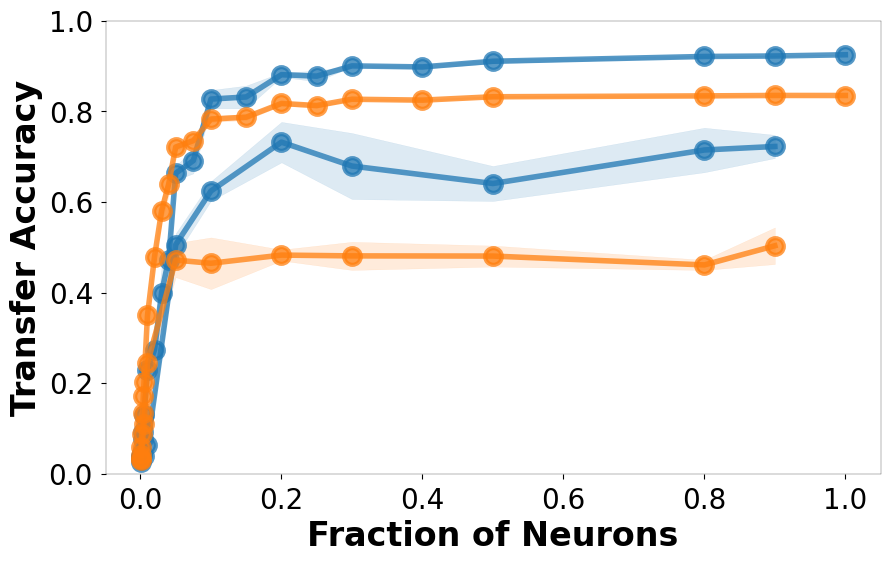

Uploading results in ['results/pca_comparison/imagenet'] to contact.mpi-sws.org...
Uploading 0 files to server


In [14]:
data_to_fracwise = results('resnet50', ['random', 'randproj'], 'imagenet')

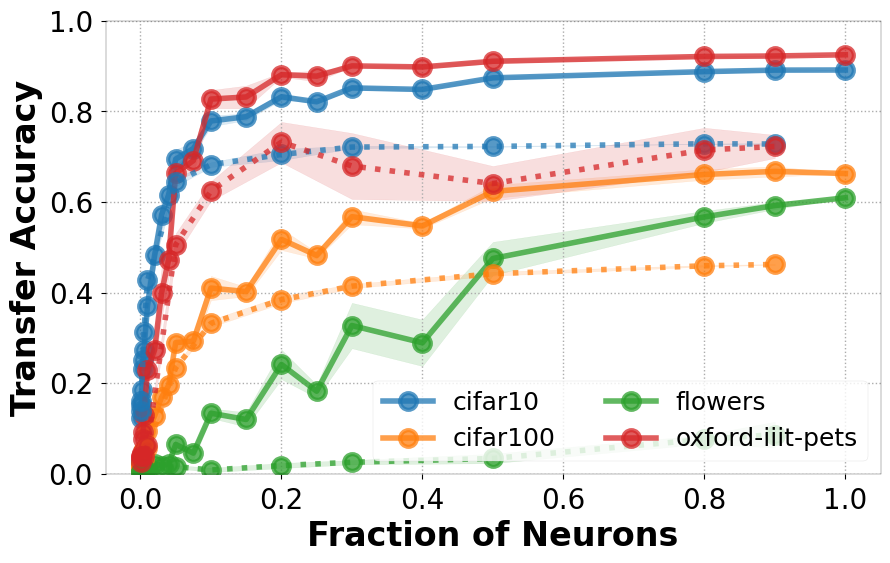

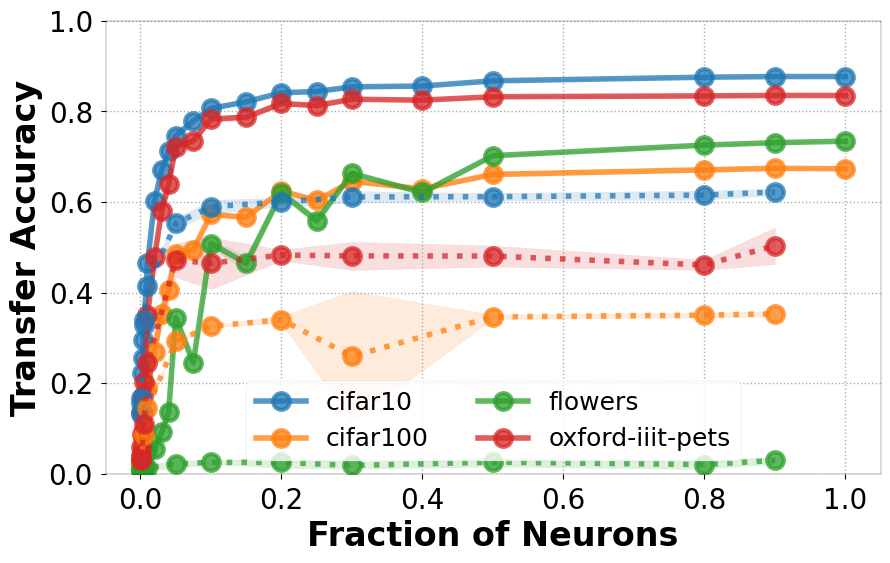

In [26]:
model = 'resnet50'
append = 'nonrob'
plotter(data_to_fracwise, model, append, modes=['random', 'randproj'], 
        filename_append='randomproj_v_random_comparison')

model = 'resnet50'
append = 'robustl2eps3'
plotter(data_to_fracwise, model, append, modes=['random', 'randproj'],
        filename_append='randomproj_v_random_comparison')

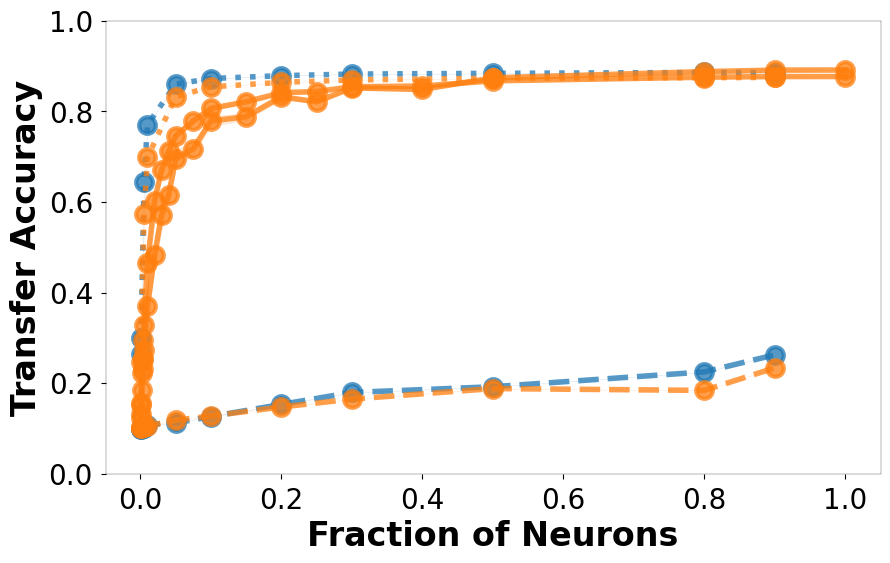

Global seed set to 2
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('projection', tensor([[ 0.0000e+00],
        [-1.5083e-08],
        [-7.5966e-09],
        ...,
        [-5.4873e-10],
        [-2.3624e-08],
        [ 1.5616e-09]]))]), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=1, out_features=100, bias=True))]), 'num_neurons': 1, 'in_features': 1, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

In [ ]:
data_to_fracwise = results('resnet50', ['random', 'pca', 'pca-least'], 'imagenet')

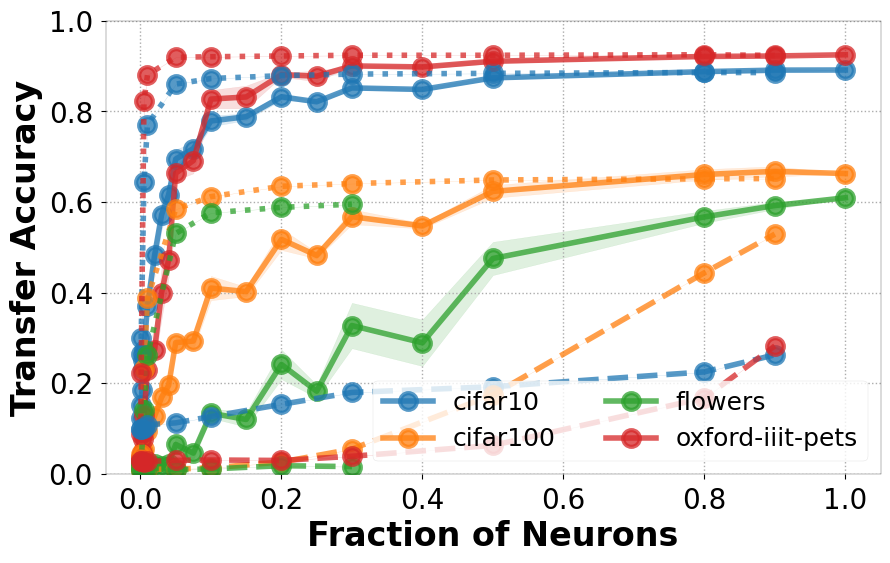

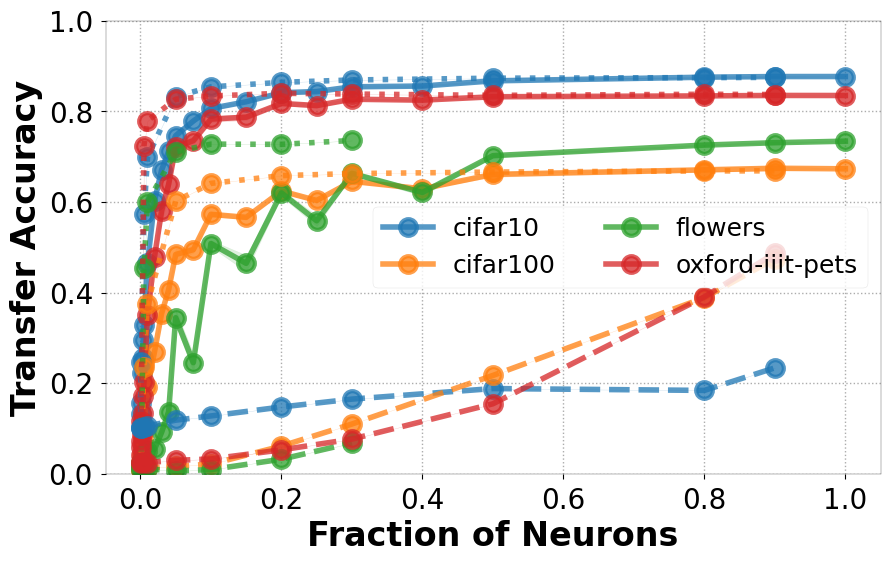

In [32]:
model = 'resnet50'
append = 'nonrob'
plotter(data_to_fracwise, model, append, modes=['random', 'pca', 'pca-least'], 
        filename_append='pca_v_pca-least_v_random_comparison')

model = 'resnet50'
append = 'robustl2eps3'
plotter(data_to_fracwise, model, append, modes=['random', 'pca', 'pca-least'], 
        filename_append='pca_v_pca-least_v_random_comparison')